## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (610, 340)
Hypercube shape: (610, 340, 103)


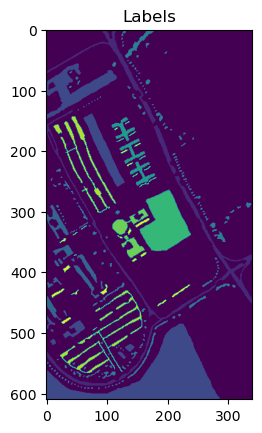

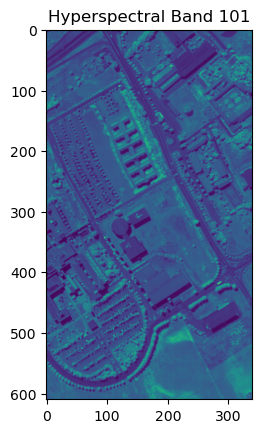

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'PaviaU_gt.mat'
data_files = 'PaviaU.mat'
label_files = 'paviaU_gt'
hypercube_files = 'paviaU'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 42776
Extracted windows shape: (42776, 5, 5, 103)
Corresponding labels shape: (42776,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 20)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 6631 samples
Shuffled class indices for class '1'
Selected 20 training samples and 5 validation samples for class '1'

Class: 2: Found 18649 samples
Shuffled class indices for class '2'
Selected 20 training samples and 5 validation samples for class '2'

Class: 3: Found 2099 samples
Shuffled class indices for class '3'
Selected 20 training samples and 5 validation samples for class '3'

Class: 4: Found 3064 samples
Shuffled class indices for class '4'
Selected 20 training samples and 5 validation samples for class '4'

Class: 5: Found 1345 samples
Shuffled class indices for class '5'
Selected 20 training samples and 5 validation samples for class '5'

Class: 6: Found 5029 samples
Shuffled class indices for class '6'
Selected 20 training samples and 5 validation samples for class '6'

Class: 7: Found 1330 samples
Shuffled class indices for class '7'
Selected 20 train


All datasets saved to the 'indices' folder.
(180, 5, 5, 103)
(45, 5, 5, 103)
(42551, 5, 5, 103)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 180
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (34220, 5, 5, 103)
Validation data shape: (8556, 5, 5, 103)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

103


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/535], Loss: 0.1180, PSNR: 7.1887


	 Training Batch [200/535], Loss: 0.0675, PSNR: 9.8973


	 Training Batch [400/535], Loss: 0.0287, PSNR: 15.4209


Epoch [1/50] Training Loss: 0.0571, PSNR: 11.0792
	[Val]   Batch [1/134] Loss: 0.0197, PSNR: 15.2595
	[Val]   Batch [10/134] Loss: 0.0175, PSNR: 17.5752
	[Val]   Batch [20/134] Loss: 0.0187, PSNR: 15.3888
	[Val]   Batch [30/134] Loss: 0.0202, PSNR: 14.8783
	[Val]   Batch [40/134] Loss: 0.0184, PSNR: 13.8830
	[Val]   Batch [50/134] Loss: 0.0194, PSNR: 15.0840
	[Val]   Batch [60/134] Loss: 0.0178, PSNR: 15.6868


	[Val]   Batch [70/134] Loss: 0.0170, PSNR: 15.8601
	[Val]   Batch [80/134] Loss: 0.0167, PSNR: 15.8523
	[Val]   Batch [90/134] Loss: 0.0173, PSNR: 15.8887
	[Val]   Batch [100/134] Loss: 0.0196, PSNR: 15.2927
	[Val]   Batch [110/134] Loss: 0.0198, PSNR: 13.8502
	[Val]   Batch [120/134] Loss: 0.0164, PSNR: 14.9457
	[Val]   Batch [130/134] Loss: 0.0180, PSNR: 13.0022
Epoch [1/50] Validation Loss: 0.0187, PSNR: 15.2566

LOG: Epoch [2/50]
	 Training Batch [1/535], Loss: 0.0178, PSNR: 15.7041


	 Training Batch [200/535], Loss: 0.0124, PSNR: 15.3498


	 Training Batch [400/535], Loss: 0.0101, PSNR: 18.3800


Epoch [2/50] Training Loss: 0.0118, PSNR: 17.3700
	[Val]   Batch [1/134] Loss: 0.0088, PSNR: 18.7399
	[Val]   Batch [10/134] Loss: 0.0071, PSNR: 21.4875
	[Val]   Batch [20/134] Loss: 0.0077, PSNR: 19.2210
	[Val]   Batch [30/134] Loss: 0.0087, PSNR: 18.5114
	[Val]   Batch [40/134] Loss: 0.0079, PSNR: 17.5745
	[Val]   Batch [50/134] Loss: 0.0082, PSNR: 18.8400
	[Val]   Batch [60/134] Loss: 0.0072, PSNR: 19.6455


	[Val]   Batch [70/134] Loss: 0.0070, PSNR: 19.7341
	[Val]   Batch [80/134] Loss: 0.0067, PSNR: 19.8382
	[Val]   Batch [90/134] Loss: 0.0071, PSNR: 19.7881
	[Val]   Batch [100/134] Loss: 0.0084, PSNR: 18.9459
	[Val]   Batch [110/134] Loss: 0.0080, PSNR: 17.7579
	[Val]   Batch [120/134] Loss: 0.0060, PSNR: 19.3123
	[Val]   Batch [130/134] Loss: 0.0072, PSNR: 16.9602
Epoch [2/50] Validation Loss: 0.0080, PSNR: 18.9788

LOG: Epoch [3/50]


	 Training Batch [1/535], Loss: 0.0091, PSNR: 18.5438


	 Training Batch [200/535], Loss: 0.0064, PSNR: 20.0427


	 Training Batch [400/535], Loss: 0.0061, PSNR: 20.1610


Epoch [3/50] Training Loss: 0.0069, PSNR: 19.6303
	[Val]   Batch [1/134] Loss: 0.0063, PSNR: 20.2360
	[Val]   Batch [10/134] Loss: 0.0049, PSNR: 23.0836
	[Val]   Batch [20/134] Loss: 0.0053, PSNR: 20.8701
	[Val]   Batch [30/134] Loss: 0.0060, PSNR: 20.1314
	[Val]   Batch [40/134] Loss: 0.0055, PSNR: 19.1486
	[Val]   Batch [50/134] Loss: 0.0056, PSNR: 20.5040
	[Val]   Batch [60/134] Loss: 0.0049, PSNR: 21.3250


	[Val]   Batch [70/134] Loss: 0.0049, PSNR: 21.3141
	[Val]   Batch [80/134] Loss: 0.0046, PSNR: 21.4816
	[Val]   Batch [90/134] Loss: 0.0048, PSNR: 21.4166
	[Val]   Batch [100/134] Loss: 0.0059, PSNR: 20.5116
	[Val]   Batch [110/134] Loss: 0.0053, PSNR: 19.5407
	[Val]   Batch [120/134] Loss: 0.0039, PSNR: 21.2271
	[Val]   Batch [130/134] Loss: 0.0048, PSNR: 18.7092
Epoch [3/50] Validation Loss: 0.0056, PSNR: 20.5570

LOG: Epoch [4/50]
	 Training Batch [1/535], Loss: 0.0047, PSNR: 20.8250


	 Training Batch [200/535], Loss: 0.0052, PSNR: 20.5634


	 Training Batch [400/535], Loss: 0.0044, PSNR: 21.6469


Epoch [4/50] Training Loss: 0.0049, PSNR: 21.0960
	[Val]   Batch [1/134] Loss: 0.0042, PSNR: 21.9940
	[Val]   Batch [10/134] Loss: 0.0034, PSNR: 24.7494
	[Val]   Batch [20/134] Loss: 0.0034, PSNR: 22.7490
	[Val]   Batch [30/134] Loss: 0.0039, PSNR: 22.0466
	[Val]   Batch [40/134] Loss: 0.0035, PSNR: 21.0587
	[Val]   Batch [50/134] Loss: 0.0035, PSNR: 22.5559
	[Val]   Batch [60/134] Loss: 0.0034, PSNR: 22.9487
	[Val]   Batch [70/134] Loss: 0.0033, PSNR: 22.9780


	[Val]   Batch [80/134] Loss: 0.0031, PSNR: 23.2022
	[Val]   Batch [90/134] Loss: 0.0032, PSNR: 23.1566
	[Val]   Batch [100/134] Loss: 0.0039, PSNR: 22.2778
	[Val]   Batch [110/134] Loss: 0.0033, PSNR: 21.5875
	[Val]   Batch [120/134] Loss: 0.0025, PSNR: 23.1503
	[Val]   Batch [130/134] Loss: 0.0030, PSNR: 20.7534
Epoch [4/50] Validation Loss: 0.0037, PSNR: 22.3231

LOG: Epoch [5/50]
	 Training Batch [1/535], Loss: 0.0037, PSNR: 20.4922


	 Training Batch [200/535], Loss: 0.0035, PSNR: 22.5995


	 Training Batch [400/535], Loss: 0.0033, PSNR: 22.9929


Epoch [5/50] Training Loss: 0.0036, PSNR: 22.5026
	[Val]   Batch [1/134] Loss: 0.0031, PSNR: 23.2838
	[Val]   Batch [10/134] Loss: 0.0025, PSNR: 26.0529
	[Val]   Batch [20/134] Loss: 0.0024, PSNR: 24.2876
	[Val]   Batch [30/134] Loss: 0.0027, PSNR: 23.5841
	[Val]   Batch [40/134] Loss: 0.0025, PSNR: 22.6247
	[Val]   Batch [50/134] Loss: 0.0024, PSNR: 24.1912
	[Val]   Batch [60/134] Loss: 0.0026, PSNR: 24.1042


	[Val]   Batch [70/134] Loss: 0.0025, PSNR: 24.2482
	[Val]   Batch [80/134] Loss: 0.0023, PSNR: 24.5021
	[Val]   Batch [90/134] Loss: 0.0024, PSNR: 24.4243
	[Val]   Batch [100/134] Loss: 0.0028, PSNR: 23.6666
	[Val]   Batch [110/134] Loss: 0.0022, PSNR: 23.3059
	[Val]   Batch [120/134] Loss: 0.0017, PSNR: 24.6752
	[Val]   Batch [130/134] Loss: 0.0021, PSNR: 22.2967
Epoch [5/50] Validation Loss: 0.0027, PSNR: 23.6900

LOG: Epoch [6/50]


	 Training Batch [1/535], Loss: 0.0032, PSNR: 23.0783


	 Training Batch [200/535], Loss: 0.0029, PSNR: 25.3586


	 Training Batch [400/535], Loss: 0.0028, PSNR: 23.7931


Epoch [6/50] Training Loss: 0.0028, PSNR: 23.5085
	[Val]   Batch [1/134] Loss: 0.0026, PSNR: 24.1088
	[Val]   Batch [10/134] Loss: 0.0020, PSNR: 26.9366
	[Val]   Batch [20/134] Loss: 0.0019, PSNR: 25.4286
	[Val]   Batch [30/134] Loss: 0.0022, PSNR: 24.6032
	[Val]   Batch [40/134] Loss: 0.0019, PSNR: 23.7265
	[Val]   Batch [50/134] Loss: 0.0019, PSNR: 25.2829
	[Val]   Batch [60/134] Loss: 0.0021, PSNR: 24.8997


	[Val]   Batch [70/134] Loss: 0.0020, PSNR: 25.1169
	[Val]   Batch [80/134] Loss: 0.0018, PSNR: 25.4002
	[Val]   Batch [90/134] Loss: 0.0020, PSNR: 25.2598
	[Val]   Batch [100/134] Loss: 0.0023, PSNR: 24.6075
	[Val]   Batch [110/134] Loss: 0.0017, PSNR: 24.5383
	[Val]   Batch [120/134] Loss: 0.0013, PSNR: 25.8112
	[Val]   Batch [130/134] Loss: 0.0017, PSNR: 23.3546
Epoch [6/50] Validation Loss: 0.0022, PSNR: 24.6312

LOG: Epoch [7/50]


	 Training Batch [1/535], Loss: 0.0031, PSNR: 23.2356


	 Training Batch [200/535], Loss: 0.0030, PSNR: 23.2760


	 Training Batch [400/535], Loss: 0.0032, PSNR: 23.1262


Epoch [7/50] Training Loss: 0.0024, PSNR: 24.1757
	[Val]   Batch [1/134] Loss: 0.0023, PSNR: 24.6483
	[Val]   Batch [10/134] Loss: 0.0018, PSNR: 27.5177
	[Val]   Batch [20/134] Loss: 0.0016, PSNR: 26.1783
	[Val]   Batch [30/134] Loss: 0.0018, PSNR: 25.2936
	[Val]   Batch [40/134] Loss: 0.0016, PSNR: 24.4742
	[Val]   Batch [50/134] Loss: 0.0016, PSNR: 26.0138
	[Val]   Batch [60/134] Loss: 0.0019, PSNR: 25.4571


	[Val]   Batch [70/134] Loss: 0.0018, PSNR: 25.6876
	[Val]   Batch [80/134] Loss: 0.0016, PSNR: 26.0153
	[Val]   Batch [90/134] Loss: 0.0018, PSNR: 25.7966
	[Val]   Batch [100/134] Loss: 0.0020, PSNR: 25.2418
	[Val]   Batch [110/134] Loss: 0.0014, PSNR: 25.3630
	[Val]   Batch [120/134] Loss: 0.0011, PSNR: 26.5664
	[Val]   Batch [130/134] Loss: 0.0014, PSNR: 24.0257
Epoch [7/50] Validation Loss: 0.0019, PSNR: 25.2643

LOG: Epoch [8/50]
	 Training Batch [1/535], Loss: 0.0020, PSNR: 25.1178


	 Training Batch [200/535], Loss: 0.0018, PSNR: 25.5438


	 Training Batch [400/535], Loss: 0.0022, PSNR: 24.7556


Epoch [8/50] Training Loss: 0.0022, PSNR: 24.6427
	[Val]   Batch [1/134] Loss: 0.0021, PSNR: 25.0536
	[Val]   Batch [10/134] Loss: 0.0016, PSNR: 27.9774
	[Val]   Batch [20/134] Loss: 0.0014, PSNR: 26.7725
	[Val]   Batch [30/134] Loss: 0.0016, PSNR: 25.7991
	[Val]   Batch [40/134] Loss: 0.0014, PSNR: 25.0617
	[Val]   Batch [50/134] Loss: 0.0014, PSNR: 26.5393
	[Val]   Batch [60/134] Loss: 0.0017, PSNR: 25.8998


	[Val]   Batch [70/134] Loss: 0.0016, PSNR: 26.1425
	[Val]   Batch [80/134] Loss: 0.0014, PSNR: 26.5151
	[Val]   Batch [90/134] Loss: 0.0016, PSNR: 26.2153
	[Val]   Batch [100/134] Loss: 0.0018, PSNR: 25.7218
	[Val]   Batch [110/134] Loss: 0.0012, PSNR: 25.9877
	[Val]   Batch [120/134] Loss: 0.0010, PSNR: 27.2191
	[Val]   Batch [130/134] Loss: 0.0013, PSNR: 24.5454
Epoch [8/50] Validation Loss: 0.0017, PSNR: 25.7576

LOG: Epoch [9/50]
	 Training Batch [1/535], Loss: 0.0022, PSNR: 24.5952


	 Training Batch [200/535], Loss: 0.0020, PSNR: 25.0734


	 Training Batch [400/535], Loss: 0.0016, PSNR: 23.6636


Epoch [9/50] Training Loss: 0.0020, PSNR: 25.0126
	[Val]   Batch [1/134] Loss: 0.0019, PSNR: 25.4021
	[Val]   Batch [10/134] Loss: 0.0015, PSNR: 28.3062
	[Val]   Batch [20/134] Loss: 0.0012, PSNR: 27.2766
	[Val]   Batch [30/134] Loss: 0.0015, PSNR: 26.2591
	[Val]   Batch [40/134] Loss: 0.0013, PSNR: 25.5417
	[Val]   Batch [50/134] Loss: 0.0012, PSNR: 27.0019
	[Val]   Batch [60/134] Loss: 0.0016, PSNR: 26.2380


	[Val]   Batch [70/134] Loss: 0.0015, PSNR: 26.4605
	[Val]   Batch [80/134] Loss: 0.0013, PSNR: 26.8646
	[Val]   Batch [90/134] Loss: 0.0015, PSNR: 26.5472
	[Val]   Batch [100/134] Loss: 0.0016, PSNR: 26.1281
	[Val]   Batch [110/134] Loss: 0.0011, PSNR: 26.5722
	[Val]   Batch [120/134] Loss: 0.0009, PSNR: 27.6874
	[Val]   Batch [130/134] Loss: 0.0011, PSNR: 24.9869
Epoch [9/50] Validation Loss: 0.0016, PSNR: 26.1675

LOG: Epoch [10/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 25.5042


	 Training Batch [200/535], Loss: 0.0016, PSNR: 26.1911


	 Training Batch [400/535], Loss: 0.0016, PSNR: 26.0205


Epoch [10/50] Training Loss: 0.0019, PSNR: 25.2399
	[Val]   Batch [1/134] Loss: 0.0018, PSNR: 25.5835
	[Val]   Batch [10/134] Loss: 0.0014, PSNR: 28.4884
	[Val]   Batch [20/134] Loss: 0.0011, PSNR: 27.5438
	[Val]   Batch [30/134] Loss: 0.0014, PSNR: 26.4928
	[Val]   Batch [40/134] Loss: 0.0012, PSNR: 25.8056
	[Val]   Batch [50/134] Loss: 0.0012, PSNR: 27.2336
	[Val]   Batch [60/134] Loss: 0.0015, PSNR: 26.4364


	[Val]   Batch [70/134] Loss: 0.0014, PSNR: 26.6725
	[Val]   Batch [80/134] Loss: 0.0013, PSNR: 27.0755
	[Val]   Batch [90/134] Loss: 0.0014, PSNR: 26.7475
	[Val]   Batch [100/134] Loss: 0.0015, PSNR: 26.3600
	[Val]   Batch [110/134] Loss: 0.0010, PSNR: 26.8429
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 27.9287
	[Val]   Batch [130/134] Loss: 0.0011, PSNR: 25.2074
Epoch [10/50] Validation Loss: 0.0015, PSNR: 26.3920

LOG: Epoch [11/50]
	 Training Batch [1/535], Loss: 0.0017, PSNR: 25.8578


	 Training Batch [200/535], Loss: 0.0025, PSNR: 24.2325


	 Training Batch [400/535], Loss: 0.0015, PSNR: 26.1915


Epoch [11/50] Training Loss: 0.0018, PSNR: 25.4924
	[Val]   Batch [1/134] Loss: 0.0017, PSNR: 25.8432
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 28.7951
	[Val]   Batch [20/134] Loss: 0.0010, PSNR: 27.9177
	[Val]   Batch [30/134] Loss: 0.0013, PSNR: 26.8015
	[Val]   Batch [40/134] Loss: 0.0011, PSNR: 26.1545
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.5341
	[Val]   Batch [60/134] Loss: 0.0014, PSNR: 26.7355


	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 26.9556
	[Val]   Batch [80/134] Loss: 0.0012, PSNR: 27.4008
	[Val]   Batch [90/134] Loss: 0.0013, PSNR: 27.0517
	[Val]   Batch [100/134] Loss: 0.0014, PSNR: 26.6421
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.2373
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 28.3450
	[Val]   Batch [130/134] Loss: 0.0010, PSNR: 25.5687
Epoch [11/50] Validation Loss: 0.0014, PSNR: 26.7036

LOG: Epoch [12/50]
	 Training Batch [1/535], Loss: 0.0014, PSNR: 24.5318


	 Training Batch [200/535], Loss: 0.0012, PSNR: 26.5766


	 Training Batch [400/535], Loss: 0.0016, PSNR: 26.0725


Epoch [12/50] Training Loss: 0.0017, PSNR: 25.6377
	[Val]   Batch [1/134] Loss: 0.0016, PSNR: 26.0463
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 29.0258
	[Val]   Batch [20/134] Loss: 0.0010, PSNR: 28.2354
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 27.0883
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.4640
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 27.8362


	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 26.9716
	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 27.1481
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.6739
	[Val]   Batch [90/134] Loss: 0.0013, PSNR: 27.2822
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 26.9195
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.5957
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.6317


	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 25.8512
Epoch [12/50] Validation Loss: 0.0013, PSNR: 26.9780

LOG: Epoch [13/50]
	 Training Batch [1/535], Loss: 0.0019, PSNR: 27.1387


	 Training Batch [200/535], Loss: 0.0016, PSNR: 26.0132


	 Training Batch [400/535], Loss: 0.0016, PSNR: 26.2088


Epoch [13/50] Training Loss: 0.0017, PSNR: 25.8038
	[Val]   Batch [1/134] Loss: 0.0016, PSNR: 26.1576
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.1142
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.3571
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 27.1928
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.5747
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 27.8993
	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 27.0790
	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.2828


	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.7992
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.3850
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 26.9947
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.6498
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.7443
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 25.9413
Epoch [13/50] Validation Loss: 0.0013, PSNR: 27.0853

LOG: Epoch [14/50]
	 Training Batch [1/535], Loss: 0.0013, PSNR: 28.8950


	 Training Batch [200/535], Loss: 0.0014, PSNR: 26.8179


	 Training Batch [400/535], Loss: 0.0014, PSNR: 26.6273


Epoch [14/50] Training Loss: 0.0016, PSNR: 25.9906
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.3290
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.3246
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.6327
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.4246
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 26.7957
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 28.1131
	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.2873


	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.4716
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 28.0371
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.5944
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 27.1931
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.9249
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.0155
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 26.1540
Epoch [14/50] Validation Loss: 0.0012, PSNR: 27.3020

LOG: Epoch [15/50]
	 Training Batch [1/535], Loss: 0.0024, PSNR: 24.2296


	 Training Batch [200/535], Loss: 0.0014, PSNR: 26.4859


	 Training Batch [400/535], Loss: 0.0012, PSNR: 25.9351


Epoch [15/50] Training Loss: 0.0016, PSNR: 26.1800
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.5477
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.5575
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 28.9584
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.7059
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 27.1125
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.4092
	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.5414


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.6999
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.3378
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.8517
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.4437
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.2787
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.3305
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.4610
Epoch [15/50] Validation Loss: 0.0011, PSNR: 27.5780

LOG: Epoch [16/50]
	 Training Batch [1/535], Loss: 0.0013, PSNR: 27.0730


	 Training Batch [200/535], Loss: 0.0009, PSNR: 27.3127


	 Training Batch [400/535], Loss: 0.0015, PSNR: 26.5034


Epoch [16/50] Training Loss: 0.0015, PSNR: 26.2713
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.6844
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.6868
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 29.1407
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 27.8341
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.2949
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.5440
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.6970


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.8628
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.4813
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.9950
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.5536
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.3846
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.4568
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.6436
Epoch [16/50] Validation Loss: 0.0011, PSNR: 27.7222

LOG: Epoch [17/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.4969


	 Training Batch [200/535], Loss: 0.0014, PSNR: 26.5734


	 Training Batch [400/535], Loss: 0.0017, PSNR: 27.6435


Epoch [17/50] Training Loss: 0.0015, PSNR: 26.3877
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.8188
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 29.8030
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 29.3135
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 27.9972
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.4758
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.7131
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.8532


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.0034
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.6380
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.1419
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.6983
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.5864
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.6315
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 26.8016
Epoch [17/50] Validation Loss: 0.0011, PSNR: 27.8803

LOG: Epoch [18/50]


	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.6018


	 Training Batch [200/535], Loss: 0.0010, PSNR: 26.3385


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.2096


Epoch [18/50] Training Loss: 0.0014, PSNR: 26.5472
	[Val]   Batch [1/134] Loss: 0.0013, PSNR: 26.9711
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 29.9035
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.4900
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 28.1502
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.5779
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.8554
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.9814


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.1089
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 28.7838
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.2779
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.8290
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.7103
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.7016
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 26.9202
Epoch [18/50] Validation Loss: 0.0010, PSNR: 28.0048

LOG: Epoch [19/50]
	 Training Batch [1/535], Loss: 0.0013, PSNR: 26.9709


	 Training Batch [200/535], Loss: 0.0010, PSNR: 28.1738


	 Training Batch [400/535], Loss: 0.0009, PSNR: 26.8379


Epoch [19/50] Training Loss: 0.0014, PSNR: 26.6983
	[Val]   Batch [1/134] Loss: 0.0013, PSNR: 27.1742
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 30.0884
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.7508
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.3858
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 27.8443
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 29.0786
	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.2153


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.3240
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 29.0391
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.4834
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.0381
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.9653
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.9692
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.1498
Epoch [19/50] Validation Loss: 0.0010, PSNR: 28.2338

LOG: Epoch [20/50]


	 Training Batch [1/535], Loss: 0.0012, PSNR: 26.4861


	 Training Batch [200/535], Loss: 0.0009, PSNR: 25.4265


	 Training Batch [400/535], Loss: 0.0014, PSNR: 26.6624


Epoch [20/50] Training Loss: 0.0013, PSNR: 26.8193
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.3095
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 30.2181
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.9454
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.5424
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.0069
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.2236
	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.3846


	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.4794
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 29.2099
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.6491
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.1807
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.1202
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.1184
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.2842
Epoch [20/50] Validation Loss: 0.0010, PSNR: 28.3908

LOG: Epoch [21/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.5393


	 Training Batch [200/535], Loss: 0.0016, PSNR: 26.2659


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.2340


Epoch [21/50] Training Loss: 0.0013, PSNR: 26.9240
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.3604
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.2253
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.9508
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.5809
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.0336
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 29.2191
	[Val]   Batch [60/134] Loss: 0.0009, PSNR: 28.4441


	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.5428
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 29.2354
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.6800
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.2333
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.0184
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.0360
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.2726
Epoch [21/50] Validation Loss: 0.0009, PSNR: 28.4121
Early stopping triggered at epoch 21. No improvement for 3 epochs.


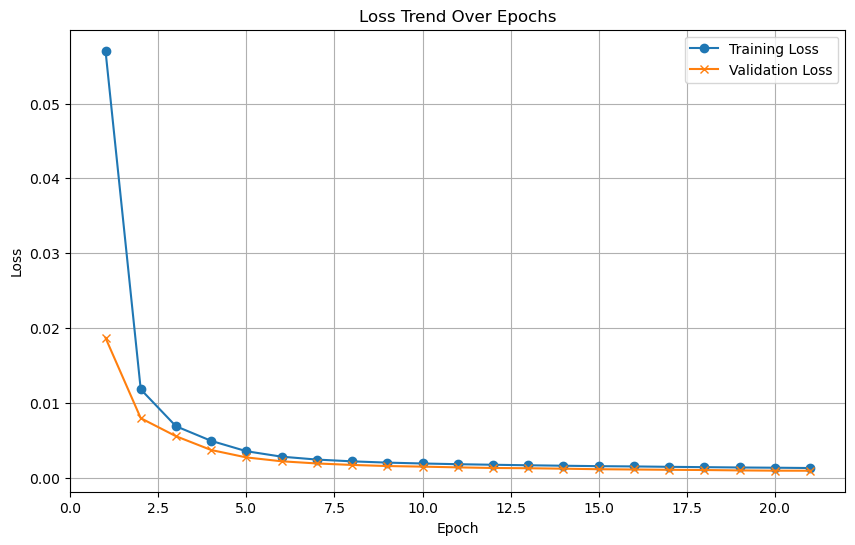

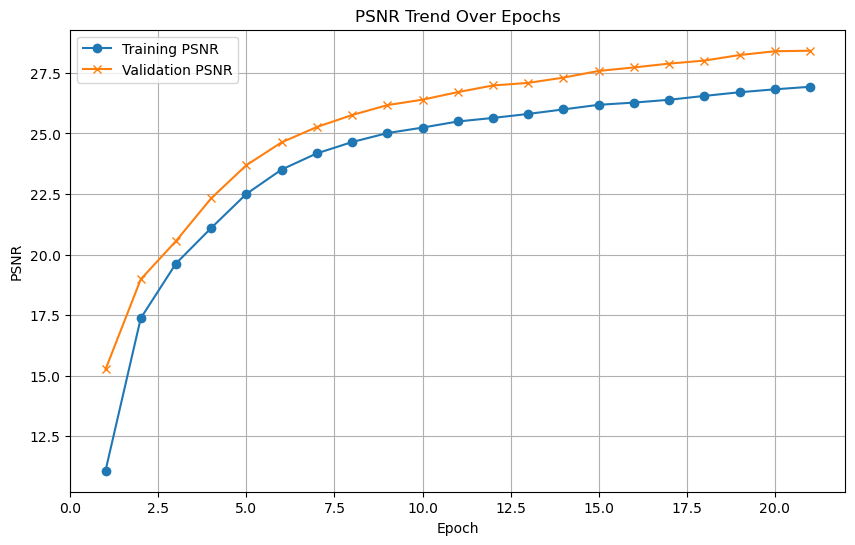

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/167 for test dataset.


    Processed batch 101/167 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.1723
    Validation Batch [1/1], Loss: 2.2045
Validation Loss: 2.2045, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2045. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1284
    Validation Batch [1/1], Loss: 2.2045
Validation Loss: 2.2045, Validation Accuracy: 11.11%
Validation loss improved from 2.2045 to 2.2045. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.0961
    Validation Batch [1/1], Loss: 2.2045
Validation Loss: 2.2045, Validation Accuracy: 11.11%
Validation loss improved from 2.2045 to 2.2045. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.0870
    Validation Batch [1/1], Loss: 2.2045
Validation Loss: 2.2045, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [5/1000] - Training
Ep

Epoch [21/1000] completed, Average Training Loss: 1.8468
    Validation Batch [1/1], Loss: 2.1964
Validation Loss: 2.1964, Validation Accuracy: 11.11%
Validation loss improved from 2.1981 to 2.1964. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 1.8420
    Validation Batch [1/1], Loss: 2.1945
Validation Loss: 2.1945, Validation Accuracy: 11.11%
Validation loss improved from 2.1964 to 2.1945. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 1.8011
    Validation Batch [1/1], Loss: 2.1923
Validation Loss: 2.1923, Validation Accuracy: 11.11%
Validation loss improved from 2.1945 to 2.1923. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 1.8109
    Validation Batch [1/1], Loss: 2.1896
Validation Loss: 2.1896, Validation Accuracy: 11.11%
Validation loss improved from 2.1923 to 2.1896. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [2

Epoch [51/1000] completed, Average Training Loss: 1.5968
    Validation Batch [1/1], Loss: 1.8052
Validation Loss: 1.8052, Validation Accuracy: 57.78%
Validation loss improved from 1.8240 to 1.8052. Saving model...

LOG: Epoch [52/1000] - Training
Epoch [52/1000] completed, Average Training Loss: 1.5932
    Validation Batch [1/1], Loss: 1.7868
Validation Loss: 1.7868, Validation Accuracy: 62.22%
Validation loss improved from 1.8052 to 1.7868. Saving model...

LOG: Epoch [53/1000] - Training
Epoch [53/1000] completed, Average Training Loss: 1.5879
    Validation Batch [1/1], Loss: 1.7700
Validation Loss: 1.7700, Validation Accuracy: 62.22%
Validation loss improved from 1.7868 to 1.7700. Saving model...

LOG: Epoch [54/1000] - Training
Epoch [54/1000] completed, Average Training Loss: 1.5720
    Validation Batch [1/1], Loss: 1.7534
Validation Loss: 1.7534, Validation Accuracy: 62.22%
Validation loss improved from 1.7700 to 1.7534. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [5

Validation Loss: 1.4644, Validation Accuracy: 62.22%
Validation loss improved from 1.4735 to 1.4644. Saving model...

LOG: Epoch [81/1000] - Training
Epoch [81/1000] completed, Average Training Loss: 1.3660
    Validation Batch [1/1], Loss: 1.4539
Validation Loss: 1.4539, Validation Accuracy: 64.44%
Validation loss improved from 1.4644 to 1.4539. Saving model...

LOG: Epoch [82/1000] - Training
Epoch [82/1000] completed, Average Training Loss: 1.3515
    Validation Batch [1/1], Loss: 1.4443
Validation Loss: 1.4443, Validation Accuracy: 64.44%
Validation loss improved from 1.4539 to 1.4443. Saving model...

LOG: Epoch [83/1000] - Training
Epoch [83/1000] completed, Average Training Loss: 1.3406
    Validation Batch [1/1], Loss: 1.4386
Validation Loss: 1.4386, Validation Accuracy: 62.22%
Validation loss improved from 1.4443 to 1.4386. Saving model...

LOG: Epoch [84/1000] - Training
Epoch [84/1000] completed, Average Training Loss: 1.3142
    Validation Batch [1/1], Loss: 1.4365
Validati

Epoch [111/1000] completed, Average Training Loss: 1.1117
    Validation Batch [1/1], Loss: 1.2407
Validation Loss: 1.2407, Validation Accuracy: 66.67%
Validation loss improved from 1.2441 to 1.2407. Saving model...

LOG: Epoch [112/1000] - Training
Epoch [112/1000] completed, Average Training Loss: 1.1049
    Validation Batch [1/1], Loss: 1.2365
Validation Loss: 1.2365, Validation Accuracy: 68.89%
Validation loss improved from 1.2407 to 1.2365. Saving model...

LOG: Epoch [113/1000] - Training
Epoch [113/1000] completed, Average Training Loss: 1.1107
    Validation Batch [1/1], Loss: 1.2332
Validation Loss: 1.2332, Validation Accuracy: 64.44%
Validation loss improved from 1.2365 to 1.2332. Saving model...

LOG: Epoch [114/1000] - Training
Epoch [114/1000] completed, Average Training Loss: 1.0834
    Validation Batch [1/1], Loss: 1.2203
Validation Loss: 1.2203, Validation Accuracy: 68.89%
Validation loss improved from 1.2332 to 1.2203. Saving model...

LOG: Epoch [115/1000] - Training


Epoch [140/1000] completed, Average Training Loss: 0.8755
    Validation Batch [1/1], Loss: 1.0604
Validation Loss: 1.0604, Validation Accuracy: 73.33%
Validation loss improved from 1.0626 to 1.0604. Saving model...

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 0.8840
    Validation Batch [1/1], Loss: 1.0511
Validation Loss: 1.0511, Validation Accuracy: 77.78%
Validation loss improved from 1.0604 to 1.0511. Saving model...

LOG: Epoch [142/1000] - Training
Epoch [142/1000] completed, Average Training Loss: 0.8338
    Validation Batch [1/1], Loss: 1.0381
Validation Loss: 1.0381, Validation Accuracy: 80.00%
Validation loss improved from 1.0511 to 1.0381. Saving model...

LOG: Epoch [143/1000] - Training
Epoch [143/1000] completed, Average Training Loss: 0.8563
    Validation Batch [1/1], Loss: 1.0299
Validation Loss: 1.0299, Validation Accuracy: 77.78%
Validation loss improved from 1.0381 to 1.0299. Saving model...

LOG: Epoch [144/1000] - Training


Epoch [168/1000] completed, Average Training Loss: 0.6595
    Validation Batch [1/1], Loss: 0.8643
Validation Loss: 0.8643, Validation Accuracy: 80.00%
Validation loss improved from 0.8720 to 0.8643. Saving model...

LOG: Epoch [169/1000] - Training
Epoch [169/1000] completed, Average Training Loss: 0.6526
    Validation Batch [1/1], Loss: 0.8652
Validation Loss: 0.8652, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [170/1000] - Training
Epoch [170/1000] completed, Average Training Loss: 0.6462
    Validation Batch [1/1], Loss: 0.8619
Validation Loss: 0.8619, Validation Accuracy: 80.00%
Validation loss improved from 0.8643 to 0.8619. Saving model...

LOG: Epoch [171/1000] - Training
Epoch [171/1000] completed, Average Training Loss: 0.6357
    Validation Batch [1/1], Loss: 0.8446
Validation Loss: 0.8446, Validation Accuracy: 82.22%
Validation loss improved from 0.8619 to 0.8446. Saving model...

LOG: Epoch [172/1000] - Training
Epoch [172/1000

Epoch [197/1000] completed, Average Training Loss: 0.4635
    Validation Batch [1/1], Loss: 0.6941
Validation Loss: 0.6941, Validation Accuracy: 88.89%
Validation loss improved from 0.7097 to 0.6941. Saving model...

LOG: Epoch [198/1000] - Training
Epoch [198/1000] completed, Average Training Loss: 0.4370
    Validation Batch [1/1], Loss: 0.6869
Validation Loss: 0.6869, Validation Accuracy: 88.89%
Validation loss improved from 0.6941 to 0.6869. Saving model...

LOG: Epoch [199/1000] - Training
Epoch [199/1000] completed, Average Training Loss: 0.4575
    Validation Batch [1/1], Loss: 0.6896
Validation Loss: 0.6896, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [200/1000] - Training
Epoch [200/1000] completed, Average Training Loss: 0.4439
    Validation Batch [1/1], Loss: 0.6792
Validation Loss: 0.6792, Validation Accuracy: 88.89%
Validation loss improved from 0.6869 to 0.6792. Saving model...

LOG: Epoch [201/1000] - Training
Epoch [201/1000

Epoch [226/1000] completed, Average Training Loss: 0.3152
    Validation Batch [1/1], Loss: 0.5749
Validation Loss: 0.5749, Validation Accuracy: 95.56%
Validation loss improved from 0.5892 to 0.5749. Saving model...

LOG: Epoch [227/1000] - Training
Epoch [227/1000] completed, Average Training Loss: 0.3142
    Validation Batch [1/1], Loss: 0.5669
Validation Loss: 0.5669, Validation Accuracy: 95.56%
Validation loss improved from 0.5749 to 0.5669. Saving model...

LOG: Epoch [228/1000] - Training
Epoch [228/1000] completed, Average Training Loss: 0.3091
    Validation Batch [1/1], Loss: 0.5660
Validation Loss: 0.5660, Validation Accuracy: 88.89%
Validation loss improved from 0.5669 to 0.5660. Saving model...

LOG: Epoch [229/1000] - Training
Epoch [229/1000] completed, Average Training Loss: 0.3183
    Validation Batch [1/1], Loss: 0.5742
Validation Loss: 0.5742, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [230/1000] - Training
Epoch [230/1000

Epoch [253/1000] completed, Average Training Loss: 0.2410
    Validation Batch [1/1], Loss: 0.5253
Validation Loss: 0.5253, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [254/1000] - Training
Epoch [254/1000] completed, Average Training Loss: 0.2385
    Validation Batch [1/1], Loss: 0.5245
Validation Loss: 0.5245, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [255/1000] - Training
Epoch [255/1000] completed, Average Training Loss: 0.2266
    Validation Batch [1/1], Loss: 0.4805
Validation Loss: 0.4805, Validation Accuracy: 88.89%
Validation loss improved from 0.4914 to 0.4805. Saving model...

LOG: Epoch [256/1000] - Training
Epoch [256/1000] completed, Average Training Loss: 0.2286
    Validation Batch [1/1], Loss: 0.4857
Validation Loss: 0.4857, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training 

Epoch [285/1000] completed, Average Training Loss: 0.1667
    Validation Batch [1/1], Loss: 0.4728
Validation Loss: 0.4728, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [286/1000] - Training
Epoch [286/1000] completed, Average Training Loss: 0.1688
    Validation Batch [1/1], Loss: 0.4503
Validation Loss: 0.4503, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [287/1000] - Training
Epoch [287/1000] completed, Average Training Loss: 0.1626
    Validation Batch [1/1], Loss: 0.4411
Validation Loss: 0.4411, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [288/1000] - Training
Epoch [288/1000] completed, Average Training Loss: 0.1551
    Validation Batch [1/1], Loss: 0.4500
Validation Loss: 0.4500, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [289/1000] - Training
Epoch [289/1000] completed, Average Training Loss: 0.1458
  

Epoch [314/1000] completed, Average Training Loss: 0.1184
    Validation Batch [1/1], Loss: 0.3814
Validation Loss: 0.3814, Validation Accuracy: 93.33%
Validation loss improved from 0.3981 to 0.3814. Saving model...

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.1290
    Validation Batch [1/1], Loss: 0.3821
Validation Loss: 0.3821, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.1286
    Validation Batch [1/1], Loss: 0.3842
Validation Loss: 0.3842, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [317/1000] - Training
Epoch [317/1000] completed, Average Training Loss: 0.1240
    Validation Batch [1/1], Loss: 0.3910
Validation Loss: 0.3910, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [318/1000] - Training
Epoch [318/1000] completed, Average Training 

Epoch [344/1000] completed, Average Training Loss: 0.1101
    Validation Batch [1/1], Loss: 0.3891
Validation Loss: 0.3891, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [345/1000] - Training
Epoch [345/1000] completed, Average Training Loss: 0.1010
    Validation Batch [1/1], Loss: 0.3795
Validation Loss: 0.3795, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [346/1000] - Training
Epoch [346/1000] completed, Average Training Loss: 0.1022
    Validation Batch [1/1], Loss: 0.3775
Validation Loss: 0.3775, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [347/1000] - Training
Epoch [347/1000] completed, Average Training Loss: 0.0957
    Validation Batch [1/1], Loss: 0.3711
Validation Loss: 0.3711, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [348/1000] - Training
Epoch [348/1000] completed, Average Training Loss: 0.0879
  

Epoch [373/1000] completed, Average Training Loss: 0.0827
    Validation Batch [1/1], Loss: 0.4269
Validation Loss: 0.4269, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [374/1000] - Training
Epoch [374/1000] completed, Average Training Loss: 0.0689
    Validation Batch [1/1], Loss: 0.3881
Validation Loss: 0.3881, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [375/1000] - Training
Epoch [375/1000] completed, Average Training Loss: 0.0791
    Validation Batch [1/1], Loss: 0.3363
Validation Loss: 0.3363, Validation Accuracy: 95.56%
Validation loss improved from 0.3521 to 0.3363. Saving model...

LOG: Epoch [376/1000] - Training
Epoch [376/1000] completed, Average Training Loss: 0.0655
    Validation Batch [1/1], Loss: 0.3790
Validation Loss: 0.3790, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [377/1000] - Training
Epoch [377/1000] completed, Average Training 

Epoch [401/1000] completed, Average Training Loss: 0.0649
    Validation Batch [1/1], Loss: 0.3454
Validation Loss: 0.3454, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [402/1000] - Training
Epoch [402/1000] completed, Average Training Loss: 0.0614
    Validation Batch [1/1], Loss: 0.4196
Validation Loss: 0.4196, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [403/1000] - Training
Epoch [403/1000] completed, Average Training Loss: 0.0698
    Validation Batch [1/1], Loss: 0.4491
Validation Loss: 0.4491, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [404/1000] - Training
Epoch [404/1000] completed, Average Training Loss: 0.0713
    Validation Batch [1/1], Loss: 0.3777
Validation Loss: 0.3777, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [405/1000] - Training
Epoch [405/1000] completed, Average Training Loss: 0.070

Epoch [431/1000] completed, Average Training Loss: 0.0515
    Validation Batch [1/1], Loss: 0.3329
Validation Loss: 0.3329, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [432/1000] - Training
Epoch [432/1000] completed, Average Training Loss: 0.0415
    Validation Batch [1/1], Loss: 0.3200
Validation Loss: 0.3200, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [433/1000] - Training
Epoch [433/1000] completed, Average Training Loss: 0.0532
    Validation Batch [1/1], Loss: 0.3246
Validation Loss: 0.3246, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [434/1000] - Training
Epoch [434/1000] completed, Average Training Loss: 0.0465
    Validation Batch [1/1], Loss: 0.3558
Validation Loss: 0.3558, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [435/1000] - Training
Epoch [435/1000] completed, Average Training Loss: 0.050

Epoch [461/1000] completed, Average Training Loss: 0.0425
    Validation Batch [1/1], Loss: 0.3493
Validation Loss: 0.3493, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [462/1000] - Training
Epoch [462/1000] completed, Average Training Loss: 0.0448
    Validation Batch [1/1], Loss: 0.3463
Validation Loss: 0.3463, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [463/1000] - Training
Epoch [463/1000] completed, Average Training Loss: 0.0443
    Validation Batch [1/1], Loss: 0.3359
Validation Loss: 0.3359, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [464/1000] - Training
Epoch [464/1000] completed, Average Training Loss: 0.0457
    Validation Batch [1/1], Loss: 0.3237
Validation Loss: 0.3237, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [465/1000] - Training
Epoch [465/1000] completed, Average Training Loss: 0.033

Epoch [491/1000] completed, Average Training Loss: 0.0372
    Validation Batch [1/1], Loss: 0.3632
Validation Loss: 0.3632, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [492/1000] - Training
Epoch [492/1000] completed, Average Training Loss: 0.0349
    Validation Batch [1/1], Loss: 0.3502
Validation Loss: 0.3502, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [493/1000] - Training
Epoch [493/1000] completed, Average Training Loss: 0.0402
    Validation Batch [1/1], Loss: 0.3401
Validation Loss: 0.3401, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [494/1000] - Training
Epoch [494/1000] completed, Average Training Loss: 0.0422
    Validation Batch [1/1], Loss: 0.3706
Validation Loss: 0.3706, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [495/1000] - Training
Epoch [495/1000] completed, Average Training Loss: 0.0367
 

Epoch [523/1000] completed, Average Training Loss: 0.0380
    Validation Batch [1/1], Loss: 0.3429
Validation Loss: 0.3429, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [524/1000] - Training
Epoch [524/1000] completed, Average Training Loss: 0.0294
    Validation Batch [1/1], Loss: 0.3964
Validation Loss: 0.3964, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [525/1000] - Training
Epoch [525/1000] completed, Average Training Loss: 0.0396
    Validation Batch [1/1], Loss: 0.4388
Validation Loss: 0.4388, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [526/1000] - Training
Epoch [526/1000] completed, Average Training Loss: 0.0311
    Validation Batch [1/1], Loss: 0.3821
Validation Loss: 0.3821, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [527/1000] - Training
Epoch [527/1000] completed, Average Training Loss: 0.029

Epoch [553/1000] completed, Average Training Loss: 0.0282
    Validation Batch [1/1], Loss: 0.4389
Validation Loss: 0.4389, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [554/1000] - Training
Epoch [554/1000] completed, Average Training Loss: 0.0266
    Validation Batch [1/1], Loss: 0.4501
Validation Loss: 0.4501, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [555/1000] - Training
Epoch [555/1000] completed, Average Training Loss: 0.0244
    Validation Batch [1/1], Loss: 0.3922
Validation Loss: 0.3922, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [556/1000] - Training
Epoch [556/1000] completed, Average Training Loss: 0.0242
    Validation Batch [1/1], Loss: 0.3298
Validation Loss: 0.3298, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [557/1000] - Training
Epoch [557/1000] completed, Average Training Loss: 0.030

    Validation Batch [1/1], Loss: 0.3101
Validation Loss: 0.3101, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [582/1000] - Training
Epoch [582/1000] completed, Average Training Loss: 0.0281
    Validation Batch [1/1], Loss: 0.3005
Validation Loss: 0.3005, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [583/1000] - Training
Epoch [583/1000] completed, Average Training Loss: 0.0229
    Validation Batch [1/1], Loss: 0.3397
Validation Loss: 0.3397, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [584/1000] - Training
Epoch [584/1000] completed, Average Training Loss: 0.0272
    Validation Batch [1/1], Loss: 0.3728
Validation Loss: 0.3728, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [585/1000] - Training
Epoch [585/1000] completed, Average Training Loss: 0.0235
    Validation Batch [1/1], Loss: 0.3602
Validation Loss

    Validation Batch [1/1], Loss: 0.4095
Validation Loss: 0.4095, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [611/1000] - Training
Epoch [611/1000] completed, Average Training Loss: 0.0170
    Validation Batch [1/1], Loss: 0.3618
Validation Loss: 0.3618, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [612/1000] - Training
Epoch [612/1000] completed, Average Training Loss: 0.0225
    Validation Batch [1/1], Loss: 0.3218
Validation Loss: 0.3218, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [613/1000] - Training
Epoch [613/1000] completed, Average Training Loss: 0.0203
    Validation Batch [1/1], Loss: 0.3062
Validation Loss: 0.3062, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [614/1000] - Training
Epoch [614/1000] completed, Average Training Loss: 0.0214
    Validation Batch [1/1], Loss: 0.3031
Validation Loss

    Validation Batch [1/1], Loss: 0.3813
Validation Loss: 0.3813, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [642/1000] - Training
Epoch [642/1000] completed, Average Training Loss: 0.0225
    Validation Batch [1/1], Loss: 0.3580
Validation Loss: 0.3580, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [643/1000] - Training
Epoch [643/1000] completed, Average Training Loss: 0.0172
    Validation Batch [1/1], Loss: 0.3458
Validation Loss: 0.3458, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [644/1000] - Training
Epoch [644/1000] completed, Average Training Loss: 0.0228
    Validation Batch [1/1], Loss: 0.3317
Validation Loss: 0.3317, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 78/100

LOG: Epoch [645/1000] - Training
Epoch [645/1000] completed, Average Training Loss: 0.0173
    Validation Batch [1/1], Loss: 0.3160
Validation Loss

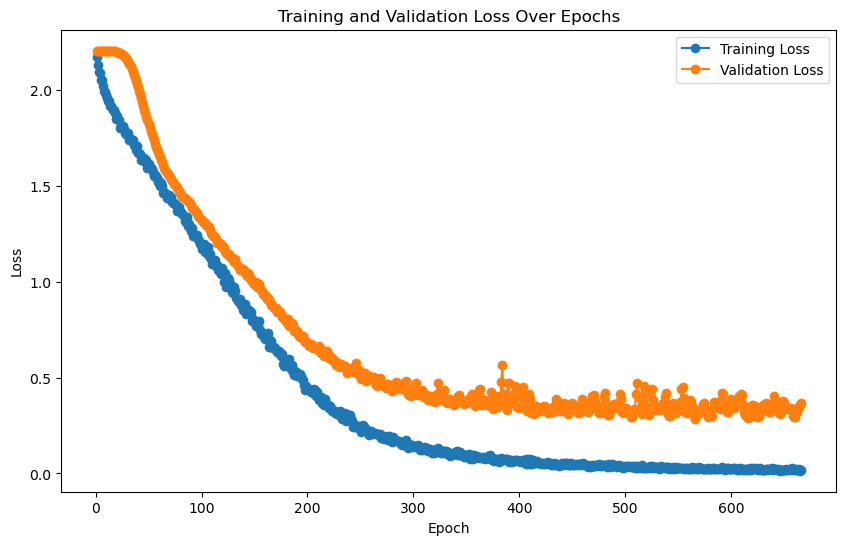

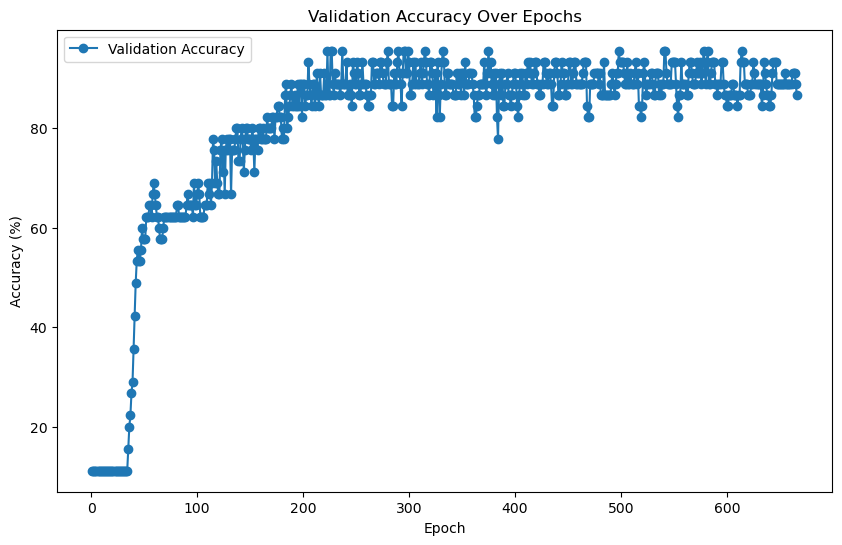


Evaluating on the test set...
    Test Batch [1/167], Loss: 0.9882



Final Test Loss: 0.3678, Test Accuracy: 88.04%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/167 for test dataset.
  Processed batch 20/167 for test dataset.
  Processed batch 30/167 for test dataset.
  Processed batch 40/167 for test dataset.


  Processed batch 50/167 for test dataset.
  Processed batch 60/167 for test dataset.
  Processed batch 70/167 for test dataset.
  Processed batch 80/167 for test dataset.
  Processed batch 90/167 for test dataset.


  Processed batch 100/167 for test dataset.
  Processed batch 110/167 for test dataset.
  Processed batch 120/167 for test dataset.
  Processed batch 130/167 for test dataset.
  Processed batch 140/167 for test dataset.


  Processed batch 150/167 for test dataset.
  Processed batch 160/167 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 42551 samples with 64 features each
LOG: Labels shape: (42551,)

LOG: Training features shape: (180, 64), Training labels shape: (180,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (42551, 64), Test labels shape: (42551,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 68.89%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.40      0.40         5
           1       0.67      0.80      0.73         5
           2       0.50      0.40      0.44         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       0.75      0.60      0.67         5
           6       0.50      0.80      0.62         5
           7       0.60      0.60      0.60         5
           8       1.00      0.

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42551 samples with 64 features each
LOG: Labels shape: (42551,)
Train reps shape: (180, 64)
Train labels shape: (180,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (42551, 64)
Test labels shape: (42551,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.3117  |  Val Loss: 2.1933
Validation loss improved from inf to 2.1933.
[Epoch 2/1000] Train Loss: 2.1033  |  Val Loss: 2.0906
Validation loss improved from 2.1933 to 2.0906.
[Epoch 3/1000] Train Loss: 2.0060  |  Val Loss: 2.0245
Validation loss improved from 2.0906 to 2.0245.
[Epoch 4/1000] Train Loss: 1.9300  |  Val Loss: 1.9701
Validation loss improved from 2.0245 to 1.9701.
[Epoch 5/1000] Train Loss: 1.8656  |  Val Loss: 1.9201
Validation loss improved from 1.9701 to 1.9201.
[Epoch 6/1000] Train Loss: 1.8084  |  Val Loss: 1.8695
Validation loss improved from 1.9201 to 1.8695.


[Epoch 7/1000] Train Loss: 1.7565  |  Val Loss: 1.8224
Validation loss improved from 1.8695 to 1.8224.
[Epoch 8/1000] Train Loss: 1.7069  |  Val Loss: 1.7814
Validation loss improved from 1.8224 to 1.7814.
[Epoch 9/1000] Train Loss: 1.6554  |  Val Loss: 1.7358
Validation loss improved from 1.7814 to 1.7358.
[Epoch 10/1000] Train Loss: 1.6086  |  Val Loss: 1.6947
Validation loss improved from 1.7358 to 1.6947.
[Epoch 11/1000] Train Loss: 1.5568  |  Val Loss: 1.6477
Validation loss improved from 1.6947 to 1.6477.
[Epoch 12/1000] Train Loss: 1.5088  |  Val Loss: 1.6050
Validation loss improved from 1.6477 to 1.6050.
[Epoch 13/1000] Train Loss: 1.4554  |  Val Loss: 1.5611
Validation loss improved from 1.6050 to 1.5611.
[Epoch 14/1000] Train Loss: 1.4043  |  Val Loss: 1.5126
Validation loss improved from 1.5611 to 1.5126.
[Epoch 15/1000] Train Loss: 1.3574  |  Val Loss: 1.4624
Validation loss improved from 1.5126 to 1.4624.
[Epoch 16/1000] Train Loss: 1.3055  |  Val Loss: 1.4101
Validation 

[Epoch 23/1000] Train Loss: 0.9939  |  Val Loss: 1.1006
Validation loss improved from 1.1432 to 1.1006.
[Epoch 24/1000] Train Loss: 0.9541  |  Val Loss: 1.0592
Validation loss improved from 1.1006 to 1.0592.
[Epoch 25/1000] Train Loss: 0.9179  |  Val Loss: 1.0277
Validation loss improved from 1.0592 to 1.0277.
[Epoch 26/1000] Train Loss: 0.8837  |  Val Loss: 1.0126
Validation loss improved from 1.0277 to 1.0126.
[Epoch 27/1000] Train Loss: 0.8520  |  Val Loss: 0.9791
Validation loss improved from 1.0126 to 0.9791.
[Epoch 28/1000] Train Loss: 0.8203  |  Val Loss: 0.9535
Validation loss improved from 0.9791 to 0.9535.
[Epoch 29/1000] Train Loss: 0.7923  |  Val Loss: 0.9251
Validation loss improved from 0.9535 to 0.9251.
[Epoch 30/1000] Train Loss: 0.7676  |  Val Loss: 0.9003
Validation loss improved from 0.9251 to 0.9003.
[Epoch 31/1000] Train Loss: 0.7450  |  Val Loss: 0.8835
Validation loss improved from 0.9003 to 0.8835.
[Epoch 32/1000] Train Loss: 0.7146  |  Val Loss: 0.8588
Validati

[Epoch 34/1000] Train Loss: 0.6750  |  Val Loss: 0.8403
Validation loss improved from 0.8470 to 0.8403.
[Epoch 35/1000] Train Loss: 0.6580  |  Val Loss: 0.8302
Validation loss improved from 0.8403 to 0.8302.
[Epoch 36/1000] Train Loss: 0.6312  |  Val Loss: 0.8078
Validation loss improved from 0.8302 to 0.8078.
[Epoch 37/1000] Train Loss: 0.6201  |  Val Loss: 0.7940
Validation loss improved from 0.8078 to 0.7940.
[Epoch 38/1000] Train Loss: 0.6026  |  Val Loss: 0.7690
Validation loss improved from 0.7940 to 0.7690.
[Epoch 39/1000] Train Loss: 0.5834  |  Val Loss: 0.7695
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 40/1000] Train Loss: 0.5799  |  Val Loss: 0.7487
Validation loss improved from 0.7690 to 0.7487.


[Epoch 41/1000] Train Loss: 0.5540  |  Val Loss: 0.7380
Validation loss improved from 0.7487 to 0.7380.
[Epoch 42/1000] Train Loss: 0.5437  |  Val Loss: 0.7363
Validation loss improved from 0.7380 to 0.7363.
[Epoch 43/1000] Train Loss: 0.5295  |  Val Loss: 0.7224
Validation loss improved from 0.7363 to 0.7224.
[Epoch 44/1000] Train Loss: 0.5186  |  Val Loss: 0.7158
Validation loss improved from 0.7224 to 0.7158.
[Epoch 45/1000] Train Loss: 0.5086  |  Val Loss: 0.7036
Validation loss improved from 0.7158 to 0.7036.
[Epoch 46/1000] Train Loss: 0.4972  |  Val Loss: 0.6766
Validation loss improved from 0.7036 to 0.6766.
[Epoch 47/1000] Train Loss: 0.4844  |  Val Loss: 0.6528
Validation loss improved from 0.6766 to 0.6528.
[Epoch 48/1000] Train Loss: 0.4756  |  Val Loss: 0.6610
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 49/1000] Train Loss: 0.4643  |  Val Loss: 0.6715
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 50/1000] Train Loss: 0.4615  |  Val Loss: 0.6

[Epoch 55/1000] Train Loss: 0.4227  |  Val Loss: 0.6325
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 56/1000] Train Loss: 0.4120  |  Val Loss: 0.6059
Validation loss improved from 0.6169 to 0.6059.
[Epoch 57/1000] Train Loss: 0.4050  |  Val Loss: 0.5950
Validation loss improved from 0.6059 to 0.5950.
[Epoch 58/1000] Train Loss: 0.4054  |  Val Loss: 0.6050
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 59/1000] Train Loss: 0.3933  |  Val Loss: 0.6270
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 60/1000] Train Loss: 0.3879  |  Val Loss: 0.6247
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 61/1000] Train Loss: 0.3842  |  Val Loss: 0.5990
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 62/1000] Train Loss: 0.3762  |  Val Loss: 0.5734
Validation loss improved from 0.5950 to 0.5734.
[Epoch 63/1000] Train Loss: 0.3749  |  Val Loss: 0.5636
Validation loss improved from 0.5734 to 0.5636.
[Epoch 64/1000] Train Loss: 0.3738

[Epoch 67/1000] Train Loss: 0.3485  |  Val Loss: 0.5728
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 68/1000] Train Loss: 0.3486  |  Val Loss: 0.5790
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 69/1000] Train Loss: 0.3406  |  Val Loss: 0.5666
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 70/1000] Train Loss: 0.3417  |  Val Loss: 0.5427
Validation loss improved from 0.5636 to 0.5427.
[Epoch 71/1000] Train Loss: 0.3302  |  Val Loss: 0.5452
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 72/1000] Train Loss: 0.3437  |  Val Loss: 0.5775
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 73/1000] Train Loss: 0.3280  |  Val Loss: 0.5668
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 74/1000] Train Loss: 0.3349  |  Val Loss: 0.5305
Validation loss improved from 0.5427 to 0.5305.
[Epoch 75/1000] Train Loss: 0.3183  |  Val Loss: 0.5563
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 76/1000] Train Loss: 0.3361  |  Val Loss: 0.5407
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 77/1000] Train Loss: 0.3108  |  Val Loss: 0.5287
Validation loss improved from 0.5305 to 0.5287.
[Epoch 78/1000] Train Loss: 0.3155  |  Val Loss: 0.5325
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 79/1000] Train Loss: 0.3062  |  Val Loss: 0.5516
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 80/1000] Train Loss: 0.3029  |  Val Loss: 0.5273
Validation loss improved from 0.5287 to 0.5273.
[Epoch 81/1000] Train Loss: 0.2994  |  Val Loss: 0.5195
Validation loss improved from 0.5273 to 0.5195.
[Epoch 82/1000] Train Loss: 0.2963  |  Val Loss: 0.5269
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 83/1000] Train Loss: 0.2899

[Epoch 86/1000] Train Loss: 0.2854  |  Val Loss: 0.5263
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 87/1000] Train Loss: 0.2912  |  Val Loss: 0.5118
Validation loss improved from 0.5195 to 0.5118.
[Epoch 88/1000] Train Loss: 0.2766  |  Val Loss: 0.5275
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 89/1000] Train Loss: 0.2846  |  Val Loss: 0.5456
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 90/1000] Train Loss: 0.2730  |  Val Loss: 0.5374
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 91/1000] Train Loss: 0.2712  |  Val Loss: 0.5151
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 92/1000] Train Loss: 0.2655  |  Val Loss: 0.5084
Validation loss improved from 0.5118 to 0.5084.
[Epoch 93/1000] Train Loss: 0.2684  |  Val Loss: 0.5209
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 94/1000] Train Loss: 0.2599  |  Val Loss: 0.5334
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 95/1000] Train 

[Epoch 96/1000] Train Loss: 0.2723  |  Val Loss: 0.5070
Validation loss improved from 0.5080 to 0.5070.
[Epoch 97/1000] Train Loss: 0.2563  |  Val Loss: 0.5100
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 98/1000] Train Loss: 0.2600  |  Val Loss: 0.5186
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 99/1000] Train Loss: 0.2493  |  Val Loss: 0.5178
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 100/1000] Train Loss: 0.2563  |  Val Loss: 0.4990
Validation loss improved from 0.5070 to 0.4990.
[Epoch 101/1000] Train Loss: 0.2557  |  Val Loss: 0.5027
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 102/1000] Train Loss: 0.2547  |  Val Loss: 0.5145
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 103/1000] Train Loss: 0.2445  |  Val Loss: 0.5196
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 104/1000] Train Loss: 0.2423  |  Val Loss: 0.5181
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 105/1000] Train Loss: 0.2379  |  Val Loss: 0.5128
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 106/1000] Train Loss: 0.2413  |  Val Loss: 0.5060
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 107/1000] Train Loss: 0.2345  |  Val Loss: 0.5080
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 108/1000] Train Loss: 0.2331  |  Val Loss: 0.4954
Validation loss improved from 0.4990 to 0.4954.
[Epoch 109/1000] Train Loss: 0.2302  |  Val Loss: 0.4981
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 110/1000] Train Loss: 0.2287  |  Val Loss: 0.5182
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 111/1000] Train Loss: 0.2257  |  Val Loss: 0.5235
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 112/1000] Train Loss: 0.2287  |  Val Loss: 0.5009
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 

[Epoch 118/1000] Train Loss: 0.2191  |  Val Loss: 0.4910
Validation loss improved from 0.4954 to 0.4910.
[Epoch 119/1000] Train Loss: 0.2135  |  Val Loss: 0.5113
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 120/1000] Train Loss: 0.2185  |  Val Loss: 0.5114
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 121/1000] Train Loss: 0.2103  |  Val Loss: 0.5046
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 122/1000] Train Loss: 0.2163  |  Val Loss: 0.5099
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 123/1000] Train Loss: 0.2129  |  Val Loss: 0.5266
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 124/1000] Train Loss: 0.2142  |  Val Loss: 0.4918
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 125/1000] Train Loss: 0.2087  |  Val Loss: 0.4951
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 126/1000] Train Loss: 0.2065  |  Val Loss: 0.5082
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 129/1000] Train Loss: 0.2014  |  Val Loss: 0.5083
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 130/1000] Train Loss: 0.2009  |  Val Loss: 0.4956
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 131/1000] Train Loss: 0.1981  |  Val Loss: 0.5167
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 132/1000] Train Loss: 0.2011  |  Val Loss: 0.5304
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 133/1000] Train Loss: 0.1996  |  Val Loss: 0.5219
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 134/1000] Train Loss: 0.1990  |  Val Loss: 0.5166
!! Validation loss did NOT improve !! Patience: 16/100


[Epoch 135/1000] Train Loss: 0.1942  |  Val Loss: 0.5331
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 136/1000] Train Loss: 0.1987  |  Val Loss: 0.5044
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 137/1000] Train Loss: 0.1934  |  Val Loss: 0.4966
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 138/1000] Train Loss: 0.1906  |  Val Loss: 0.5205
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 139/1000] Train Loss: 0.2192  |  Val Loss: 0.5495
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 140/1000] Train Loss: 0.1918  |  Val Loss: 0.5396
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 141/1000] Train Loss: 0.1992  |  Val Loss: 0.4986
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 142/1000] Train Loss: 0.1984  |  Val Loss: 0.5179
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 143/1000] Train Loss: 0.1898  |  Val Loss: 0.5143
!! Validation loss did NOT improve !! Patience:

[Epoch 150/1000] Train Loss: 0.1756  |  Val Loss: 0.5267
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 151/1000] Train Loss: 0.1763  |  Val Loss: 0.5334
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 152/1000] Train Loss: 0.1753  |  Val Loss: 0.5220
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 153/1000] Train Loss: 0.1770  |  Val Loss: 0.5080
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 154/1000] Train Loss: 0.1714  |  Val Loss: 0.5366
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 155/1000] Train Loss: 0.1715  |  Val Loss: 0.5502
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 156/1000] Train Loss: 0.1776  |  Val Loss: 0.5346
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 157/1000] Train Loss: 0.1679  |  Val Loss: 0.5159
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 158/1000] Train Loss: 0.1691  |  Val Loss: 0.5158
!! Validation loss did NOT improve !! Patience:

[Epoch 165/1000] Train Loss: 0.1586  |  Val Loss: 0.5384
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 166/1000] Train Loss: 0.1589  |  Val Loss: 0.5298
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 167/1000] Train Loss: 0.1636  |  Val Loss: 0.5245
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 168/1000] Train Loss: 0.1560  |  Val Loss: 0.5298
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 169/1000] Train Loss: 0.1613  |  Val Loss: 0.5386
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 170/1000] Train Loss: 0.1556  |  Val Loss: 0.5293
!! Validation loss did NOT improve !! Patience: 52/100


[Epoch 171/1000] Train Loss: 0.1583  |  Val Loss: 0.5407
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 172/1000] Train Loss: 0.1536  |  Val Loss: 0.5435
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 173/1000] Train Loss: 0.1516  |  Val Loss: 0.5461
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 174/1000] Train Loss: 0.1502  |  Val Loss: 0.5516
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 175/1000] Train Loss: 0.1516  |  Val Loss: 0.5487
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 176/1000] Train Loss: 0.1497  |  Val Loss: 0.5231
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 177/1000] Train Loss: 0.1507  |  Val Loss: 0.5419
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 178/1000] Train Loss: 0.1475  |  Val Loss: 0.5818
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 179/1000] Train Loss: 0.1531  |  Val Loss: 0.5694
!! Validation loss did NOT improve !! Patience:

[Epoch 184/1000] Train Loss: 0.1390  |  Val Loss: 0.5539
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 185/1000] Train Loss: 0.1481  |  Val Loss: 0.5502
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 186/1000] Train Loss: 0.1436  |  Val Loss: 0.5754
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 187/1000] Train Loss: 0.1419  |  Val Loss: 0.5966
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 188/1000] Train Loss: 0.1428  |  Val Loss: 0.5729
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 189/1000] Train Loss: 0.1367  |  Val Loss: 0.5722
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 190/1000] Train Loss: 0.1370  |  Val Loss: 0.5700
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 191/1000] Train Loss: 0.1381  |  Val Loss: 0.5621
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 192/1000] Train Loss: 0.1459  |  Val Loss: 0.5823
!! Validation loss did NOT improve !! Patience:

[Epoch 197/1000] Train Loss: 0.1329  |  Val Loss: 0.5713
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 198/1000] Train Loss: 0.1318  |  Val Loss: 0.5780
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 199/1000] Train Loss: 0.1280  |  Val Loss: 0.5896
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 200/1000] Train Loss: 0.1283  |  Val Loss: 0.5879
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 201/1000] Train Loss: 0.1262  |  Val Loss: 0.5927
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 202/1000] Train Loss: 0.1235  |  Val Loss: 0.5828
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 203/1000] Train Loss: 0.1246  |  Val Loss: 0.5844
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 204/1000] Train Loss: 0.1261  |  Val Loss: 0.5784
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 205/1000] Train Loss: 0.1227  |  Val Loss: 0.6102
!! Validation loss did NOT improve !! Patience:

[Epoch 217/1000] Train Loss: 0.1134  |  Val Loss: 0.6414
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 218/1000] Train Loss: 0.1152  |  Val Loss: 0.6021
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 218 !!
No improvement for 100 epochs.


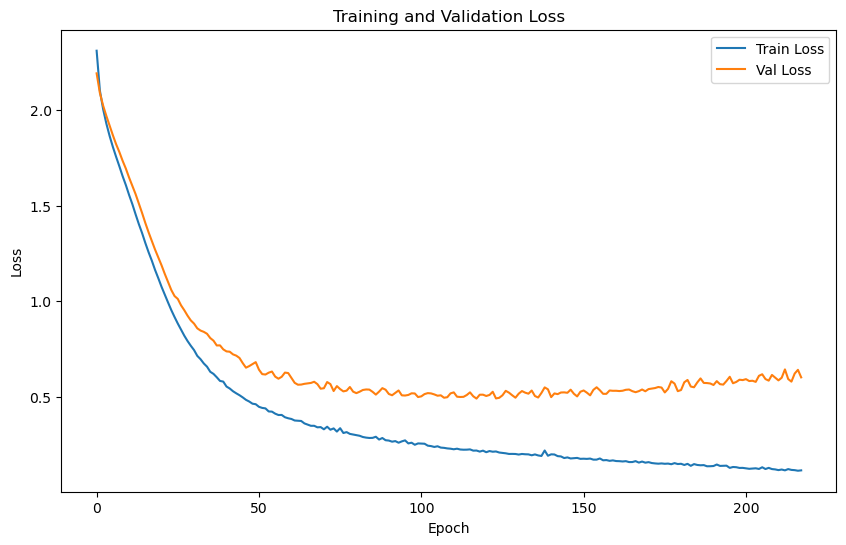

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.2754 | Test Accuracy: 69.21%


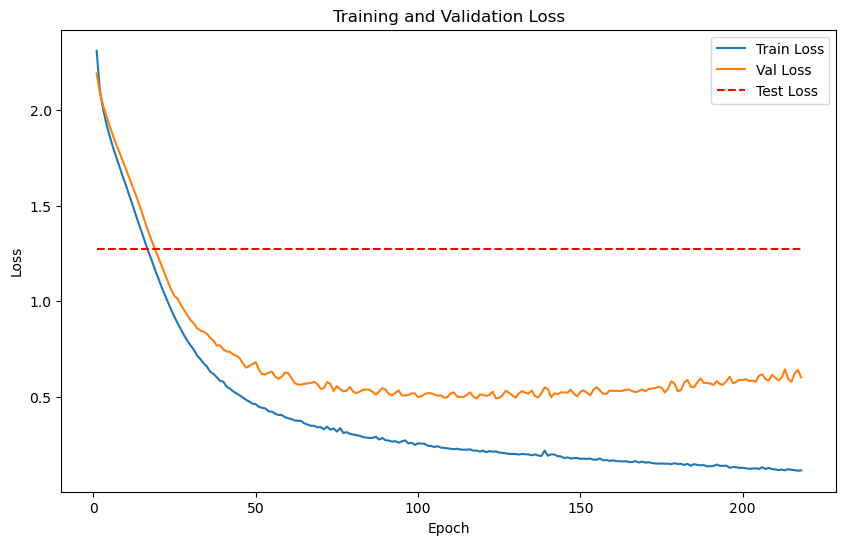

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42551 samples with 64 features each
LOG: Labels shape: (42551,)


Train embeddings shape: (180, 64), 
Train labels shape: (180,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42551, 64), 
Test labels shape: (42551,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 9.1045
Epoch [1/2000], Avg Train Loss: 9.1045
Epoch [1/2000], Avg Val Loss: 4.6063
Validation loss improved from inf to 4.6063. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.9648
Epoch [2/2000], Avg Train Loss: 8.9648
Epoch [2/2000], Avg Val Loss: 4.5549
Validation loss improved from 4.6063 to 4.5549. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 9.0567
Epoch [3/2000], Avg Train Loss: 9.0567
Epoch [3/2000], Avg Val Loss: 4.5049
Validation loss improved from 4.5549 to 4.5049. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.7710
Epoch [4/2000], Avg Train Loss: 8.7710
Epoch [4/2000], Avg Val Loss: 4.4557
Validation loss improved from 4.5049 to 4.4557. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.8429
Epoch [5/2000], Avg Train Loss: 8.8429
Epoch [5/2000], Avg Val Loss: 4.4078
Validation loss improved from 4.4557 to 4.4078. Saving mode

    Batch [1/1], Train Loss: 8.1639
Epoch [13/2000], Avg Train Loss: 8.1639
Epoch [13/2000], Avg Val Loss: 4.0655
Validation loss improved from 4.1045 to 4.0655. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 8.1009
Epoch [14/2000], Avg Train Loss: 8.1009
Epoch [14/2000], Avg Val Loss: 4.0275
Validation loss improved from 4.0655 to 4.0275. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 8.0337
Epoch [15/2000], Avg Train Loss: 8.0337
Epoch [15/2000], Avg Val Loss: 3.9905
Validation loss improved from 4.0275 to 3.9905. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 8.0683
Epoch [16/2000], Avg Train Loss: 8.0683
Epoch [16/2000], Avg Val Loss: 3.9546
Validation loss improved from 3.9905 to 3.9546. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 7.8972
Epoch [17/2000], Avg Train Loss: 7.8972
Epoch [17/2000], Avg Val Loss: 3.9197
Validation loss improved from 3.9546 to 3.

    Batch [1/1], Train Loss: 7.3181
Epoch [26/2000], Avg Train Loss: 7.3181
Epoch [26/2000], Avg Val Loss: 3.6456
Validation loss improved from 3.6725 to 3.6456. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 6.9935
Epoch [27/2000], Avg Train Loss: 6.9935
Epoch [27/2000], Avg Val Loss: 3.6195
Validation loss improved from 3.6456 to 3.6195. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 7.1046
Epoch [28/2000], Avg Train Loss: 7.1046
Epoch [28/2000], Avg Val Loss: 3.5944
Validation loss improved from 3.6195 to 3.5944. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 7.1966
Epoch [29/2000], Avg Train Loss: 7.1966
Epoch [29/2000], Avg Val Loss: 3.5699
Validation loss improved from 3.5944 to 3.5699. Saving model...

LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 7.0730
Epoch [30/2000], Avg Train Loss: 7.0730
Epoch [30/2000], Avg Val Loss: 3.5460
Validation loss improved from 3.5699 to 3.

Epoch [46/2000], Avg Val Loss: 3.2519
Validation loss improved from 3.2661 to 3.2519. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 6.2742
Epoch [47/2000], Avg Train Loss: 6.2742
Epoch [47/2000], Avg Val Loss: 3.2381
Validation loss improved from 3.2519 to 3.2381. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 6.0560
Epoch [48/2000], Avg Train Loss: 6.0560
Epoch [48/2000], Avg Val Loss: 3.2247
Validation loss improved from 3.2381 to 3.2247. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 6.2912
Epoch [49/2000], Avg Train Loss: 6.2912
Epoch [49/2000], Avg Val Loss: 3.2118
Validation loss improved from 3.2247 to 3.2118. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 6.2515
Epoch [50/2000], Avg Train Loss: 6.2515
Epoch [50/2000], Avg Val Loss: 3.1994
Validation loss improved from 3.2118 to 3.1994. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.8089
Epoch [60/2000], Avg Train Loss: 5.8089
Epoch [60/2000], Avg Val Loss: 3.0958
Validation loss improved from 3.1047 to 3.0958. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 5.7196
Epoch [61/2000], Avg Train Loss: 5.7196
Epoch [61/2000], Avg Val Loss: 3.0872
Validation loss improved from 3.0958 to 3.0872. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 5.7418
Epoch [62/2000], Avg Train Loss: 5.7418
Epoch [62/2000], Avg Val Loss: 3.0789
Validation loss improved from 3.0872 to 3.0789. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 5.7698
Epoch [63/2000], Avg Train Loss: 5.7698
Epoch [63/2000], Avg Val Loss: 3.0709
Validation loss improved from 3.0789 to 3.0709. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 5.7049
Epoch [64/2000], Avg Train Loss: 5.7049
Epoch [64/2000], Avg Val Loss: 3.0632
Validation loss improved from 3.0709 to 3.

    Batch [1/1], Train Loss: 5.4367
Epoch [71/2000], Avg Train Loss: 5.4367
Epoch [71/2000], Avg Val Loss: 3.0159
Validation loss improved from 3.0220 to 3.0159. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 5.3814
Epoch [72/2000], Avg Train Loss: 5.3814
Epoch [72/2000], Avg Val Loss: 3.0100
Validation loss improved from 3.0159 to 3.0100. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 5.4287
Epoch [73/2000], Avg Train Loss: 5.4287
Epoch [73/2000], Avg Val Loss: 3.0043
Validation loss improved from 3.0100 to 3.0043. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 5.3140
Epoch [74/2000], Avg Train Loss: 5.3140
Epoch [74/2000], Avg Val Loss: 2.9988
Validation loss improved from 3.0043 to 2.9988. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 5.4634
Epoch [75/2000], Avg Train Loss: 5.4634
Epoch [75/2000], Avg Val Loss: 2.9935
Validation loss improved from 2.9988 to 2.

Epoch [90/2000], Avg Val Loss: 2.9296
Validation loss improved from 2.9330 to 2.9296. Saving model...

LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 5.1111
Epoch [91/2000], Avg Train Loss: 5.1111
Epoch [91/2000], Avg Val Loss: 2.9262
Validation loss improved from 2.9296 to 2.9262. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 5.1447
Epoch [92/2000], Avg Train Loss: 5.1447
Epoch [92/2000], Avg Val Loss: 2.9229
Validation loss improved from 2.9262 to 2.9229. Saving model...

LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 5.1100
Epoch [93/2000], Avg Train Loss: 5.1100
Epoch [93/2000], Avg Val Loss: 2.9197
Validation loss improved from 2.9229 to 2.9197. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 5.0734
Epoch [94/2000], Avg Train Loss: 5.0734
Epoch [94/2000], Avg Val Loss: 2.9165
Validation loss improved from 2.9197 to 2.9165. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 4.9623
Epoch [102/2000], Avg Train Loss: 4.9623
Epoch [102/2000], Avg Val Loss: 2.8934
Validation loss improved from 2.8961 to 2.8934. Saving model...

LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 4.9815
Epoch [103/2000], Avg Train Loss: 4.9815
Epoch [103/2000], Avg Val Loss: 2.8907
Validation loss improved from 2.8934 to 2.8907. Saving model...

LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 4.9438
Epoch [104/2000], Avg Train Loss: 4.9438
Epoch [104/2000], Avg Val Loss: 2.8881
Validation loss improved from 2.8907 to 2.8881. Saving model...

LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 4.8554
Epoch [105/2000], Avg Train Loss: 4.8554
Epoch [105/2000], Avg Val Loss: 2.8855
Validation loss improved from 2.8881 to 2.8855. Saving model...

LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 4.9309
Epoch [106/2000], Avg Train Loss: 4.9309
Epoch [106/2000], Avg Val Loss: 2.8831
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8851
Epoch [113/2000], Avg Train Loss: 4.8851
Epoch [113/2000], Avg Val Loss: 2.8672
Validation loss improved from 2.8694 to 2.8672. Saving model...

LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 4.8844
Epoch [114/2000], Avg Train Loss: 4.8844
Epoch [114/2000], Avg Val Loss: 2.8651
Validation loss improved from 2.8672 to 2.8651. Saving model...

LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 4.8597
Epoch [115/2000], Avg Train Loss: 4.8597
Epoch [115/2000], Avg Val Loss: 2.8630
Validation loss improved from 2.8651 to 2.8630. Saving model...

LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 4.8512
Epoch [116/2000], Avg Train Loss: 4.8512
Epoch [116/2000], Avg Val Loss: 2.8609
Validation loss improved from 2.8630 to 2.8609. Saving model...

LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 4.8735
Epoch [117/2000], Avg Train Loss: 4.8735
Epoch [117/2000], Avg Val Loss: 2.8588
Validation loss improved fro

Epoch [134/2000], Avg Val Loss: 2.8254
Validation loss improved from 2.8273 to 2.8254. Saving model...

LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 4.7270
Epoch [135/2000], Avg Train Loss: 4.7270
Epoch [135/2000], Avg Val Loss: 2.8235
Validation loss improved from 2.8254 to 2.8235. Saving model...

LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 4.6581
Epoch [136/2000], Avg Train Loss: 4.6581
Epoch [136/2000], Avg Val Loss: 2.8216
Validation loss improved from 2.8235 to 2.8216. Saving model...

LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 4.7021
Epoch [137/2000], Avg Train Loss: 4.7021
Epoch [137/2000], Avg Val Loss: 2.8198
Validation loss improved from 2.8216 to 2.8198. Saving model...

LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 4.8226
Epoch [138/2000], Avg Train Loss: 4.8226
Epoch [138/2000], Avg Val Loss: 2.8179
Validation loss improved from 2.8198 to 2.8179. Saving model...

LOG: Epoch [139/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.6518
Epoch [144/2000], Avg Train Loss: 4.6518
Epoch [144/2000], Avg Val Loss: 2.8069
Validation loss improved from 2.8087 to 2.8069. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 4.6247
Epoch [145/2000], Avg Train Loss: 4.6247
Epoch [145/2000], Avg Val Loss: 2.8051
Validation loss improved from 2.8069 to 2.8051. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 4.6143
Epoch [146/2000], Avg Train Loss: 4.6143
Epoch [146/2000], Avg Val Loss: 2.8032
Validation loss improved from 2.8051 to 2.8032. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 4.6801
Epoch [147/2000], Avg Train Loss: 4.6801
Epoch [147/2000], Avg Val Loss: 2.8014
Validation loss improved from 2.8032 to 2.8014. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 4.6392
Epoch [148/2000], Avg Train Loss: 4.6392
Epoch [148/2000], Avg Val Loss: 2.7996
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5745
Epoch [153/2000], Avg Train Loss: 4.5745
Epoch [153/2000], Avg Val Loss: 2.7905
Validation loss improved from 2.7923 to 2.7905. Saving model...

LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 4.6400
Epoch [154/2000], Avg Train Loss: 4.6400
Epoch [154/2000], Avg Val Loss: 2.7886
Validation loss improved from 2.7905 to 2.7886. Saving model...

LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 4.6196
Epoch [155/2000], Avg Train Loss: 4.6196
Epoch [155/2000], Avg Val Loss: 2.7868
Validation loss improved from 2.7886 to 2.7868. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 4.6737
Epoch [156/2000], Avg Train Loss: 4.6737
Epoch [156/2000], Avg Val Loss: 2.7849
Validation loss improved from 2.7868 to 2.7849. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 4.6238
Epoch [157/2000], Avg Train Loss: 4.6238
Epoch [157/2000], Avg Val Loss: 2.7831
Validation loss improved fro

Epoch [176/2000], Avg Val Loss: 2.7490
Validation loss improved from 2.7507 to 2.7490. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 4.5373
Epoch [177/2000], Avg Train Loss: 4.5373
Epoch [177/2000], Avg Val Loss: 2.7473
Validation loss improved from 2.7490 to 2.7473. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 4.5583
Epoch [178/2000], Avg Train Loss: 4.5583
Epoch [178/2000], Avg Val Loss: 2.7456
Validation loss improved from 2.7473 to 2.7456. Saving model...

LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 4.5528
Epoch [179/2000], Avg Train Loss: 4.5528
Epoch [179/2000], Avg Val Loss: 2.7439
Validation loss improved from 2.7456 to 2.7439. Saving model...

LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 4.5239
Epoch [180/2000], Avg Train Loss: 4.5239
Epoch [180/2000], Avg Val Loss: 2.7422
Validation loss improved from 2.7439 to 2.7422. Saving model...

LOG: Epoch [181/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.5063
Epoch [188/2000], Avg Train Loss: 4.5063
Epoch [188/2000], Avg Val Loss: 2.7286
Validation loss improved from 2.7303 to 2.7286. Saving model...

LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 4.5263
Epoch [189/2000], Avg Train Loss: 4.5263
Epoch [189/2000], Avg Val Loss: 2.7270
Validation loss improved from 2.7286 to 2.7270. Saving model...

LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 4.5213
Epoch [190/2000], Avg Train Loss: 4.5213
Epoch [190/2000], Avg Val Loss: 2.7253
Validation loss improved from 2.7270 to 2.7253. Saving model...

LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 4.5109
Epoch [191/2000], Avg Train Loss: 4.5109
Epoch [191/2000], Avg Val Loss: 2.7237
Validation loss improved from 2.7253 to 2.7237. Saving model...

LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 4.5349
Epoch [192/2000], Avg Train Loss: 4.5349
Epoch [192/2000], Avg Val Loss: 2.7221
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3985
Epoch [219/2000], Avg Train Loss: 4.3985
Epoch [219/2000], Avg Val Loss: 2.6791
Validation loss improved from 2.6807 to 2.6791. Saving model...

LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 4.3872
Epoch [220/2000], Avg Train Loss: 4.3872
Epoch [220/2000], Avg Val Loss: 2.6776
Validation loss improved from 2.6791 to 2.6776. Saving model...

LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 4.4476
Epoch [221/2000], Avg Train Loss: 4.4476
Epoch [221/2000], Avg Val Loss: 2.6761
Validation loss improved from 2.6776 to 2.6761. Saving model...

LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 4.3713
Epoch [222/2000], Avg Train Loss: 4.3713
Epoch [222/2000], Avg Val Loss: 2.6747
Validation loss improved from 2.6761 to 2.6747. Saving model...

LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 4.3971
Epoch [223/2000], Avg Train Loss: 4.3971
Epoch [223/2000], Avg Val Loss: 2.6732
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3735
Epoch [231/2000], Avg Train Loss: 4.3735
Epoch [231/2000], Avg Val Loss: 2.6621
Validation loss improved from 2.6634 to 2.6621. Saving model...

LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 4.4104
Epoch [232/2000], Avg Train Loss: 4.4104
Epoch [232/2000], Avg Val Loss: 2.6608
Validation loss improved from 2.6621 to 2.6608. Saving model...

LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 4.4004
Epoch [233/2000], Avg Train Loss: 4.4004
Epoch [233/2000], Avg Val Loss: 2.6594
Validation loss improved from 2.6608 to 2.6594. Saving model...

LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 4.3765
Epoch [234/2000], Avg Train Loss: 4.3765
Epoch [234/2000], Avg Val Loss: 2.6581
Validation loss improved from 2.6594 to 2.6581. Saving model...

LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 4.3134
Epoch [235/2000], Avg Train Loss: 4.3134
Epoch [235/2000], Avg Val Loss: 2.6567
Validation loss improved fro

Epoch [258/2000], Avg Val Loss: 2.6263
Validation loss improved from 2.6275 to 2.6263. Saving model...

LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 4.3108
Epoch [259/2000], Avg Train Loss: 4.3108
Epoch [259/2000], Avg Val Loss: 2.6250
Validation loss improved from 2.6263 to 2.6250. Saving model...

LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 4.3625
Epoch [260/2000], Avg Train Loss: 4.3625
Epoch [260/2000], Avg Val Loss: 2.6238
Validation loss improved from 2.6250 to 2.6238. Saving model...

LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 4.2898
Epoch [261/2000], Avg Train Loss: 4.2898
Epoch [261/2000], Avg Val Loss: 2.6225
Validation loss improved from 2.6238 to 2.6225. Saving model...

LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 4.2942
Epoch [262/2000], Avg Train Loss: 4.2942
Epoch [262/2000], Avg Val Loss: 2.6213
Validation loss improved from 2.6225 to 2.6213. Saving model...

LOG: Epoch [263/2000] - Training
    Bat

Epoch [272/2000], Avg Val Loss: 2.6098
Validation loss improved from 2.6108 to 2.6098. Saving model...

LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 4.2526
Epoch [273/2000], Avg Train Loss: 4.2526
Epoch [273/2000], Avg Val Loss: 2.6086
Validation loss improved from 2.6098 to 2.6086. Saving model...

LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 4.3189
Epoch [274/2000], Avg Train Loss: 4.3189
Epoch [274/2000], Avg Val Loss: 2.6075
Validation loss improved from 2.6086 to 2.6075. Saving model...

LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 4.2814
Epoch [275/2000], Avg Train Loss: 4.2814
Epoch [275/2000], Avg Val Loss: 2.6064
Validation loss improved from 2.6075 to 2.6064. Saving model...

LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 4.3403
Epoch [276/2000], Avg Train Loss: 4.3403
Epoch [276/2000], Avg Val Loss: 2.6053
Validation loss improved from 2.6064 to 2.6053. Saving model...

LOG: Epoch [277/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.2254
Epoch [294/2000], Avg Train Loss: 4.2254
Epoch [294/2000], Avg Val Loss: 2.5863
Validation loss improved from 2.5874 to 2.5863. Saving model...

LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 4.2443
Epoch [295/2000], Avg Train Loss: 4.2443
Epoch [295/2000], Avg Val Loss: 2.5852
Validation loss improved from 2.5863 to 2.5852. Saving model...

LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 4.2641
Epoch [296/2000], Avg Train Loss: 4.2641
Epoch [296/2000], Avg Val Loss: 2.5842
Validation loss improved from 2.5852 to 2.5842. Saving model...

LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 4.1662
Epoch [297/2000], Avg Train Loss: 4.1662
Epoch [297/2000], Avg Val Loss: 2.5832
Validation loss improved from 2.5842 to 2.5832. Saving model...

LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 4.1979
Epoch [298/2000], Avg Train Loss: 4.1979
Epoch [298/2000], Avg Val Loss: 2.5821
Validation loss improved fro

Epoch [312/2000], Avg Val Loss: 2.5679
Validation loss improved from 2.5689 to 2.5679. Saving model...

LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 4.2264
Epoch [313/2000], Avg Train Loss: 4.2264
Epoch [313/2000], Avg Val Loss: 2.5669
Validation loss improved from 2.5679 to 2.5669. Saving model...

LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 4.1245
Epoch [314/2000], Avg Train Loss: 4.1245
Epoch [314/2000], Avg Val Loss: 2.5659
Validation loss improved from 2.5669 to 2.5659. Saving model...

LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 4.2282
Epoch [315/2000], Avg Train Loss: 4.2282
Epoch [315/2000], Avg Val Loss: 2.5650
Validation loss improved from 2.5659 to 2.5650. Saving model...

LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 4.1722
Epoch [316/2000], Avg Train Loss: 4.1722
Epoch [316/2000], Avg Val Loss: 2.5640
Validation loss improved from 2.5650 to 2.5640. Saving model...

LOG: Epoch [317/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.2229
Epoch [336/2000], Avg Train Loss: 4.2229
Epoch [336/2000], Avg Val Loss: 2.5455
Validation loss improved from 2.5463 to 2.5455. Saving model...

LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 4.2087
Epoch [337/2000], Avg Train Loss: 4.2087
Epoch [337/2000], Avg Val Loss: 2.5447
Validation loss improved from 2.5455 to 2.5447. Saving model...

LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 4.1722
Epoch [338/2000], Avg Train Loss: 4.1722
Epoch [338/2000], Avg Val Loss: 2.5439
Validation loss improved from 2.5447 to 2.5439. Saving model...

LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 4.1393
Epoch [339/2000], Avg Train Loss: 4.1393
Epoch [339/2000], Avg Val Loss: 2.5431
Validation loss improved from 2.5439 to 2.5431. Saving model...

LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 4.1673
Epoch [340/2000], Avg Train Loss: 4.1673
Epoch [340/2000], Avg Val Loss: 2.5423
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1517
Epoch [355/2000], Avg Train Loss: 4.1517
Epoch [355/2000], Avg Val Loss: 2.5298
Validation loss improved from 2.5305 to 2.5298. Saving model...

LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 4.1462
Epoch [356/2000], Avg Train Loss: 4.1462
Epoch [356/2000], Avg Val Loss: 2.5290
Validation loss improved from 2.5298 to 2.5290. Saving model...

LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 4.1377
Epoch [357/2000], Avg Train Loss: 4.1377
Epoch [357/2000], Avg Val Loss: 2.5282
Validation loss improved from 2.5290 to 2.5282. Saving model...

LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 4.1224
Epoch [358/2000], Avg Train Loss: 4.1224
Epoch [358/2000], Avg Val Loss: 2.5275
Validation loss improved from 2.5282 to 2.5275. Saving model...

LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 4.1009
Epoch [359/2000], Avg Train Loss: 4.1009
Epoch [359/2000], Avg Val Loss: 2.5268
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1045
Epoch [380/2000], Avg Train Loss: 4.1045
Epoch [380/2000], Avg Val Loss: 2.5130
Validation loss improved from 2.5137 to 2.5130. Saving model...

LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 4.1307
Epoch [381/2000], Avg Train Loss: 4.1307
Epoch [381/2000], Avg Val Loss: 2.5123
Validation loss improved from 2.5130 to 2.5123. Saving model...

LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 4.1575
Epoch [382/2000], Avg Train Loss: 4.1575
Epoch [382/2000], Avg Val Loss: 2.5116
Validation loss improved from 2.5123 to 2.5116. Saving model...

LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 4.1239
Epoch [383/2000], Avg Train Loss: 4.1239
Epoch [383/2000], Avg Val Loss: 2.5109
Validation loss improved from 2.5116 to 2.5109. Saving model...

LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 4.0977
Epoch [384/2000], Avg Train Loss: 4.0977
Epoch [384/2000], Avg Val Loss: 2.5102
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1268
Epoch [398/2000], Avg Train Loss: 4.1268
Epoch [398/2000], Avg Val Loss: 2.5009
Validation loss improved from 2.5016 to 2.5009. Saving model...

LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 4.0734
Epoch [399/2000], Avg Train Loss: 4.0734
Epoch [399/2000], Avg Val Loss: 2.5003
Validation loss improved from 2.5009 to 2.5003. Saving model...

LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 4.0695
Epoch [400/2000], Avg Train Loss: 4.0695
Epoch [400/2000], Avg Val Loss: 2.4997
Validation loss improved from 2.5003 to 2.4997. Saving model...

LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 4.0513
Epoch [401/2000], Avg Train Loss: 4.0513
Epoch [401/2000], Avg Val Loss: 2.4991
Validation loss improved from 2.4997 to 2.4991. Saving model...

LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 4.0797
Epoch [402/2000], Avg Train Loss: 4.0797
Epoch [402/2000], Avg Val Loss: 2.4984
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0702
Epoch [427/2000], Avg Train Loss: 4.0702
Epoch [427/2000], Avg Val Loss: 2.4830
Validation loss improved from 2.4836 to 2.4830. Saving model...

LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 4.0369
Epoch [428/2000], Avg Train Loss: 4.0369
Epoch [428/2000], Avg Val Loss: 2.4824
Validation loss improved from 2.4830 to 2.4824. Saving model...

LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 4.0240
Epoch [429/2000], Avg Train Loss: 4.0240
Epoch [429/2000], Avg Val Loss: 2.4817
Validation loss improved from 2.4824 to 2.4817. Saving model...

LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 4.0658
Epoch [430/2000], Avg Train Loss: 4.0658
Epoch [430/2000], Avg Val Loss: 2.4811
Validation loss improved from 2.4817 to 2.4811. Saving model...

LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 4.0029
Epoch [431/2000], Avg Train Loss: 4.0029
Epoch [431/2000], Avg Val Loss: 2.4804
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0601
Epoch [436/2000], Avg Train Loss: 4.0601
Epoch [436/2000], Avg Val Loss: 2.4774
Validation loss improved from 2.4780 to 2.4774. Saving model...

LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 4.0337
Epoch [437/2000], Avg Train Loss: 4.0337
Epoch [437/2000], Avg Val Loss: 2.4768
Validation loss improved from 2.4774 to 2.4768. Saving model...

LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 4.0480
Epoch [438/2000], Avg Train Loss: 4.0480
Epoch [438/2000], Avg Val Loss: 2.4762
Validation loss improved from 2.4768 to 2.4762. Saving model...

LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 4.0376
Epoch [439/2000], Avg Train Loss: 4.0376
Epoch [439/2000], Avg Val Loss: 2.4756
Validation loss improved from 2.4762 to 2.4756. Saving model...

LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 4.0474
Epoch [440/2000], Avg Train Loss: 4.0474
Epoch [440/2000], Avg Val Loss: 2.4750
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0086
Epoch [473/2000], Avg Train Loss: 4.0086


Epoch [473/2000], Avg Val Loss: 2.4605
Validation loss improved from 2.4610 to 2.4605. Saving model...

LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 3.9967
Epoch [474/2000], Avg Train Loss: 3.9967
Epoch [474/2000], Avg Val Loss: 2.4602
Validation loss improved from 2.4605 to 2.4602. Saving model...

LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 4.0202
Epoch [475/2000], Avg Train Loss: 4.0202
Epoch [475/2000], Avg Val Loss: 2.4598
Validation loss improved from 2.4602 to 2.4598. Saving model...

LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 4.0214
Epoch [476/2000], Avg Train Loss: 4.0214
Epoch [476/2000], Avg Val Loss: 2.4594
Validation loss improved from 2.4598 to 2.4594. Saving model...

LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 3.9908
Epoch [477/2000], Avg Train Loss: 3.9908
Epoch [477/2000], Avg Val Loss: 2.4590
Validation loss improved from 2.4594 to 2.4590. Saving model...

LOG: Epoch [478/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9590
Epoch [517/2000], Avg Train Loss: 3.9590
Epoch [517/2000], Avg Val Loss: 2.4411
Validation loss improved from 2.4416 to 2.4411. Saving model...

LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 3.9450
Epoch [518/2000], Avg Train Loss: 3.9450
Epoch [518/2000], Avg Val Loss: 2.4406
Validation loss improved from 2.4411 to 2.4406. Saving model...

LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 3.9543
Epoch [519/2000], Avg Train Loss: 3.9543
Epoch [519/2000], Avg Val Loss: 2.4401
Validation loss improved from 2.4406 to 2.4401. Saving model...

LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 4.0147
Epoch [520/2000], Avg Train Loss: 4.0147
Epoch [520/2000], Avg Val Loss: 2.4397
Validation loss improved from 2.4401 to 2.4397. Saving model...

LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 3.9649
Epoch [521/2000], Avg Train Loss: 3.9649
Epoch [521/2000], Avg Val Loss: 2.4392
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8921
Epoch [561/2000], Avg Train Loss: 3.8921
Epoch [561/2000], Avg Val Loss: 2.4249
Validation loss improved from 2.4253 to 2.4249. Saving model...

LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 3.9414
Epoch [562/2000], Avg Train Loss: 3.9414
Epoch [562/2000], Avg Val Loss: 2.4246
Validation loss improved from 2.4249 to 2.4246. Saving model...

LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 3.9250
Epoch [563/2000], Avg Train Loss: 3.9250
Epoch [563/2000], Avg Val Loss: 2.4243
Validation loss improved from 2.4246 to 2.4243. Saving model...

LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 3.9249
Epoch [564/2000], Avg Train Loss: 3.9249
Epoch [564/2000], Avg Val Loss: 2.4240
Validation loss improved from 2.4243 to 2.4240. Saving model...

LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 3.9390
Epoch [565/2000], Avg Train Loss: 3.9390
Epoch [565/2000], Avg Val Loss: 2.4236
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8936
Epoch [604/2000], Avg Train Loss: 3.8936
Epoch [604/2000], Avg Val Loss: 2.4110
Validation loss improved from 2.4113 to 2.4110. Saving model...

LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 3.8724
Epoch [605/2000], Avg Train Loss: 3.8724
Epoch [605/2000], Avg Val Loss: 2.4107
Validation loss improved from 2.4110 to 2.4107. Saving model...

LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 3.9029
Epoch [606/2000], Avg Train Loss: 3.9029
Epoch [606/2000], Avg Val Loss: 2.4105
Validation loss improved from 2.4107 to 2.4105. Saving model...

LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 3.8884
Epoch [607/2000], Avg Train Loss: 3.8884
Epoch [607/2000], Avg Val Loss: 2.4102
Validation loss improved from 2.4105 to 2.4102. Saving model...

LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 3.8843
Epoch [608/2000], Avg Train Loss: 3.8843
Epoch [608/2000], Avg Val Loss: 2.4100
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8630
Epoch [647/2000], Avg Train Loss: 3.8630
Epoch [647/2000], Avg Val Loss: 2.4020
Validation loss improved from 2.4022 to 2.4020. Saving model...

LOG: Epoch [648/2000] - Training
    Batch [1/1], Train Loss: 3.8547
Epoch [648/2000], Avg Train Loss: 3.8547
Epoch [648/2000], Avg Val Loss: 2.4018
Validation loss improved from 2.4020 to 2.4018. Saving model...

LOG: Epoch [649/2000] - Training
    Batch [1/1], Train Loss: 3.8761
Epoch [649/2000], Avg Train Loss: 3.8761
Epoch [649/2000], Avg Val Loss: 2.4016
Validation loss improved from 2.4018 to 2.4016. Saving model...

LOG: Epoch [650/2000] - Training
    Batch [1/1], Train Loss: 3.8905
Epoch [650/2000], Avg Train Loss: 3.8905
Epoch [650/2000], Avg Val Loss: 2.4014
Validation loss improved from 2.4016 to 2.4014. Saving model...

LOG: Epoch [651/2000] - Training
    Batch [1/1], Train Loss: 3.8264
Epoch [651/2000], Avg Train Loss: 3.8264
Epoch [651/2000], Avg Val Loss: 2.4011
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8615
Epoch [692/2000], Avg Train Loss: 3.8615
Epoch [692/2000], Avg Val Loss: 2.3932
Validation loss improved from 2.3932 to 2.3932. Saving model...

LOG: Epoch [693/2000] - Training
    Batch [1/1], Train Loss: 3.8311
Epoch [693/2000], Avg Train Loss: 3.8311
Epoch [693/2000], Avg Val Loss: 2.3931
Validation loss improved from 2.3932 to 2.3931. Saving model...

LOG: Epoch [694/2000] - Training
    Batch [1/1], Train Loss: 3.8361
Epoch [694/2000], Avg Train Loss: 3.8361
Epoch [694/2000], Avg Val Loss: 2.3931
Validation loss improved from 2.3931 to 2.3931. Saving model...

LOG: Epoch [695/2000] - Training
    Batch [1/1], Train Loss: 3.8310
Epoch [695/2000], Avg Train Loss: 3.8310
Epoch [695/2000], Avg Val Loss: 2.3930
Validation loss improved from 2.3931 to 2.3930. Saving model...

LOG: Epoch [696/2000] - Training
    Batch [1/1], Train Loss: 3.8320
Epoch [696/2000], Avg Train Loss: 3.8320
Epoch [696/2000], Avg Val Loss: 2.3928
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8383
Epoch [735/2000], Avg Train Loss: 3.8383
Epoch [735/2000], Avg Val Loss: 2.3840
Validation loss improved from 2.3842 to 2.3840. Saving model...

LOG: Epoch [736/2000] - Training
    Batch [1/1], Train Loss: 3.8121
Epoch [736/2000], Avg Train Loss: 3.8121
Epoch [736/2000], Avg Val Loss: 2.3838
Validation loss improved from 2.3840 to 2.3838. Saving model...

LOG: Epoch [737/2000] - Training
    Batch [1/1], Train Loss: 3.8233
Epoch [737/2000], Avg Train Loss: 3.8233
Epoch [737/2000], Avg Val Loss: 2.3837
Validation loss improved from 2.3838 to 2.3837. Saving model...

LOG: Epoch [738/2000] - Training
    Batch [1/1], Train Loss: 3.8474
Epoch [738/2000], Avg Train Loss: 3.8474
Epoch [738/2000], Avg Val Loss: 2.3835
Validation loss improved from 2.3837 to 2.3835. Saving model...

LOG: Epoch [739/2000] - Training
    Batch [1/1], Train Loss: 3.8656
Epoch [739/2000], Avg Train Loss: 3.8656
Epoch [739/2000], Avg Val Loss: 2.3834
Validation loss improved fro

Epoch [775/2000], Avg Val Loss: 2.3789
Validation loss improved from 2.3790 to 2.3789. Saving model...

LOG: Epoch [776/2000] - Training
    Batch [1/1], Train Loss: 3.8038
Epoch [776/2000], Avg Train Loss: 3.8038
Epoch [776/2000], Avg Val Loss: 2.3789
Validation loss improved from 2.3789 to 2.3789. Saving model...

LOG: Epoch [777/2000] - Training
    Batch [1/1], Train Loss: 3.8089
Epoch [777/2000], Avg Train Loss: 3.8089
Epoch [777/2000], Avg Val Loss: 2.3788
Validation loss improved from 2.3789 to 2.3788. Saving model...

LOG: Epoch [778/2000] - Training
    Batch [1/1], Train Loss: 3.7760
Epoch [778/2000], Avg Train Loss: 3.7760
Epoch [778/2000], Avg Val Loss: 2.3787
Validation loss improved from 2.3788 to 2.3787. Saving model...

LOG: Epoch [779/2000] - Training
    Batch [1/1], Train Loss: 3.8041
Epoch [779/2000], Avg Train Loss: 3.8041
Epoch [779/2000], Avg Val Loss: 2.3786
Validation loss improved from 2.3787 to 2.3786. Saving model...

LOG: Epoch [780/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7879
Epoch [819/2000], Avg Train Loss: 3.7879
Epoch [819/2000], Avg Val Loss: 2.3742
Validation loss improved from 2.3743 to 2.3742. Saving model...

LOG: Epoch [820/2000] - Training
    Batch [1/1], Train Loss: 3.7859
Epoch [820/2000], Avg Train Loss: 3.7859
Epoch [820/2000], Avg Val Loss: 2.3742
Validation loss improved from 2.3742 to 2.3742. Saving model...

LOG: Epoch [821/2000] - Training
    Batch [1/1], Train Loss: 3.7892
Epoch [821/2000], Avg Train Loss: 3.7892
Epoch [821/2000], Avg Val Loss: 2.3741
Validation loss improved from 2.3742 to 2.3741. Saving model...

LOG: Epoch [822/2000] - Training
    Batch [1/1], Train Loss: 3.7662
Epoch [822/2000], Avg Train Loss: 3.7662
Epoch [822/2000], Avg Val Loss: 2.3741
Validation loss improved from 2.3741 to 2.3741. Saving model...

LOG: Epoch [823/2000] - Training
    Batch [1/1], Train Loss: 3.7652
Epoch [823/2000], Avg Train Loss: 3.7652
Epoch [823/2000], Avg Val Loss: 2.3740
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7688
Epoch [867/2000], Avg Train Loss: 3.7688
Epoch [867/2000], Avg Val Loss: 2.3723
Validation loss did not improve. Patience: 3/100

LOG: Epoch [868/2000] - Training
    Batch [1/1], Train Loss: 3.7557
Epoch [868/2000], Avg Train Loss: 3.7557
Epoch [868/2000], Avg Val Loss: 2.3724
Validation loss did not improve. Patience: 4/100

LOG: Epoch [869/2000] - Training
    Batch [1/1], Train Loss: 3.7900
Epoch [869/2000], Avg Train Loss: 3.7900
Epoch [869/2000], Avg Val Loss: 2.3725
Validation loss did not improve. Patience: 5/100

LOG: Epoch [870/2000] - Training
    Batch [1/1], Train Loss: 3.7536
Epoch [870/2000], Avg Train Loss: 3.7536
Epoch [870/2000], Avg Val Loss: 2.3725
Validation loss did not improve. Patience: 6/100

LOG: Epoch [871/2000] - Training
    Batch [1/1], Train Loss: 3.7533
Epoch [871/2000], Avg Train Loss: 3.7533
Epoch [871/2000], Avg Val Loss: 2.3725
Validation loss did not improve. Patience: 7/100

LOG: Epoch [872/2000] - Training
    B

    Batch [1/1], Train Loss: 3.7555
Epoch [910/2000], Avg Train Loss: 3.7555
Epoch [910/2000], Avg Val Loss: 2.3685
Validation loss improved from 2.3686 to 2.3685. Saving model...

LOG: Epoch [911/2000] - Training
    Batch [1/1], Train Loss: 3.7742
Epoch [911/2000], Avg Train Loss: 3.7742
Epoch [911/2000], Avg Val Loss: 2.3684
Validation loss improved from 2.3685 to 2.3684. Saving model...

LOG: Epoch [912/2000] - Training
    Batch [1/1], Train Loss: 3.7148
Epoch [912/2000], Avg Train Loss: 3.7148
Epoch [912/2000], Avg Val Loss: 2.3683
Validation loss improved from 2.3684 to 2.3683. Saving model...

LOG: Epoch [913/2000] - Training
    Batch [1/1], Train Loss: 3.7366
Epoch [913/2000], Avg Train Loss: 3.7366
Epoch [913/2000], Avg Val Loss: 2.3682
Validation loss improved from 2.3683 to 2.3682. Saving model...

LOG: Epoch [914/2000] - Training
    Batch [1/1], Train Loss: 3.7547
Epoch [914/2000], Avg Train Loss: 3.7547
Epoch [914/2000], Avg Val Loss: 2.3682
Validation loss improved fro

Epoch [952/2000], Avg Val Loss: 2.3645
Validation loss improved from 2.3645 to 2.3645. Saving model...

LOG: Epoch [953/2000] - Training
    Batch [1/1], Train Loss: 3.7437
Epoch [953/2000], Avg Train Loss: 3.7437
Epoch [953/2000], Avg Val Loss: 2.3644
Validation loss improved from 2.3645 to 2.3644. Saving model...

LOG: Epoch [954/2000] - Training
    Batch [1/1], Train Loss: 3.7443
Epoch [954/2000], Avg Train Loss: 3.7443
Epoch [954/2000], Avg Val Loss: 2.3644
Validation loss improved from 2.3644 to 2.3644. Saving model...

LOG: Epoch [955/2000] - Training
    Batch [1/1], Train Loss: 3.7716
Epoch [955/2000], Avg Train Loss: 3.7716
Epoch [955/2000], Avg Val Loss: 2.3643
Validation loss improved from 2.3644 to 2.3643. Saving model...

LOG: Epoch [956/2000] - Training
    Batch [1/1], Train Loss: 3.7112
Epoch [956/2000], Avg Train Loss: 3.7112
Epoch [956/2000], Avg Val Loss: 2.3643
Validation loss did not improve. Patience: 1/100

LOG: Epoch [957/2000] - Training
    Batch [1/1], Train

    Batch [1/1], Train Loss: 3.7318
Epoch [995/2000], Avg Train Loss: 3.7318
Epoch [995/2000], Avg Val Loss: 2.3637
Validation loss improved from 2.3638 to 2.3637. Saving model...

LOG: Epoch [996/2000] - Training
    Batch [1/1], Train Loss: 3.6983
Epoch [996/2000], Avg Train Loss: 3.6983
Epoch [996/2000], Avg Val Loss: 2.3637
Validation loss improved from 2.3637 to 2.3637. Saving model...

LOG: Epoch [997/2000] - Training
    Batch [1/1], Train Loss: 3.7239
Epoch [997/2000], Avg Train Loss: 3.7239
Epoch [997/2000], Avg Val Loss: 2.3635
Validation loss improved from 2.3637 to 2.3635. Saving model...

LOG: Epoch [998/2000] - Training
    Batch [1/1], Train Loss: 3.7384
Epoch [998/2000], Avg Train Loss: 3.7384
Epoch [998/2000], Avg Val Loss: 2.3634
Validation loss improved from 2.3635 to 2.3634. Saving model...

LOG: Epoch [999/2000] - Training
    Batch [1/1], Train Loss: 3.7268
Epoch [999/2000], Avg Train Loss: 3.7268
Epoch [999/2000], Avg Val Loss: 2.3633
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7213
Epoch [1036/2000], Avg Train Loss: 3.7213
Epoch [1036/2000], Avg Val Loss: 2.3634
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1037/2000] - Training
    Batch [1/1], Train Loss: 3.6822
Epoch [1037/2000], Avg Train Loss: 3.6822
Epoch [1037/2000], Avg Val Loss: 2.3635
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1038/2000] - Training
    Batch [1/1], Train Loss: 3.7304
Epoch [1038/2000], Avg Train Loss: 3.7304
Epoch [1038/2000], Avg Val Loss: 2.3635
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1039/2000] - Training
    Batch [1/1], Train Loss: 3.7073
Epoch [1039/2000], Avg Train Loss: 3.7073
Epoch [1039/2000], Avg Val Loss: 2.3635
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1040/2000] - Training
    Batch [1/1], Train Loss: 3.6722
Epoch [1040/2000], Avg Train Loss: 3.6722
Epoch [1040/2000], Avg Val Loss: 2.3634
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1041/20

    Batch [1/1], Train Loss: 3.7163
Epoch [1076/2000], Avg Train Loss: 3.7163
Epoch [1076/2000], Avg Val Loss: 2.3631
Validation loss did not improve. Patience: 56/100

LOG: Epoch [1077/2000] - Training
    Batch [1/1], Train Loss: 3.6735
Epoch [1077/2000], Avg Train Loss: 3.6735
Epoch [1077/2000], Avg Val Loss: 2.3630
Validation loss did not improve. Patience: 57/100

LOG: Epoch [1078/2000] - Training
    Batch [1/1], Train Loss: 3.6874
Epoch [1078/2000], Avg Train Loss: 3.6874
Epoch [1078/2000], Avg Val Loss: 2.3628
Validation loss did not improve. Patience: 58/100

LOG: Epoch [1079/2000] - Training
    Batch [1/1], Train Loss: 3.7212
Epoch [1079/2000], Avg Train Loss: 3.7212
Epoch [1079/2000], Avg Val Loss: 2.3627
Validation loss did not improve. Patience: 59/100

LOG: Epoch [1080/2000] - Training
    Batch [1/1], Train Loss: 3.7025
Epoch [1080/2000], Avg Train Loss: 3.7025
Epoch [1080/2000], Avg Val Loss: 2.3626
Validation loss did not improve. Patience: 60/100

LOG: Epoch [1081/20

    Batch [1/1], Train Loss: 3.6592
Epoch [1120/2000], Avg Train Loss: 3.6592
Epoch [1120/2000], Avg Val Loss: 2.3610
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1121/2000] - Training
    Batch [1/1], Train Loss: 3.6799
Epoch [1121/2000], Avg Train Loss: 3.6799
Epoch [1121/2000], Avg Val Loss: 2.3611
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1122/2000] - Training
    Batch [1/1], Train Loss: 3.6878
Epoch [1122/2000], Avg Train Loss: 3.6878
Epoch [1122/2000], Avg Val Loss: 2.3611
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1123/2000] - Training
    Batch [1/1], Train Loss: 3.6920
Epoch [1123/2000], Avg Train Loss: 3.6920
Epoch [1123/2000], Avg Val Loss: 2.3611
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1124/2000] - Training
    Batch [1/1], Train Loss: 3.6889
Epoch [1124/2000], Avg Train Loss: 3.6889
Epoch [1124/2000], Avg Val Loss: 2.3610
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1125/20

    Batch [1/1], Train Loss: 3.6440
Epoch [1165/2000], Avg Train Loss: 3.6440
Epoch [1165/2000], Avg Val Loss: 2.3622
Validation loss did not improve. Patience: 63/100

LOG: Epoch [1166/2000] - Training
    Batch [1/1], Train Loss: 3.6585
Epoch [1166/2000], Avg Train Loss: 3.6585
Epoch [1166/2000], Avg Val Loss: 2.3621
Validation loss did not improve. Patience: 64/100

LOG: Epoch [1167/2000] - Training
    Batch [1/1], Train Loss: 3.6410
Epoch [1167/2000], Avg Train Loss: 3.6410
Epoch [1167/2000], Avg Val Loss: 2.3621
Validation loss did not improve. Patience: 65/100

LOG: Epoch [1168/2000] - Training
    Batch [1/1], Train Loss: 3.6579
Epoch [1168/2000], Avg Train Loss: 3.6579
Epoch [1168/2000], Avg Val Loss: 2.3621
Validation loss did not improve. Patience: 66/100

LOG: Epoch [1169/2000] - Training
    Batch [1/1], Train Loss: 3.6645
Epoch [1169/2000], Avg Train Loss: 3.6645
Epoch [1169/2000], Avg Val Loss: 2.3621
Validation loss did not improve. Patience: 67/100

LOG: Epoch [1170/20

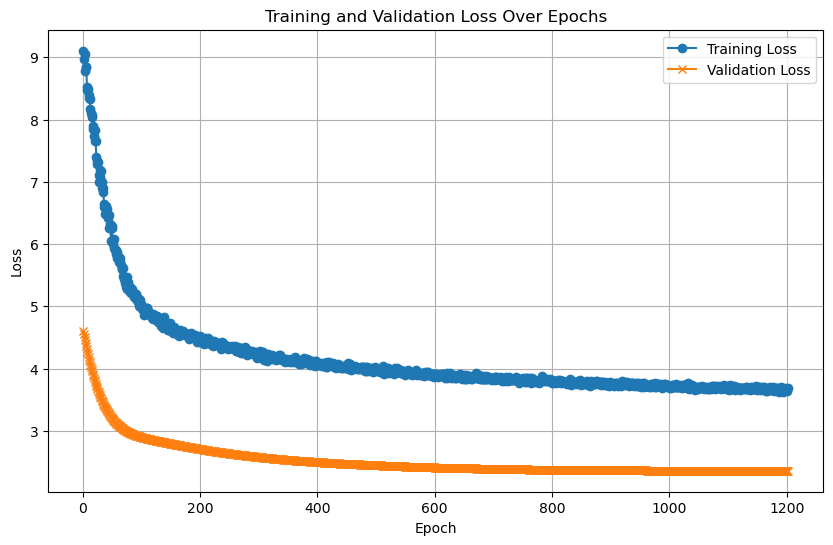

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/167], Loss: 6.0054
Test Batch [20/167], Loss: 5.6065
Test Batch [30/167], Loss: 5.5266
Test Batch [40/167], Loss: 5.7118
Test Batch [50/167], Loss: 5.5268
Test Batch [60/167], Loss: 5.7977
Test Batch [70/167], Loss: 5.8429
Test Batch [80/167], Loss: 5.4313
Test Batch [90/167], Loss: 5.4338
Test Batch [100/167], Loss: 4.9025
Test Batch [110/167], Loss: 5.2924
Test Batch [120/167], Loss: 5.1262
Test Batch [130/167], Loss: 5.1279
Test Batch [140/167], Loss: 5.4936
Test Batch [150/167], Loss: 5.0518
Test Batch [160/167], Loss: 5.9594



Test Loss: 5.4053


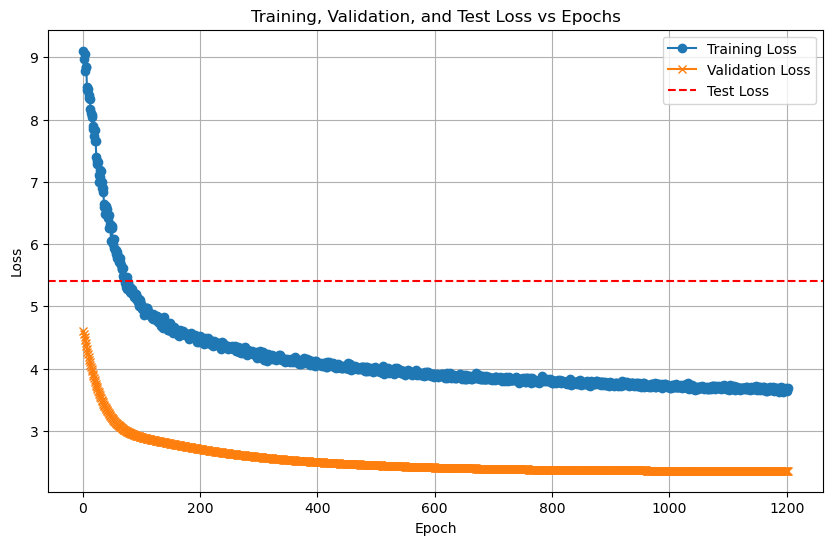

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/167 for test dataset.
  Processed batch 20/167 for test dataset.
  Processed batch 30/167 for test dataset.


  Processed batch 40/167 for test dataset.
  Processed batch 50/167 for test dataset.


  Processed batch 60/167 for test dataset.
  Processed batch 70/167 for test dataset.
  Processed batch 80/167 for test dataset.
  Processed batch 90/167 for test dataset.
  Processed batch 100/167 for test dataset.


  Processed batch 110/167 for test dataset.
  Processed batch 120/167 for test dataset.


  Processed batch 130/167 for test dataset.
  Processed batch 140/167 for test dataset.
  Processed batch 150/167 for test dataset.
  Processed batch 160/167 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42551, 128)
Test labels shape: (42551,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 77.78%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.71      1.00      0.83         5
           2       0.50      0.20      0.29         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      0.60      0.75         5
           6       0.57      0.80      0.67         5
           7       0.57      0.80      0.67         5
           8       1.00      1.00      1.00         5

    accuracy                           0.78        45
   macro avg       0.79      0.78      0.76        45
weighted avg       0.79      0.78      0.76        45


LOG: Evaluating on the test set...
Test Accuracy: 70.12%

Test Classifica

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42551, 128)
Test labels shape: (42551,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.4026  |  Val Loss: 2.3362
Validation loss improved from inf to 2.3362.
[Epoch 2/1000] Train Loss: 2.3501  |  Val Loss: 2.2956
Validation loss improved from 2.3362 to 2.2956.
[Epoch 3/1000] Train Loss: 2.3061  |  Val Loss: 2.2588
Validation loss improved from 2.2956 to 2.2588.
[Epoch 4/1000] Train Loss: 2.2642  |  Val Loss: 2.2249
Validation loss improved from 2.2588 to 2.2249.
[Epoch 5/1000] Train Loss: 2.2256  |  Val Loss: 2.1927
Validation loss improved from 2.2249 to 2.1927.
[Epoch 6/1000] Train Loss: 2.1911  |  Val Loss: 2.1612
Validation loss improved from 2.1927 to 2.1612.


[Epoch 7/1000] Train Loss: 2.1560  |  Val Loss: 2.1312
Validation loss improved from 2.1612 to 2.1312.
[Epoch 8/1000] Train Loss: 2.1205  |  Val Loss: 2.1032
Validation loss improved from 2.1312 to 2.1032.
[Epoch 9/1000] Train Loss: 2.0903  |  Val Loss: 2.0765
Validation loss improved from 2.1032 to 2.0765.
[Epoch 10/1000] Train Loss: 2.0627  |  Val Loss: 2.0507
Validation loss improved from 2.0765 to 2.0507.
[Epoch 11/1000] Train Loss: 2.0321  |  Val Loss: 2.0267
Validation loss improved from 2.0507 to 2.0267.
[Epoch 12/1000] Train Loss: 2.0042  |  Val Loss: 2.0031
Validation loss improved from 2.0267 to 2.0031.
[Epoch 13/1000] Train Loss: 1.9775  |  Val Loss: 1.9796
Validation loss improved from 2.0031 to 1.9796.
[Epoch 14/1000] Train Loss: 1.9509  |  Val Loss: 1.9562
Validation loss improved from 1.9796 to 1.9562.
[Epoch 15/1000] Train Loss: 1.9246  |  Val Loss: 1.9350
Validation loss improved from 1.9562 to 1.9350.
[Epoch 16/1000] Train Loss: 1.9033  |  Val Loss: 1.9153
Validation 

[Epoch 31/1000] Train Loss: 1.6289  |  Val Loss: 1.6673
Validation loss improved from 1.6822 to 1.6673.
[Epoch 32/1000] Train Loss: 1.6125  |  Val Loss: 1.6525
Validation loss improved from 1.6673 to 1.6525.
[Epoch 33/1000] Train Loss: 1.5961  |  Val Loss: 1.6381
Validation loss improved from 1.6525 to 1.6381.
[Epoch 34/1000] Train Loss: 1.5802  |  Val Loss: 1.6241
Validation loss improved from 1.6381 to 1.6241.
[Epoch 35/1000] Train Loss: 1.5645  |  Val Loss: 1.6101
Validation loss improved from 1.6241 to 1.6101.
[Epoch 36/1000] Train Loss: 1.5487  |  Val Loss: 1.5962
Validation loss improved from 1.6101 to 1.5962.


[Epoch 37/1000] Train Loss: 1.5330  |  Val Loss: 1.5824
Validation loss improved from 1.5962 to 1.5824.
[Epoch 38/1000] Train Loss: 1.5182  |  Val Loss: 1.5685
Validation loss improved from 1.5824 to 1.5685.
[Epoch 39/1000] Train Loss: 1.5029  |  Val Loss: 1.5548
Validation loss improved from 1.5685 to 1.5548.
[Epoch 40/1000] Train Loss: 1.4877  |  Val Loss: 1.5410
Validation loss improved from 1.5548 to 1.5410.
[Epoch 41/1000] Train Loss: 1.4728  |  Val Loss: 1.5273
Validation loss improved from 1.5410 to 1.5273.
[Epoch 42/1000] Train Loss: 1.4580  |  Val Loss: 1.5134
Validation loss improved from 1.5273 to 1.5134.
[Epoch 43/1000] Train Loss: 1.4430  |  Val Loss: 1.4996
Validation loss improved from 1.5134 to 1.4996.
[Epoch 44/1000] Train Loss: 1.4280  |  Val Loss: 1.4860
Validation loss improved from 1.4996 to 1.4860.
[Epoch 45/1000] Train Loss: 1.4135  |  Val Loss: 1.4724
Validation loss improved from 1.4860 to 1.4724.
[Epoch 46/1000] Train Loss: 1.3991  |  Val Loss: 1.4589
Validati

[Epoch 65/1000] Train Loss: 1.1566  |  Val Loss: 1.2270
Validation loss improved from 1.2381 to 1.2270.
[Epoch 66/1000] Train Loss: 1.1456  |  Val Loss: 1.2160
Validation loss improved from 1.2270 to 1.2160.
[Epoch 67/1000] Train Loss: 1.1346  |  Val Loss: 1.2052
Validation loss improved from 1.2160 to 1.2052.
[Epoch 68/1000] Train Loss: 1.1239  |  Val Loss: 1.1946
Validation loss improved from 1.2052 to 1.1946.
[Epoch 69/1000] Train Loss: 1.1134  |  Val Loss: 1.1843
Validation loss improved from 1.1946 to 1.1843.
[Epoch 70/1000] Train Loss: 1.1030  |  Val Loss: 1.1740
Validation loss improved from 1.1843 to 1.1740.
[Epoch 71/1000] Train Loss: 1.0928  |  Val Loss: 1.1639
Validation loss improved from 1.1740 to 1.1639.
[Epoch 72/1000] Train Loss: 1.0830  |  Val Loss: 1.1540
Validation loss improved from 1.1639 to 1.1540.
[Epoch 73/1000] Train Loss: 1.0732  |  Val Loss: 1.1442
Validation loss improved from 1.1540 to 1.1442.
[Epoch 74/1000] Train Loss: 1.0636  |  Val Loss: 1.1347
Validati

[Epoch 97/1000] Train Loss: 0.8765  |  Val Loss: 0.9536
Validation loss improved from 0.9603 to 0.9536.
[Epoch 98/1000] Train Loss: 0.8697  |  Val Loss: 0.9470
Validation loss improved from 0.9536 to 0.9470.
[Epoch 99/1000] Train Loss: 0.8631  |  Val Loss: 0.9403
Validation loss improved from 0.9470 to 0.9403.
[Epoch 100/1000] Train Loss: 0.8564  |  Val Loss: 0.9341
Validation loss improved from 0.9403 to 0.9341.
[Epoch 101/1000] Train Loss: 0.8499  |  Val Loss: 0.9277
Validation loss improved from 0.9341 to 0.9277.
[Epoch 102/1000] Train Loss: 0.8434  |  Val Loss: 0.9214
Validation loss improved from 0.9277 to 0.9214.
[Epoch 103/1000] Train Loss: 0.8371  |  Val Loss: 0.9153
Validation loss improved from 0.9214 to 0.9153.
[Epoch 104/1000] Train Loss: 0.8306  |  Val Loss: 0.9093
Validation loss improved from 0.9153 to 0.9093.
[Epoch 105/1000] Train Loss: 0.8244  |  Val Loss: 0.9035
Validation loss improved from 0.9093 to 0.9035.
[Epoch 106/1000] Train Loss: 0.8185  |  Val Loss: 0.8977
V

[Epoch 126/1000] Train Loss: 0.7056  |  Val Loss: 0.7914
Validation loss improved from 0.7965 to 0.7914.
[Epoch 127/1000] Train Loss: 0.7005  |  Val Loss: 0.7863
Validation loss improved from 0.7914 to 0.7863.
[Epoch 128/1000] Train Loss: 0.6952  |  Val Loss: 0.7814
Validation loss improved from 0.7863 to 0.7814.
[Epoch 129/1000] Train Loss: 0.6904  |  Val Loss: 0.7764
Validation loss improved from 0.7814 to 0.7764.
[Epoch 130/1000] Train Loss: 0.6852  |  Val Loss: 0.7716
Validation loss improved from 0.7764 to 0.7716.
[Epoch 131/1000] Train Loss: 0.6801  |  Val Loss: 0.7668
Validation loss improved from 0.7716 to 0.7668.
[Epoch 132/1000] Train Loss: 0.6753  |  Val Loss: 0.7622
Validation loss improved from 0.7668 to 0.7622.
[Epoch 133/1000] Train Loss: 0.6704  |  Val Loss: 0.7575
Validation loss improved from 0.7622 to 0.7575.
[Epoch 134/1000] Train Loss: 0.6656  |  Val Loss: 0.7528
Validation loss improved from 0.7575 to 0.7528.
[Epoch 135/1000] Train Loss: 0.6607  |  Val Loss: 0.748

[Epoch 158/1000] Train Loss: 0.5629  |  Val Loss: 0.6579
Validation loss improved from 0.6614 to 0.6579.
[Epoch 159/1000] Train Loss: 0.5592  |  Val Loss: 0.6547
Validation loss improved from 0.6579 to 0.6547.
[Epoch 160/1000] Train Loss: 0.5557  |  Val Loss: 0.6515
Validation loss improved from 0.6547 to 0.6515.
[Epoch 161/1000] Train Loss: 0.5520  |  Val Loss: 0.6481
Validation loss improved from 0.6515 to 0.6481.
[Epoch 162/1000] Train Loss: 0.5490  |  Val Loss: 0.6447
Validation loss improved from 0.6481 to 0.6447.
[Epoch 163/1000] Train Loss: 0.5452  |  Val Loss: 0.6416
Validation loss improved from 0.6447 to 0.6416.
[Epoch 164/1000] Train Loss: 0.5418  |  Val Loss: 0.6386
Validation loss improved from 0.6416 to 0.6386.
[Epoch 165/1000] Train Loss: 0.5383  |  Val Loss: 0.6356
Validation loss improved from 0.6386 to 0.6356.
[Epoch 166/1000] Train Loss: 0.5352  |  Val Loss: 0.6325
Validation loss improved from 0.6356 to 0.6325.
[Epoch 167/1000] Train Loss: 0.5319  |  Val Loss: 0.629

[Epoch 190/1000] Train Loss: 0.4704  |  Val Loss: 0.5767
Validation loss improved from 0.5784 to 0.5767.
[Epoch 191/1000] Train Loss: 0.4683  |  Val Loss: 0.5749
Validation loss improved from 0.5767 to 0.5749.
[Epoch 192/1000] Train Loss: 0.4662  |  Val Loss: 0.5733
Validation loss improved from 0.5749 to 0.5733.
[Epoch 193/1000] Train Loss: 0.4643  |  Val Loss: 0.5718
Validation loss improved from 0.5733 to 0.5718.
[Epoch 194/1000] Train Loss: 0.4630  |  Val Loss: 0.5697
Validation loss improved from 0.5718 to 0.5697.
[Epoch 195/1000] Train Loss: 0.4607  |  Val Loss: 0.5683
Validation loss improved from 0.5697 to 0.5683.
[Epoch 196/1000] Train Loss: 0.4580  |  Val Loss: 0.5666
Validation loss improved from 0.5683 to 0.5666.
[Epoch 197/1000] Train Loss: 0.4560  |  Val Loss: 0.5650
Validation loss improved from 0.5666 to 0.5650.
[Epoch 198/1000] Train Loss: 0.4544  |  Val Loss: 0.5633
Validation loss improved from 0.5650 to 0.5633.
[Epoch 199/1000] Train Loss: 0.4522  |  Val Loss: 0.561

[Epoch 219/1000] Train Loss: 0.4199  |  Val Loss: 0.5366
Validation loss improved from 0.5378 to 0.5366.
[Epoch 220/1000] Train Loss: 0.4184  |  Val Loss: 0.5355
Validation loss improved from 0.5366 to 0.5355.
[Epoch 221/1000] Train Loss: 0.4170  |  Val Loss: 0.5344
Validation loss improved from 0.5355 to 0.5344.
[Epoch 222/1000] Train Loss: 0.4159  |  Val Loss: 0.5333
Validation loss improved from 0.5344 to 0.5333.
[Epoch 223/1000] Train Loss: 0.4144  |  Val Loss: 0.5323
Validation loss improved from 0.5333 to 0.5323.
[Epoch 224/1000] Train Loss: 0.4142  |  Val Loss: 0.5311
Validation loss improved from 0.5323 to 0.5311.
[Epoch 225/1000] Train Loss: 0.4119  |  Val Loss: 0.5304
Validation loss improved from 0.5311 to 0.5304.
[Epoch 226/1000] Train Loss: 0.4106  |  Val Loss: 0.5296
Validation loss improved from 0.5304 to 0.5296.
[Epoch 227/1000] Train Loss: 0.4093  |  Val Loss: 0.5288
Validation loss improved from 0.5296 to 0.5288.
[Epoch 228/1000] Train Loss: 0.4084  |  Val Loss: 0.527

[Epoch 249/1000] Train Loss: 0.3853  |  Val Loss: 0.5124
Validation loss improved from 0.5130 to 0.5124.
[Epoch 250/1000] Train Loss: 0.3839  |  Val Loss: 0.5117
Validation loss improved from 0.5124 to 0.5117.
[Epoch 251/1000] Train Loss: 0.3829  |  Val Loss: 0.5115
Validation loss improved from 0.5117 to 0.5115.
[Epoch 252/1000] Train Loss: 0.3820  |  Val Loss: 0.5107
Validation loss improved from 0.5115 to 0.5107.
[Epoch 253/1000] Train Loss: 0.3812  |  Val Loss: 0.5104
Validation loss improved from 0.5107 to 0.5104.
[Epoch 254/1000] Train Loss: 0.3800  |  Val Loss: 0.5099
Validation loss improved from 0.5104 to 0.5099.
[Epoch 255/1000] Train Loss: 0.3791  |  Val Loss: 0.5091
Validation loss improved from 0.5099 to 0.5091.
[Epoch 256/1000] Train Loss: 0.3781  |  Val Loss: 0.5087
Validation loss improved from 0.5091 to 0.5087.
[Epoch 257/1000] Train Loss: 0.3773  |  Val Loss: 0.5079
Validation loss improved from 0.5087 to 0.5079.
[Epoch 258/1000] Train Loss: 0.3763  |  Val Loss: 0.507

[Epoch 283/1000] Train Loss: 0.3560  |  Val Loss: 0.4981
Validation loss improved from 0.4981 to 0.4981.
[Epoch 284/1000] Train Loss: 0.3552  |  Val Loss: 0.4974
Validation loss improved from 0.4981 to 0.4974.
[Epoch 285/1000] Train Loss: 0.3544  |  Val Loss: 0.4971
Validation loss improved from 0.4974 to 0.4971.
[Epoch 286/1000] Train Loss: 0.3539  |  Val Loss: 0.4968
Validation loss improved from 0.4971 to 0.4968.
[Epoch 287/1000] Train Loss: 0.3531  |  Val Loss: 0.4963
Validation loss improved from 0.4968 to 0.4963.
[Epoch 288/1000] Train Loss: 0.3523  |  Val Loss: 0.4956
Validation loss improved from 0.4963 to 0.4956.
[Epoch 289/1000] Train Loss: 0.3518  |  Val Loss: 0.4956
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 290/1000] Train Loss: 0.3508  |  Val Loss: 0.4952
Validation loss improved from 0.4956 to 0.4952.
[Epoch 291/1000] Train Loss: 0.3502  |  Val Loss: 0.4953
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 292/1000] Train Loss: 0.3495  |  Val

[Epoch 316/1000] Train Loss: 0.3347  |  Val Loss: 0.4909
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 317/1000] Train Loss: 0.3340  |  Val Loss: 0.4900
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 318/1000] Train Loss: 0.3336  |  Val Loss: 0.4899
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 319/1000] Train Loss: 0.3326  |  Val Loss: 0.4892
Validation loss improved from 0.4898 to 0.4892.
[Epoch 320/1000] Train Loss: 0.3322  |  Val Loss: 0.4893
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 321/1000] Train Loss: 0.3314  |  Val Loss: 0.4888
Validation loss improved from 0.4892 to 0.4888.
[Epoch 322/1000] Train Loss: 0.3309  |  Val Loss: 0.4882
Validation loss improved from 0.4888 to 0.4882.
[Epoch 323/1000] Train Loss: 0.3304  |  Val Loss: 0.4875
Validation loss improved from 0.4882 to 0.4875.
[Epoch 324/1000] Train Loss: 0.3302  |  Val Loss: 0.4872
Validation loss improved from 0.4875 to 0.4872.
[Epoch 325/1000] Train Loss: 0.

[Epoch 349/1000] Train Loss: 0.3171  |  Val Loss: 0.4850
Validation loss improved from 0.4858 to 0.4850.
[Epoch 350/1000] Train Loss: 0.3166  |  Val Loss: 0.4851
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 351/1000] Train Loss: 0.3158  |  Val Loss: 0.4856
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 352/1000] Train Loss: 0.3154  |  Val Loss: 0.4854
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 353/1000] Train Loss: 0.3149  |  Val Loss: 0.4851
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 354/1000] Train Loss: 0.3145  |  Val Loss: 0.4847
Validation loss improved from 0.4850 to 0.4847.
[Epoch 355/1000] Train Loss: 0.3144  |  Val Loss: 0.4847
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 356/1000] Train Loss: 0.3135  |  Val Loss: 0.4843
Validation loss improved from 0.4847 to 0.4843.
[Epoch 357/1000] Train Loss: 0.3130  |  Val Loss: 0.4840
Validation loss improved from 0.4843 to 0.4840.
[Epoch 358/1000] Train Lo

[Epoch 382/1000] Train Loss: 0.3024  |  Val Loss: 0.4803
Validation loss improved from 0.4807 to 0.4803.
[Epoch 383/1000] Train Loss: 0.3015  |  Val Loss: 0.4806
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 384/1000] Train Loss: 0.3009  |  Val Loss: 0.4821
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 385/1000] Train Loss: 0.3005  |  Val Loss: 0.4823
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 386/1000] Train Loss: 0.3006  |  Val Loss: 0.4828
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 387/1000] Train Loss: 0.2997  |  Val Loss: 0.4825
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 388/1000] Train Loss: 0.2995  |  Val Loss: 0.4828
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 389/1000] Train Loss: 0.2990  |  Val Loss: 0.4819
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 390/1000] Train Loss: 0.2986  |  Val Loss: 0.4816
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 414/1000] Train Loss: 0.2899  |  Val Loss: 0.4825
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 415/1000] Train Loss: 0.2901  |  Val Loss: 0.4835
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 416/1000] Train Loss: 0.2897  |  Val Loss: 0.4840
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 417/1000] Train Loss: 0.2893  |  Val Loss: 0.4839
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 418/1000] Train Loss: 0.2883  |  Val Loss: 0.4843
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 419/1000] Train Loss: 0.2882  |  Val Loss: 0.4848
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 420/1000] Train Loss: 0.2885  |  Val Loss: 0.4841
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 421/1000] Train Loss: 0.2881  |  Val Loss: 0.4850
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 422/1000] Train Loss: 0.2879  |  Val Loss: 0.4853
!! Validation loss did NOT improve !! Patience:

[Epoch 448/1000] Train Loss: 0.2802  |  Val Loss: 0.4868
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 449/1000] Train Loss: 0.2812  |  Val Loss: 0.4894
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 450/1000] Train Loss: 0.2792  |  Val Loss: 0.4895
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 451/1000] Train Loss: 0.2788  |  Val Loss: 0.4895
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 452/1000] Train Loss: 0.2789  |  Val Loss: 0.4889
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 453/1000] Train Loss: 0.2787  |  Val Loss: 0.4891
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 454/1000] Train Loss: 0.2785  |  Val Loss: 0.4879
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 455/1000] Train Loss: 0.2780  |  Val Loss: 0.4886
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 456/1000] Train Loss: 0.2776  |  Val Loss: 0.4888
!! Validation loss did NOT improve !! Patience:

[Epoch 479/1000] Train Loss: 0.2721  |  Val Loss: 0.4932
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 480/1000] Train Loss: 0.2717  |  Val Loss: 0.4937
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 481/1000] Train Loss: 0.2715  |  Val Loss: 0.4935
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 482/1000] Train Loss: 0.2716  |  Val Loss: 0.4943
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 483/1000] Train Loss: 0.2710  |  Val Loss: 0.4933
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 484/1000] Train Loss: 0.2707  |  Val Loss: 0.4932
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 485/1000] Train Loss: 0.2706  |  Val Loss: 0.4935
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 486/1000] Train Loss: 0.2705  |  Val Loss: 0.4931
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 487/1000] Train Loss: 0.2707  |  Val Loss: 0.4934
!! Validation loss did NOT improve !! Patience:

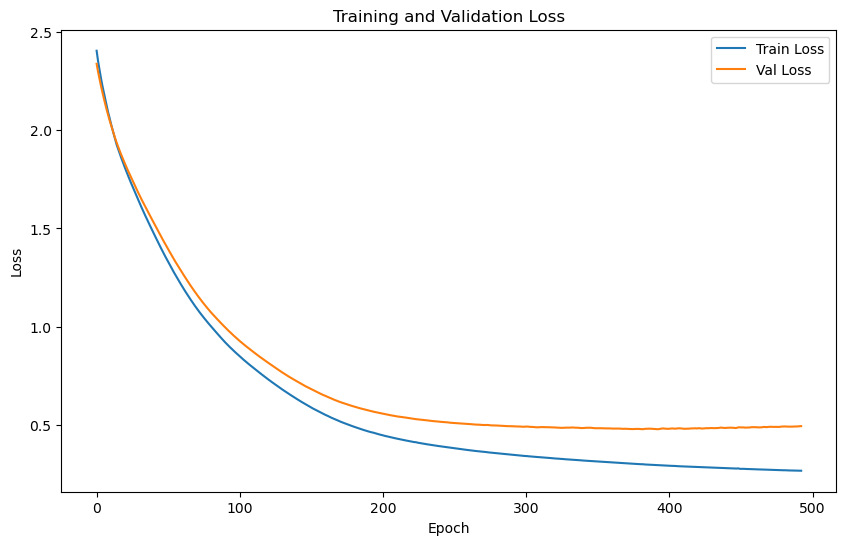

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.1383 | Test Accuracy: 68.61%


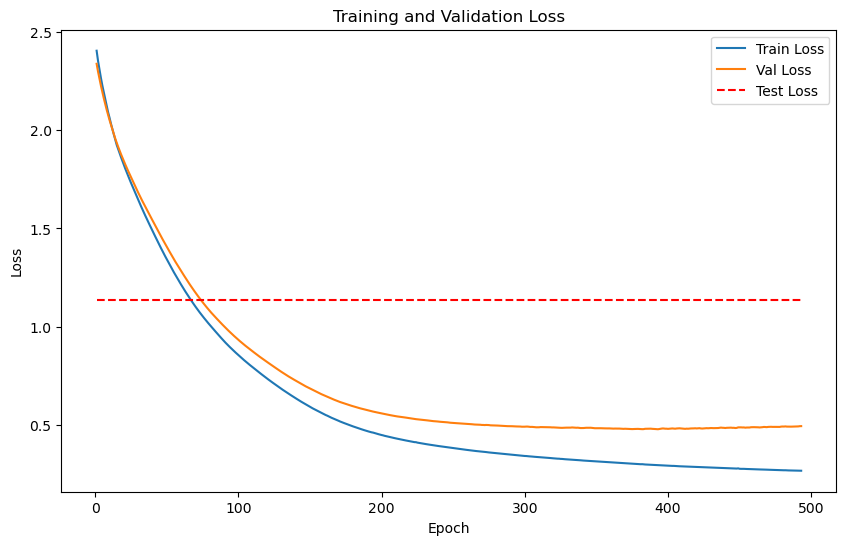

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42551 samples with 64 features each
LOG: Labels shape: (42551,)


Train embeddings shape: (180, 64), 
Train labels shape: (180,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42551, 64), 
Test labels shape: (42551,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.4665
Epoch [1/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.4665

Validation loss improved from inf to 0.4665. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4561
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.4630
Epoch [2/2000], Avg Train Loss: 0.4561, Avg Val Loss: 0.4630

Validation loss improved from 0.4665 to 0.4630. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [3/2000] - Validation
    Batch [1/1], Val Loss: 0.4605
Epoch [3/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.4605

Validation loss improved from 0.4630 to 0.4605. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.4549
LOG: Epoch [4/2000] - Validation


    Batch [1/1], Val Loss: 0.4588
Epoch [4/2000], Avg Train Loss: 0.4549, Avg Val Loss: 0.4588

Validation loss improved from 0.4605 to 0.4588. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [5/2000] - Validation
    Batch [1/1], Val Loss: 0.4571
Epoch [5/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.4571

Validation loss improved from 0.4588 to 0.4571. Saving model...
LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 0.4556
LOG: Epoch [6/2000] - Validation


    Batch [1/1], Val Loss: 0.4555
Epoch [6/2000], Avg Train Loss: 0.4556, Avg Val Loss: 0.4555

Validation loss improved from 0.4571 to 0.4555. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4533
LOG: Epoch [7/2000] - Validation
    Batch [1/1], Val Loss: 0.4537
Epoch [7/2000], Avg Train Loss: 0.4533, Avg Val Loss: 0.4537

Validation loss improved from 0.4555 to 0.4537. Saving model...
LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 0.4529
LOG: Epoch [8/2000] - Validation
    Batch [1/1], Val Loss: 0.4517
Epoch [8/2000], Avg Train Loss: 0.4529, Avg Val Loss: 0.4517

Validation loss improved from 0.4537 to 0.4517. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4512
LOG: Epoch [9/2000] - Validation


    Batch [1/1], Val Loss: 0.4507
Epoch [9/2000], Avg Train Loss: 0.4512, Avg Val Loss: 0.4507

Validation loss improved from 0.4517 to 0.4507. Saving model...
LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 0.4526
LOG: Epoch [10/2000] - Validation
    Batch [1/1], Val Loss: 0.4504
Epoch [10/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.4504

Validation loss improved from 0.4507 to 0.4504. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [11/2000] - Validation
    Batch [1/1], Val Loss: 0.4500
Epoch [11/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.4500

Validation loss improved from 0.4504 to 0.4500. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4470
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.4499
Epoch [12/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.4499

Validation loss improved from 0.4500 to 0.4499. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 0.4507
LOG: Epoch [13/2000] - Validation


    Batch [1/1], Val Loss: 0.4493
Epoch [13/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.4493

Validation loss improved from 0.4499 to 0.4493. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [14/2000] - Validation


    Batch [1/1], Val Loss: 0.4485
Epoch [14/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.4485

Validation loss improved from 0.4493 to 0.4485. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 0.4457
LOG: Epoch [15/2000] - Validation


    Batch [1/1], Val Loss: 0.4475
Epoch [15/2000], Avg Train Loss: 0.4457, Avg Val Loss: 0.4475

Validation loss improved from 0.4485 to 0.4475. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 0.4449
LOG: Epoch [16/2000] - Validation
    Batch [1/1], Val Loss: 0.4467
Epoch [16/2000], Avg Train Loss: 0.4449, Avg Val Loss: 0.4467

Validation loss improved from 0.4475 to 0.4467. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4466
LOG: Epoch [17/2000] - Validation


    Batch [1/1], Val Loss: 0.4462
Epoch [17/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.4462

Validation loss improved from 0.4467 to 0.4462. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.4459
Epoch [18/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.4459

Validation loss improved from 0.4462 to 0.4459. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.4377
LOG: Epoch [19/2000] - Validation


    Batch [1/1], Val Loss: 0.4458
Epoch [19/2000], Avg Train Loss: 0.4377, Avg Val Loss: 0.4458

Validation loss improved from 0.4459 to 0.4458. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.4411
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.4456
Epoch [20/2000], Avg Train Loss: 0.4411, Avg Val Loss: 0.4456

Validation loss improved from 0.4458 to 0.4456. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.4399
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.4452
Epoch [21/2000], Avg Train Loss: 0.4399, Avg Val Loss: 0.4452

Validation loss improved from 0.4456 to 0.4452. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4368
LOG: Epoch [22/2000] - Validation
    Batch [1/1], Val Loss: 0.4448
Epoch [22/2000], Avg Train Loss: 0.4368, Avg Val Loss: 0.4448

Validation loss improved from 0.4452 to 0.4448. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 0.4414
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.4442
Epoch [23/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.4442

Validation loss improved from 0.4448 to 0.4442. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4414
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.4436
Epoch [24/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.4436

Validation loss improved from 0.4442 to 0.4436. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.4387
LOG: Epoch [25/2000] - Validation
    Batch [1/1], Val Loss: 0.4431
Epoch [25/2000], Avg Train Loss: 0.4387, Avg Val Loss: 0.4431

Validation loss improved from 0.4436 to 0.4431. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4340
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.4426
Epoch [26/2000], Avg Train Loss: 0.4340, Avg Val Loss: 0.4426

Validation loss improved from 0.4431 to 0.4426. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.4373
LOG: Epoch [27/2000] - Validation
    Batch [1/1], Val Loss: 0.4420
Epoch [27/2000], Avg Train Loss: 0.4373, Avg Val Loss: 0.4420

Validation loss improved from 0.4426 to 0.4420. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [28/2000] - Validation


    Batch [1/1], Val Loss: 0.4415
Epoch [28/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.4415

Validation loss improved from 0.4420 to 0.4415. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.4353
LOG: Epoch [29/2000] - Validation
    Batch [1/1], Val Loss: 0.4409
Epoch [29/2000], Avg Train Loss: 0.4353, Avg Val Loss: 0.4409

Validation loss improved from 0.4415 to 0.4409. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.4340
LOG: Epoch [30/2000] - Validation


    Batch [1/1], Val Loss: 0.4403
Epoch [30/2000], Avg Train Loss: 0.4340, Avg Val Loss: 0.4403

Validation loss improved from 0.4409 to 0.4403. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.4317
LOG: Epoch [31/2000] - Validation
    Batch [1/1], Val Loss: 0.4397
Epoch [31/2000], Avg Train Loss: 0.4317, Avg Val Loss: 0.4397

Validation loss improved from 0.4403 to 0.4397. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.4320
LOG: Epoch [32/2000] - Validation


    Batch [1/1], Val Loss: 0.4392
Epoch [32/2000], Avg Train Loss: 0.4320, Avg Val Loss: 0.4392

Validation loss improved from 0.4397 to 0.4392. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.4306
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.4386
Epoch [33/2000], Avg Train Loss: 0.4306, Avg Val Loss: 0.4386

Validation loss improved from 0.4392 to 0.4386. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.4283
LOG: Epoch [34/2000] - Validation


    Batch [1/1], Val Loss: 0.4380
Epoch [34/2000], Avg Train Loss: 0.4283, Avg Val Loss: 0.4380

Validation loss improved from 0.4386 to 0.4380. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 0.4321
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.4375
Epoch [35/2000], Avg Train Loss: 0.4321, Avg Val Loss: 0.4375

Validation loss improved from 0.4380 to 0.4375. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.4280
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.4369
Epoch [36/2000], Avg Train Loss: 0.4280, Avg Val Loss: 0.4369

Validation loss improved from 0.4375 to 0.4369. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4275
LOG: Epoch [37/2000] - Validation
    Batch [1/1], Val Loss: 0.4364
Epoch [37/2000], Avg Train Loss: 0.4275, Avg Val Loss: 0.4364

Validation loss improved from 0.4369 to 0.4364. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.4237
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.4358
Epoch [38/2000], Avg Train Loss: 0.4237, Avg Val Loss: 0.4358

Validation loss improved from 0.4364 to 0.4358. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.4265
LOG: Epoch [39/2000] - Validation
    Batch [1/1], Val Loss: 0.4353
Epoch [39/2000], Avg Train Loss: 0.4265, Avg Val Loss: 0.4353

Validation loss improved from 0.4358 to 0.4353. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4265
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.4348
Epoch [40/2000], Avg Train Loss: 0.4265, Avg Val Loss: 0.4348

Validation loss improved from 0.4353 to 0.4348. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.4280
LOG: Epoch [41/2000] - Validation
    Batch [1/1], Val Loss: 0.4342
Epoch [41/2000], Avg Train Loss: 0.4280, Avg Val Loss: 0.4342

Validation loss improved from 0.4348 to 0.4342. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4245
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.4337
Epoch [42/2000], Avg Train Loss: 0.4245, Avg Val Loss: 0.4337

Validation loss improved from 0.4342 to 0.4337. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.4202
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.4331
Epoch [43/2000], Avg Train Loss: 0.4202, Avg Val Loss: 0.4331

Validation loss improved from 0.4337 to 0.4331. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 0.4231
LOG: Epoch [44/2000] - Validation


    Batch [1/1], Val Loss: 0.4324
Epoch [44/2000], Avg Train Loss: 0.4231, Avg Val Loss: 0.4324

Validation loss improved from 0.4331 to 0.4324. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.4229
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.4318
Epoch [45/2000], Avg Train Loss: 0.4229, Avg Val Loss: 0.4318

Validation loss improved from 0.4324 to 0.4318. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.4252
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.4313
Epoch [46/2000], Avg Train Loss: 0.4252, Avg Val Loss: 0.4313

Validation loss improved from 0.4318 to 0.4313. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4176
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.4307
Epoch [47/2000], Avg Train Loss: 0.4176, Avg Val Loss: 0.4307

Validation loss improved from 0.4313 to 0.4307. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.4204
LOG: Epoch [48/2000] - Validation
    Batch [1/1], Val Loss: 0.4301
Epoch [48/2000], Avg Train Loss: 0.4204, Avg Val Loss: 0.4301

Validation loss improved from 0.4307 to 0.4301. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.4235
LOG: Epoch [49/2000] - Validation


    Batch [1/1], Val Loss: 0.4295
Epoch [49/2000], Avg Train Loss: 0.4235, Avg Val Loss: 0.4295

Validation loss improved from 0.4301 to 0.4295. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.4195
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.4289
Epoch [50/2000], Avg Train Loss: 0.4195, Avg Val Loss: 0.4289

Validation loss improved from 0.4295 to 0.4289. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.4169
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.4283
Epoch [51/2000], Avg Train Loss: 0.4169, Avg Val Loss: 0.4283

Validation loss improved from 0.4289 to 0.4283. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4198
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.4277
Epoch [52/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.4277

Validation loss improved from 0.4283 to 0.4277. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.4205
LOG: Epoch [53/2000] - Validation
    Batch [1/1], Val Loss: 0.4272
Epoch [53/2000], Avg Train Loss: 0.4205, Avg Val Loss: 0.4272

Validation loss improved from 0.4277 to 0.4272. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4213
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.4266
Epoch [54/2000], Avg Train Loss: 0.4213, Avg Val Loss: 0.4266

Validation loss improved from 0.4272 to 0.4266. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.4160
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.4261
Epoch [55/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.4261

Validation loss improved from 0.4266 to 0.4261. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 0.4168
LOG: Epoch [56/2000] - Validation


    Batch [1/1], Val Loss: 0.4255
Epoch [56/2000], Avg Train Loss: 0.4168, Avg Val Loss: 0.4255

Validation loss improved from 0.4261 to 0.4255. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.4167
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.4250
Epoch [57/2000], Avg Train Loss: 0.4167, Avg Val Loss: 0.4250

Validation loss improved from 0.4255 to 0.4250. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.4136
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.4244
Epoch [58/2000], Avg Train Loss: 0.4136, Avg Val Loss: 0.4244

Validation loss improved from 0.4250 to 0.4244. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.4239
Epoch [59/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.4239

Validation loss improved from 0.4244 to 0.4239. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.4128
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.4234
Epoch [60/2000], Avg Train Loss: 0.4128, Avg Val Loss: 0.4234

Validation loss improved from 0.4239 to 0.4234. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.4112
LOG: Epoch [61/2000] - Validation


    Batch [1/1], Val Loss: 0.4228
Epoch [61/2000], Avg Train Loss: 0.4112, Avg Val Loss: 0.4228

Validation loss improved from 0.4234 to 0.4228. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.4153
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.4223
Epoch [62/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.4223

Validation loss improved from 0.4228 to 0.4223. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.4116
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.4218
Epoch [63/2000], Avg Train Loss: 0.4116, Avg Val Loss: 0.4218

Validation loss improved from 0.4223 to 0.4218. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4109
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.4213
Epoch [64/2000], Avg Train Loss: 0.4109, Avg Val Loss: 0.4213

Validation loss improved from 0.4218 to 0.4213. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.4106
LOG: Epoch [65/2000] - Validation
    Batch [1/1], Val Loss: 0.4208
Epoch [65/2000], Avg Train Loss: 0.4106, Avg Val Loss: 0.4208

Validation loss improved from 0.4213 to 0.4208. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.4078
LOG: Epoch [66/2000] - Validation


    Batch [1/1], Val Loss: 0.4203
Epoch [66/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.4203

Validation loss improved from 0.4208 to 0.4203. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.4198
Epoch [67/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.4198

Validation loss improved from 0.4203 to 0.4198. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [68/2000] - Validation


    Batch [1/1], Val Loss: 0.4193
Epoch [68/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.4193

Validation loss improved from 0.4198 to 0.4193. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 0.4090
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.4188
Epoch [69/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.4188

Validation loss improved from 0.4193 to 0.4188. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.4097
LOG: Epoch [70/2000] - Validation
    Batch [1/1], Val Loss: 0.4184
Epoch [70/2000], Avg Train Loss: 0.4097, Avg Val Loss: 0.4184

Validation loss improved from 0.4188 to 0.4184. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4071
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.4179
Epoch [71/2000], Avg Train Loss: 0.4071, Avg Val Loss: 0.4179

Validation loss improved from 0.4184 to 0.4179. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.4175
Epoch [72/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.4175

Validation loss improved from 0.4179 to 0.4175. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 0.4074
LOG: Epoch [73/2000] - Validation


    Batch [1/1], Val Loss: 0.4171
Epoch [73/2000], Avg Train Loss: 0.4074, Avg Val Loss: 0.4171

Validation loss improved from 0.4175 to 0.4171. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.4166
Epoch [74/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.4166

Validation loss improved from 0.4171 to 0.4166. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.4161
Epoch [75/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.4161

Validation loss improved from 0.4166 to 0.4161. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.4157
Epoch [76/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.4157

Validation loss improved from 0.4161 to 0.4157. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.4152
Epoch [77/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.4152

Validation loss improved from 0.4157 to 0.4152. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.4057
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.4147
Epoch [78/2000], Avg Train Loss: 0.4057, Avg Val Loss: 0.4147

Validation loss improved from 0.4152 to 0.4147. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.4142
Epoch [79/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.4142

Validation loss improved from 0.4147 to 0.4142. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.4138
Epoch [80/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.4138

Validation loss improved from 0.4142 to 0.4138. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [81/2000] - Validation


    Batch [1/1], Val Loss: 0.4133
Epoch [81/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.4133

Validation loss improved from 0.4138 to 0.4133. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.4129
Epoch [82/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.4129

Validation loss improved from 0.4133 to 0.4129. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 0.3976
LOG: Epoch [83/2000] - Validation
    Batch [1/1], Val Loss: 0.4124
Epoch [83/2000], Avg Train Loss: 0.3976, Avg Val Loss: 0.4124

Validation loss improved from 0.4129 to 0.4124. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.4120
Epoch [84/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.4120

Validation loss improved from 0.4124 to 0.4120. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.4115
Epoch [85/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.4115

Validation loss improved from 0.4120 to 0.4115. Saving model...
LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 0.3991
LOG: Epoch [86/2000] - Validation


    Batch [1/1], Val Loss: 0.4111
Epoch [86/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.4111

Validation loss improved from 0.4115 to 0.4111. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.4107
Epoch [87/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.4107

Validation loss improved from 0.4111 to 0.4107. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.3961
LOG: Epoch [88/2000] - Validation


    Batch [1/1], Val Loss: 0.4102
Epoch [88/2000], Avg Train Loss: 0.3961, Avg Val Loss: 0.4102

Validation loss improved from 0.4107 to 0.4102. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.4098
Epoch [89/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.4098

Validation loss improved from 0.4102 to 0.4098. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.4093
Epoch [90/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.4093

Validation loss improved from 0.4098 to 0.4093. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.3976
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.4089
Epoch [91/2000], Avg Train Loss: 0.3976, Avg Val Loss: 0.4089

Validation loss improved from 0.4093 to 0.4089. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.3985
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.4086
Epoch [92/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.4086

Validation loss improved from 0.4089 to 0.4086. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [93/2000] - Validation


    Batch [1/1], Val Loss: 0.4082
Epoch [93/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.4082

Validation loss improved from 0.4086 to 0.4082. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.4078
Epoch [94/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.4078

Validation loss improved from 0.4082 to 0.4078. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [95/2000] - Validation


    Batch [1/1], Val Loss: 0.4074
Epoch [95/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.4074

Validation loss improved from 0.4078 to 0.4074. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [96/2000] - Validation
    Batch [1/1], Val Loss: 0.4071
Epoch [96/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.4071

Validation loss improved from 0.4074 to 0.4071. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [97/2000] - Validation
    Batch [1/1], Val Loss: 0.4067
Epoch [97/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.4067

Validation loss improved from 0.4071 to 0.4067. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.4064
Epoch [98/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.4064

Validation loss improved from 0.4067 to 0.4064. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.4061
Epoch [99/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.4061

Validation loss improved from 0.4064 to 0.4061. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.4058
Epoch [100/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.4058

Validation loss improved from 0.4061 to 0.4058. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [101/2000] - Validation
    Batch [1/1], Val Loss: 0.4055
Epoch [101/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.4055

Validation loss improved from 0.4058 to 0.4055. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [102/2000] - Validation


    Batch [1/1], Val Loss: 0.4052
Epoch [102/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.4052

Validation loss improved from 0.4055 to 0.4052. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.3890
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.4049
Epoch [103/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.4049

Validation loss improved from 0.4052 to 0.4049. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [104/2000] - Validation


    Batch [1/1], Val Loss: 0.4046
Epoch [104/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.4046

Validation loss improved from 0.4049 to 0.4046. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.4043
Epoch [105/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.4043

Validation loss improved from 0.4046 to 0.4043. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [106/2000] - Validation
    Batch [1/1], Val Loss: 0.4040
Epoch [106/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.4040

Validation loss improved from 0.4043 to 0.4040. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.4037
Epoch [107/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.4037

Validation loss improved from 0.4040 to 0.4037. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [108/2000] - Validation
    Batch [1/1], Val Loss: 0.4033
Epoch [108/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.4033

Validation loss improved from 0.4037 to 0.4033. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [109/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [109/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.4030

Validation loss improved from 0.4033 to 0.4030. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.4027
Epoch [110/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.4027

Validation loss improved from 0.4030 to 0.4027. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.4023
Epoch [111/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.4023

Validation loss improved from 0.4027 to 0.4023. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.3869
LOG: Epoch [112/2000] - Validation


    Batch [1/1], Val Loss: 0.4020
Epoch [112/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.4020

Validation loss improved from 0.4023 to 0.4020. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [113/2000] - Validation
    Batch [1/1], Val Loss: 0.4016
Epoch [113/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.4016

Validation loss improved from 0.4020 to 0.4016. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [114/2000] - Validation
    Batch [1/1], Val Loss: 0.4013
Epoch [114/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.4013

Validation loss improved from 0.4016 to 0.4013. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.3868
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.4009
Epoch [115/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.4009

Validation loss improved from 0.4013 to 0.4009. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.3817
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.4006
Epoch [116/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.4006

Validation loss improved from 0.4009 to 0.4006. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.3863
LOG: Epoch [117/2000] - Validation
    Batch [1/1], Val Loss: 0.4003
Epoch [117/2000], Avg Train Loss: 0.3863, Avg Val Loss: 0.4003

Validation loss improved from 0.4006 to 0.4003. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.3817
LOG: Epoch [118/2000] - Validation
    Batch [1/1], Val Loss: 0.4000
Epoch [118/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.4000

Validation loss improved from 0.4003 to 0.4000. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.3793
LOG: Epoch [119/2000] - Validation


    Batch [1/1], Val Loss: 0.3997
Epoch [119/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.3997

Validation loss improved from 0.4000 to 0.3997. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.3825
LOG: Epoch [120/2000] - Validation
    Batch [1/1], Val Loss: 0.3994
Epoch [120/2000], Avg Train Loss: 0.3825, Avg Val Loss: 0.3994

Validation loss improved from 0.3997 to 0.3994. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.3809
LOG: Epoch [121/2000] - Validation
    Batch [1/1], Val Loss: 0.3991
Epoch [121/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.3991

Validation loss improved from 0.3994 to 0.3991. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.3841
LOG: Epoch [122/2000] - Validation
    Batch [1/1], Val Loss: 0.3989
Epoch [122/2000], Avg Train Loss: 0.3841, Avg Val Loss: 0.3989

Validation loss improved from 0.3991 to 0.3989. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.3839
LOG: Epoch [123/2000] - Validation
    Batch [1/1], Val Loss: 0.3986
Epoch [123/2000], Avg Train Loss: 0.3839, Avg Val Loss: 0.3986

Validation loss improved from 0.3989 to 0.3986. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.3828
LOG: Epoch [124/2000] - Validation


    Batch [1/1], Val Loss: 0.3983
Epoch [124/2000], Avg Train Loss: 0.3828, Avg Val Loss: 0.3983

Validation loss improved from 0.3986 to 0.3983. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.3824
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.3980
Epoch [125/2000], Avg Train Loss: 0.3824, Avg Val Loss: 0.3980

Validation loss improved from 0.3983 to 0.3980. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 0.3807
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.3977
Epoch [126/2000], Avg Train Loss: 0.3807, Avg Val Loss: 0.3977

Validation loss improved from 0.3980 to 0.3977. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.3809
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.3975
Epoch [127/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.3975

Validation loss improved from 0.3977 to 0.3975. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.3761
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.3972
Epoch [128/2000], Avg Train Loss: 0.3761, Avg Val Loss: 0.3972

Validation loss improved from 0.3975 to 0.3972. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.3757
LOG: Epoch [129/2000] - Validation


    Batch [1/1], Val Loss: 0.3970
Epoch [129/2000], Avg Train Loss: 0.3757, Avg Val Loss: 0.3970

Validation loss improved from 0.3972 to 0.3970. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 0.3801
LOG: Epoch [130/2000] - Validation
    Batch [1/1], Val Loss: 0.3968
Epoch [130/2000], Avg Train Loss: 0.3801, Avg Val Loss: 0.3968

Validation loss improved from 0.3970 to 0.3968. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.3749
LOG: Epoch [131/2000] - Validation


    Batch [1/1], Val Loss: 0.3966
Epoch [131/2000], Avg Train Loss: 0.3749, Avg Val Loss: 0.3966

Validation loss improved from 0.3968 to 0.3966. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.3779
LOG: Epoch [132/2000] - Validation
    Batch [1/1], Val Loss: 0.3964
Epoch [132/2000], Avg Train Loss: 0.3779, Avg Val Loss: 0.3964

Validation loss improved from 0.3966 to 0.3964. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 0.3750
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.3963
Epoch [133/2000], Avg Train Loss: 0.3750, Avg Val Loss: 0.3963

Validation loss improved from 0.3964 to 0.3963. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.3785
LOG: Epoch [134/2000] - Validation
    Batch [1/1], Val Loss: 0.3962
Epoch [134/2000], Avg Train Loss: 0.3785, Avg Val Loss: 0.3962

Validation loss improved from 0.3963 to 0.3962. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 0.3803
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.3960
Epoch [135/2000], Avg Train Loss: 0.3803, Avg Val Loss: 0.3960

Validation loss improved from 0.3962 to 0.3960. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.3958
Epoch [136/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.3958

Validation loss improved from 0.3960 to 0.3958. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.3797
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.3956
Epoch [137/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.3956

Validation loss improved from 0.3958 to 0.3956. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.3778
LOG: Epoch [138/2000] - Validation


    Batch [1/1], Val Loss: 0.3954
Epoch [138/2000], Avg Train Loss: 0.3778, Avg Val Loss: 0.3954

Validation loss improved from 0.3956 to 0.3954. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.3733
LOG: Epoch [139/2000] - Validation
    Batch [1/1], Val Loss: 0.3952
Epoch [139/2000], Avg Train Loss: 0.3733, Avg Val Loss: 0.3952

Validation loss improved from 0.3954 to 0.3952. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.3727
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.3950
Epoch [140/2000], Avg Train Loss: 0.3727, Avg Val Loss: 0.3950

Validation loss improved from 0.3952 to 0.3950. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.3766
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.3948
Epoch [141/2000], Avg Train Loss: 0.3766, Avg Val Loss: 0.3948

Validation loss improved from 0.3950 to 0.3948. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.3743
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.3947
Epoch [142/2000], Avg Train Loss: 0.3743, Avg Val Loss: 0.3947

Validation loss improved from 0.3948 to 0.3947. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.3715
LOG: Epoch [143/2000] - Validation


    Batch [1/1], Val Loss: 0.3945
Epoch [143/2000], Avg Train Loss: 0.3715, Avg Val Loss: 0.3945

Validation loss improved from 0.3947 to 0.3945. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 0.3696
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.3943
Epoch [144/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.3943

Validation loss improved from 0.3945 to 0.3943. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.3751
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.3940
Epoch [145/2000], Avg Train Loss: 0.3751, Avg Val Loss: 0.3940

Validation loss improved from 0.3943 to 0.3940. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.3720
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.3938
Epoch [146/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.3938

Validation loss improved from 0.3940 to 0.3938. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.3723
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.3936
Epoch [147/2000], Avg Train Loss: 0.3723, Avg Val Loss: 0.3936

Validation loss improved from 0.3938 to 0.3936. Saving model...
LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 0.3739
LOG: Epoch [148/2000] - Validation
    Batch [1/1], Val Loss: 0.3934
Epoch [148/2000], Avg Train Loss: 0.3739, Avg Val Loss: 0.3934

Validation loss improved from 0.3936 to 0.3934. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.3683
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.3932
Epoch [149/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.3932

Validation loss improved from 0.3934 to 0.3932. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.3715
LOG: Epoch [150/2000] - Validation
    Batch [1/1], Val Loss: 0.3930
Epoch [150/2000], Avg Train Loss: 0.3715, Avg Val Loss: 0.3930

Validation loss improved from 0.3932 to 0.3930. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.3752
LOG: Epoch [151/2000] - Validation


    Batch [1/1], Val Loss: 0.3928
Epoch [151/2000], Avg Train Loss: 0.3752, Avg Val Loss: 0.3928

Validation loss improved from 0.3930 to 0.3928. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.3696
LOG: Epoch [152/2000] - Validation
    Batch [1/1], Val Loss: 0.3925
Epoch [152/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.3925

Validation loss improved from 0.3928 to 0.3925. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [153/2000] - Validation


    Batch [1/1], Val Loss: 0.3923
Epoch [153/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.3923

Validation loss improved from 0.3925 to 0.3923. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.3697
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.3920
Epoch [154/2000], Avg Train Loss: 0.3697, Avg Val Loss: 0.3920

Validation loss improved from 0.3923 to 0.3920. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.3720
LOG: Epoch [155/2000] - Validation


    Batch [1/1], Val Loss: 0.3918
Epoch [155/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.3918

Validation loss improved from 0.3920 to 0.3918. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.3700
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.3915
Epoch [156/2000], Avg Train Loss: 0.3700, Avg Val Loss: 0.3915

Validation loss improved from 0.3918 to 0.3915. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.3699
LOG: Epoch [157/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [157/2000], Avg Train Loss: 0.3699, Avg Val Loss: 0.3913

Validation loss improved from 0.3915 to 0.3913. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.3661
LOG: Epoch [158/2000] - Validation
    Batch [1/1], Val Loss: 0.3910
Epoch [158/2000], Avg Train Loss: 0.3661, Avg Val Loss: 0.3910

Validation loss improved from 0.3913 to 0.3910. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.3709
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.3907
Epoch [159/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.3907

Validation loss improved from 0.3910 to 0.3907. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [160/2000] - Validation
    Batch [1/1], Val Loss: 0.3904
Epoch [160/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.3904

Validation loss improved from 0.3907 to 0.3904. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.3629
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.3902
Epoch [161/2000], Avg Train Loss: 0.3629, Avg Val Loss: 0.3902

Validation loss improved from 0.3904 to 0.3902. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.3668
LOG: Epoch [162/2000] - Validation


    Batch [1/1], Val Loss: 0.3899
Epoch [162/2000], Avg Train Loss: 0.3668, Avg Val Loss: 0.3899

Validation loss improved from 0.3902 to 0.3899. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.3642
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.3896
Epoch [163/2000], Avg Train Loss: 0.3642, Avg Val Loss: 0.3896

Validation loss improved from 0.3899 to 0.3896. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.3636
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.3894
Epoch [164/2000], Avg Train Loss: 0.3636, Avg Val Loss: 0.3894

Validation loss improved from 0.3896 to 0.3894. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.3639
LOG: Epoch [165/2000] - Validation
    Batch [1/1], Val Loss: 0.3891
Epoch [165/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.3891

Validation loss improved from 0.3894 to 0.3891. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 0.3591
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.3889
Epoch [166/2000], Avg Train Loss: 0.3591, Avg Val Loss: 0.3889

Validation loss improved from 0.3891 to 0.3889. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.3625
LOG: Epoch [167/2000] - Validation


    Batch [1/1], Val Loss: 0.3886
Epoch [167/2000], Avg Train Loss: 0.3625, Avg Val Loss: 0.3886

Validation loss improved from 0.3889 to 0.3886. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 0.3641
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.3884
Epoch [168/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.3884

Validation loss improved from 0.3886 to 0.3884. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.3656
LOG: Epoch [169/2000] - Validation
    Batch [1/1], Val Loss: 0.3881
Epoch [169/2000], Avg Train Loss: 0.3656, Avg Val Loss: 0.3881

Validation loss improved from 0.3884 to 0.3881. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.3605
LOG: Epoch [170/2000] - Validation
    Batch [1/1], Val Loss: 0.3879
Epoch [170/2000], Avg Train Loss: 0.3605, Avg Val Loss: 0.3879

Validation loss improved from 0.3881 to 0.3879. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.3877
Epoch [171/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.3877

Validation loss improved from 0.3879 to 0.3877. Saving model...
LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 0.3623
LOG: Epoch [172/2000] - Validation


    Batch [1/1], Val Loss: 0.3875
Epoch [172/2000], Avg Train Loss: 0.3623, Avg Val Loss: 0.3875

Validation loss improved from 0.3877 to 0.3875. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.3632
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.3874
Epoch [173/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.3874

Validation loss improved from 0.3875 to 0.3874. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 0.3615
LOG: Epoch [174/2000] - Validation
    Batch [1/1], Val Loss: 0.3872
Epoch [174/2000], Avg Train Loss: 0.3615, Avg Val Loss: 0.3872

Validation loss improved from 0.3874 to 0.3872. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.3635
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.3870
Epoch [175/2000], Avg Train Loss: 0.3635, Avg Val Loss: 0.3870

Validation loss improved from 0.3872 to 0.3870. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.3634
LOG: Epoch [176/2000] - Validation
    Batch [1/1], Val Loss: 0.3868
Epoch [176/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.3868

Validation loss improved from 0.3870 to 0.3868. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.3600
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.3867
Epoch [177/2000], Avg Train Loss: 0.3600, Avg Val Loss: 0.3867

Validation loss improved from 0.3868 to 0.3867. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.3666
LOG: Epoch [178/2000] - Validation
    Batch [1/1], Val Loss: 0.3865
Epoch [178/2000], Avg Train Loss: 0.3666, Avg Val Loss: 0.3865

Validation loss improved from 0.3867 to 0.3865. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.3635
LOG: Epoch [179/2000] - Validation
    Batch [1/1], Val Loss: 0.3862
Epoch [179/2000], Avg Train Loss: 0.3635, Avg Val Loss: 0.3862

Validation loss improved from 0.3865 to 0.3862. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.3587
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.3861
Epoch [180/2000], Avg Train Loss: 0.3587, Avg Val Loss: 0.3861

Validation loss improved from 0.3862 to 0.3861. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.3571
LOG: Epoch [181/2000] - Validation


    Batch [1/1], Val Loss: 0.3859
Epoch [181/2000], Avg Train Loss: 0.3571, Avg Val Loss: 0.3859

Validation loss improved from 0.3861 to 0.3859. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.3608
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.3857
Epoch [182/2000], Avg Train Loss: 0.3608, Avg Val Loss: 0.3857

Validation loss improved from 0.3859 to 0.3857. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.3614
LOG: Epoch [183/2000] - Validation


    Batch [1/1], Val Loss: 0.3856
Epoch [183/2000], Avg Train Loss: 0.3614, Avg Val Loss: 0.3856

Validation loss improved from 0.3857 to 0.3856. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.3559
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.3854
Epoch [184/2000], Avg Train Loss: 0.3559, Avg Val Loss: 0.3854

Validation loss improved from 0.3856 to 0.3854. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.3591
LOG: Epoch [185/2000] - Validation
    Batch [1/1], Val Loss: 0.3853
Epoch [185/2000], Avg Train Loss: 0.3591, Avg Val Loss: 0.3853

Validation loss improved from 0.3854 to 0.3853. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.3628
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.3852
Epoch [186/2000], Avg Train Loss: 0.3628, Avg Val Loss: 0.3852

Validation loss improved from 0.3853 to 0.3852. Saving model...
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.3582
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.3850
Epoch [187/2000], Avg Train Loss: 0.3582, Avg Val Loss: 0.3850

Validation loss improved from 0.3852 to 0.3850. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.3566
LOG: Epoch [188/2000] - Validation


    Batch [1/1], Val Loss: 0.3849
Epoch [188/2000], Avg Train Loss: 0.3566, Avg Val Loss: 0.3849

Validation loss improved from 0.3850 to 0.3849. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 0.3600
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.3847
Epoch [189/2000], Avg Train Loss: 0.3600, Avg Val Loss: 0.3847

Validation loss improved from 0.3849 to 0.3847. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 0.3598
LOG: Epoch [190/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [190/2000], Avg Train Loss: 0.3598, Avg Val Loss: 0.3846

Validation loss improved from 0.3847 to 0.3846. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.3588
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.3844
Epoch [191/2000], Avg Train Loss: 0.3588, Avg Val Loss: 0.3844

Validation loss improved from 0.3846 to 0.3844. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.3547
LOG: Epoch [192/2000] - Validation
    Batch [1/1], Val Loss: 0.3842
Epoch [192/2000], Avg Train Loss: 0.3547, Avg Val Loss: 0.3842

Validation loss improved from 0.3844 to 0.3842. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 0.3547
LOG: Epoch [193/2000] - Validation


    Batch [1/1], Val Loss: 0.3840
Epoch [193/2000], Avg Train Loss: 0.3547, Avg Val Loss: 0.3840

Validation loss improved from 0.3842 to 0.3840. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.3555
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.3838
Epoch [194/2000], Avg Train Loss: 0.3555, Avg Val Loss: 0.3838

Validation loss improved from 0.3840 to 0.3838. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.3556
LOG: Epoch [195/2000] - Validation


    Batch [1/1], Val Loss: 0.3837
Epoch [195/2000], Avg Train Loss: 0.3556, Avg Val Loss: 0.3837

Validation loss improved from 0.3838 to 0.3837. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 0.3541
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.3835
Epoch [196/2000], Avg Train Loss: 0.3541, Avg Val Loss: 0.3835

Validation loss improved from 0.3837 to 0.3835. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.3546
LOG: Epoch [197/2000] - Validation


    Batch [1/1], Val Loss: 0.3834
Epoch [197/2000], Avg Train Loss: 0.3546, Avg Val Loss: 0.3834

Validation loss improved from 0.3835 to 0.3834. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.3524
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.3832
Epoch [198/2000], Avg Train Loss: 0.3524, Avg Val Loss: 0.3832

Validation loss improved from 0.3834 to 0.3832. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.3519
LOG: Epoch [199/2000] - Validation


    Batch [1/1], Val Loss: 0.3830
Epoch [199/2000], Avg Train Loss: 0.3519, Avg Val Loss: 0.3830

Validation loss improved from 0.3832 to 0.3830. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [200/2000] - Validation
    Batch [1/1], Val Loss: 0.3828
Epoch [200/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.3828

Validation loss improved from 0.3830 to 0.3828. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.3549
LOG: Epoch [201/2000] - Validation
    Batch [1/1], Val Loss: 0.3826
Epoch [201/2000], Avg Train Loss: 0.3549, Avg Val Loss: 0.3826

Validation loss improved from 0.3828 to 0.3826. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.3522
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.3824
Epoch [202/2000], Avg Train Loss: 0.3522, Avg Val Loss: 0.3824

Validation loss improved from 0.3826 to 0.3824. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.3574
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.3822
Epoch [203/2000], Avg Train Loss: 0.3574, Avg Val Loss: 0.3822

Validation loss improved from 0.3824 to 0.3822. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 0.3524
LOG: Epoch [204/2000] - Validation


    Batch [1/1], Val Loss: 0.3820
Epoch [204/2000], Avg Train Loss: 0.3524, Avg Val Loss: 0.3820

Validation loss improved from 0.3822 to 0.3820. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 0.3526
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.3818
Epoch [205/2000], Avg Train Loss: 0.3526, Avg Val Loss: 0.3818

Validation loss improved from 0.3820 to 0.3818. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 0.3513
LOG: Epoch [206/2000] - Validation


    Batch [1/1], Val Loss: 0.3816
Epoch [206/2000], Avg Train Loss: 0.3513, Avg Val Loss: 0.3816

Validation loss improved from 0.3818 to 0.3816. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.3545
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.3815
Epoch [207/2000], Avg Train Loss: 0.3545, Avg Val Loss: 0.3815

Validation loss improved from 0.3816 to 0.3815. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.3532
LOG: Epoch [208/2000] - Validation


    Batch [1/1], Val Loss: 0.3813
Epoch [208/2000], Avg Train Loss: 0.3532, Avg Val Loss: 0.3813

Validation loss improved from 0.3815 to 0.3813. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 0.3529
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.3812
Epoch [209/2000], Avg Train Loss: 0.3529, Avg Val Loss: 0.3812

Validation loss improved from 0.3813 to 0.3812. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.3500
LOG: Epoch [210/2000] - Validation
    Batch [1/1], Val Loss: 0.3811
Epoch [210/2000], Avg Train Loss: 0.3500, Avg Val Loss: 0.3811

Validation loss improved from 0.3812 to 0.3811. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.3522
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.3809
Epoch [211/2000], Avg Train Loss: 0.3522, Avg Val Loss: 0.3809

Validation loss improved from 0.3811 to 0.3809. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 0.3509
LOG: Epoch [212/2000] - Validation
    Batch [1/1], Val Loss: 0.3807
Epoch [212/2000], Avg Train Loss: 0.3509, Avg Val Loss: 0.3807

Validation loss improved from 0.3809 to 0.3807. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [213/2000] - Validation


    Batch [1/1], Val Loss: 0.3806
Epoch [213/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.3806

Validation loss improved from 0.3807 to 0.3806. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.3493
LOG: Epoch [214/2000] - Validation
    Batch [1/1], Val Loss: 0.3804
Epoch [214/2000], Avg Train Loss: 0.3493, Avg Val Loss: 0.3804

Validation loss improved from 0.3806 to 0.3804. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [215/2000] - Validation


    Batch [1/1], Val Loss: 0.3802
Epoch [215/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.3802

Validation loss improved from 0.3804 to 0.3802. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.3477
LOG: Epoch [216/2000] - Validation
    Batch [1/1], Val Loss: 0.3800
Epoch [216/2000], Avg Train Loss: 0.3477, Avg Val Loss: 0.3800

Validation loss improved from 0.3802 to 0.3800. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 0.3497
LOG: Epoch [217/2000] - Validation


    Batch [1/1], Val Loss: 0.3798
Epoch [217/2000], Avg Train Loss: 0.3497, Avg Val Loss: 0.3798

Validation loss improved from 0.3800 to 0.3798. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 0.3448
LOG: Epoch [218/2000] - Validation
    Batch [1/1], Val Loss: 0.3796
Epoch [218/2000], Avg Train Loss: 0.3448, Avg Val Loss: 0.3796

Validation loss improved from 0.3798 to 0.3796. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 0.3497
LOG: Epoch [219/2000] - Validation


    Batch [1/1], Val Loss: 0.3794
Epoch [219/2000], Avg Train Loss: 0.3497, Avg Val Loss: 0.3794

Validation loss improved from 0.3796 to 0.3794. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.3791
Epoch [220/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.3791

Validation loss improved from 0.3794 to 0.3791. Saving model...
LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.3789
Epoch [221/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.3789

Validation loss improved from 0.3791 to 0.3789. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.3521
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.3787
Epoch [222/2000], Avg Train Loss: 0.3521, Avg Val Loss: 0.3787

Validation loss improved from 0.3789 to 0.3787. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.3485
LOG: Epoch [223/2000] - Validation
    Batch [1/1], Val Loss: 0.3784
Epoch [223/2000], Avg Train Loss: 0.3485, Avg Val Loss: 0.3784

Validation loss improved from 0.3787 to 0.3784. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [224/2000] - Validation


    Batch [1/1], Val Loss: 0.3782
Epoch [224/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.3782

Validation loss improved from 0.3784 to 0.3782. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.3457
LOG: Epoch [225/2000] - Validation
    Batch [1/1], Val Loss: 0.3780
Epoch [225/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.3780

Validation loss improved from 0.3782 to 0.3780. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [226/2000] - Validation
    Batch [1/1], Val Loss: 0.3778
Epoch [226/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.3778

Validation loss improved from 0.3780 to 0.3778. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.3776
Epoch [227/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.3776

Validation loss improved from 0.3778 to 0.3776. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [228/2000] - Validation
    Batch [1/1], Val Loss: 0.3775
Epoch [228/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.3775

Validation loss improved from 0.3776 to 0.3775. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.3774
Epoch [229/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.3774

Validation loss improved from 0.3775 to 0.3774. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [230/2000] - Validation
    Batch [1/1], Val Loss: 0.3773
Epoch [230/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.3773

Validation loss improved from 0.3774 to 0.3773. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.3771
Epoch [231/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.3771

Validation loss improved from 0.3773 to 0.3771. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [232/2000] - Validation
    Batch [1/1], Val Loss: 0.3769
Epoch [232/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.3769

Validation loss improved from 0.3771 to 0.3769. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.3397
LOG: Epoch [233/2000] - Validation


    Batch [1/1], Val Loss: 0.3767
Epoch [233/2000], Avg Train Loss: 0.3397, Avg Val Loss: 0.3767

Validation loss improved from 0.3769 to 0.3767. Saving model...
LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.3765
Epoch [234/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.3765

Validation loss improved from 0.3767 to 0.3765. Saving model...
LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 0.3435
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.3763
Epoch [235/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.3763

Validation loss improved from 0.3765 to 0.3763. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.3418
LOG: Epoch [236/2000] - Validation
    Batch [1/1], Val Loss: 0.3761
Epoch [236/2000], Avg Train Loss: 0.3418, Avg Val Loss: 0.3761

Validation loss improved from 0.3763 to 0.3761. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.3759
Epoch [237/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.3759

Validation loss improved from 0.3761 to 0.3759. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.3389
LOG: Epoch [238/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [238/2000], Avg Train Loss: 0.3389, Avg Val Loss: 0.3757

Validation loss improved from 0.3759 to 0.3757. Saving model...
LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 0.3424
LOG: Epoch [239/2000] - Validation
    Batch [1/1], Val Loss: 0.3755
Epoch [239/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.3755

Validation loss improved from 0.3757 to 0.3755. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.3380
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.3753
Epoch [240/2000], Avg Train Loss: 0.3380, Avg Val Loss: 0.3753

Validation loss improved from 0.3755 to 0.3753. Saving model...
LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [241/2000] - Validation
    Batch [1/1], Val Loss: 0.3751
Epoch [241/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.3751

Validation loss improved from 0.3753 to 0.3751. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.3748
Epoch [242/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.3748

Validation loss improved from 0.3751 to 0.3748. Saving model...
LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 0.3376
LOG: Epoch [243/2000] - Validation
    Batch [1/1], Val Loss: 0.3746
Epoch [243/2000], Avg Train Loss: 0.3376, Avg Val Loss: 0.3746

Validation loss improved from 0.3748 to 0.3746. Saving model...
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.3390
LOG: Epoch [244/2000] - Validation


    Batch [1/1], Val Loss: 0.3744
Epoch [244/2000], Avg Train Loss: 0.3390, Avg Val Loss: 0.3744

Validation loss improved from 0.3746 to 0.3744. Saving model...
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.3428
LOG: Epoch [245/2000] - Validation
    Batch [1/1], Val Loss: 0.3742
Epoch [245/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.3742

Validation loss improved from 0.3744 to 0.3742. Saving model...
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.3387
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.3740
Epoch [246/2000], Avg Train Loss: 0.3387, Avg Val Loss: 0.3740

Validation loss improved from 0.3742 to 0.3740. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.3352
LOG: Epoch [247/2000] - Validation
    Batch [1/1], Val Loss: 0.3738
Epoch [247/2000], Avg Train Loss: 0.3352, Avg Val Loss: 0.3738

Validation loss improved from 0.3740 to 0.3738. Saving model...
LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 0.3345
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.3736
Epoch [248/2000], Avg Train Loss: 0.3345, Avg Val Loss: 0.3736

Validation loss improved from 0.3738 to 0.3736. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.3735
Epoch [249/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.3735

Validation loss improved from 0.3736 to 0.3735. Saving model...
LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 0.3390
LOG: Epoch [250/2000] - Validation
    Batch [1/1], Val Loss: 0.3733
Epoch [250/2000], Avg Train Loss: 0.3390, Avg Val Loss: 0.3733

Validation loss improved from 0.3735 to 0.3733. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.3386
LOG: Epoch [251/2000] - Validation


    Batch [1/1], Val Loss: 0.3731
Epoch [251/2000], Avg Train Loss: 0.3386, Avg Val Loss: 0.3731

Validation loss improved from 0.3733 to 0.3731. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.3389
LOG: Epoch [252/2000] - Validation
    Batch [1/1], Val Loss: 0.3730
Epoch [252/2000], Avg Train Loss: 0.3389, Avg Val Loss: 0.3730

Validation loss improved from 0.3731 to 0.3730. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 0.3386
LOG: Epoch [253/2000] - Validation


    Batch [1/1], Val Loss: 0.3729
Epoch [253/2000], Avg Train Loss: 0.3386, Avg Val Loss: 0.3729

Validation loss improved from 0.3730 to 0.3729. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.3383
LOG: Epoch [254/2000] - Validation
    Batch [1/1], Val Loss: 0.3727
Epoch [254/2000], Avg Train Loss: 0.3383, Avg Val Loss: 0.3727

Validation loss improved from 0.3729 to 0.3727. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.3335
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.3725
Epoch [255/2000], Avg Train Loss: 0.3335, Avg Val Loss: 0.3725

Validation loss improved from 0.3727 to 0.3725. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.3372
LOG: Epoch [256/2000] - Validation
    Batch [1/1], Val Loss: 0.3724
Epoch [256/2000], Avg Train Loss: 0.3372, Avg Val Loss: 0.3724

Validation loss improved from 0.3725 to 0.3724. Saving model...
LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 0.3350
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.3722
Epoch [257/2000], Avg Train Loss: 0.3350, Avg Val Loss: 0.3722

Validation loss improved from 0.3724 to 0.3722. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.3362
LOG: Epoch [258/2000] - Validation
    Batch [1/1], Val Loss: 0.3720
Epoch [258/2000], Avg Train Loss: 0.3362, Avg Val Loss: 0.3720

Validation loss improved from 0.3722 to 0.3720. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.3359
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.3719
Epoch [259/2000], Avg Train Loss: 0.3359, Avg Val Loss: 0.3719

Validation loss improved from 0.3720 to 0.3719. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.3336
LOG: Epoch [260/2000] - Validation


    Batch [1/1], Val Loss: 0.3717
Epoch [260/2000], Avg Train Loss: 0.3336, Avg Val Loss: 0.3717

Validation loss improved from 0.3719 to 0.3717. Saving model...
LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 0.3336
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.3717
Epoch [261/2000], Avg Train Loss: 0.3336, Avg Val Loss: 0.3717

Validation loss improved from 0.3717 to 0.3717. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.3360
LOG: Epoch [262/2000] - Validation
    Batch [1/1], Val Loss: 0.3716
Epoch [262/2000], Avg Train Loss: 0.3360, Avg Val Loss: 0.3716

Validation loss improved from 0.3717 to 0.3716. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.3378
LOG: Epoch [263/2000] - Validation
    Batch [1/1], Val Loss: 0.3715
Epoch [263/2000], Avg Train Loss: 0.3378, Avg Val Loss: 0.3715

Validation loss improved from 0.3716 to 0.3715. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.3352
LOG: Epoch [264/2000] - Validation
    Batch [1/1], Val Loss: 0.3715
Epoch [264/2000], Avg Train Loss: 0.3352, Avg Val Loss: 0.3715

Validation loss improved from 0.3715 to 0.3715. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.3334
LOG: Epoch [265/2000] - Validation


    Batch [1/1], Val Loss: 0.3715
Epoch [265/2000], Avg Train Loss: 0.3334, Avg Val Loss: 0.3715

Validation loss improved from 0.3715 to 0.3715. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.3302
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.3714
Epoch [266/2000], Avg Train Loss: 0.3302, Avg Val Loss: 0.3714

Validation loss improved from 0.3715 to 0.3714. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.3305
LOG: Epoch [267/2000] - Validation
    Batch [1/1], Val Loss: 0.3712
Epoch [267/2000], Avg Train Loss: 0.3305, Avg Val Loss: 0.3712

Validation loss improved from 0.3714 to 0.3712. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.3289
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.3710
Epoch [268/2000], Avg Train Loss: 0.3289, Avg Val Loss: 0.3710

Validation loss improved from 0.3712 to 0.3710. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.3317
LOG: Epoch [269/2000] - Validation
    Batch [1/1], Val Loss: 0.3709
Epoch [269/2000], Avg Train Loss: 0.3317, Avg Val Loss: 0.3709

Validation loss improved from 0.3710 to 0.3709. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.3331
LOG: Epoch [270/2000] - Validation


    Batch [1/1], Val Loss: 0.3708
Epoch [270/2000], Avg Train Loss: 0.3331, Avg Val Loss: 0.3708

Validation loss improved from 0.3709 to 0.3708. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.3265
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.3707
Epoch [271/2000], Avg Train Loss: 0.3265, Avg Val Loss: 0.3707

Validation loss improved from 0.3708 to 0.3707. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.3304
LOG: Epoch [272/2000] - Validation
    Batch [1/1], Val Loss: 0.3705
Epoch [272/2000], Avg Train Loss: 0.3304, Avg Val Loss: 0.3705

Validation loss improved from 0.3707 to 0.3705. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.3319
LOG: Epoch [273/2000] - Validation
    Batch [1/1], Val Loss: 0.3704
Epoch [273/2000], Avg Train Loss: 0.3319, Avg Val Loss: 0.3704

Validation loss improved from 0.3705 to 0.3704. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 0.3313
LOG: Epoch [274/2000] - Validation


    Batch [1/1], Val Loss: 0.3702
Epoch [274/2000], Avg Train Loss: 0.3313, Avg Val Loss: 0.3702

Validation loss improved from 0.3704 to 0.3702. Saving model...
LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 0.3295
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.3701
Epoch [275/2000], Avg Train Loss: 0.3295, Avg Val Loss: 0.3701

Validation loss improved from 0.3702 to 0.3701. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 0.3301
LOG: Epoch [276/2000] - Validation


    Batch [1/1], Val Loss: 0.3699
Epoch [276/2000], Avg Train Loss: 0.3301, Avg Val Loss: 0.3699

Validation loss improved from 0.3701 to 0.3699. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 0.3351
LOG: Epoch [277/2000] - Validation
    Batch [1/1], Val Loss: 0.3697
Epoch [277/2000], Avg Train Loss: 0.3351, Avg Val Loss: 0.3697

Validation loss improved from 0.3699 to 0.3697. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.3347
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.3695
Epoch [278/2000], Avg Train Loss: 0.3347, Avg Val Loss: 0.3695

Validation loss improved from 0.3697 to 0.3695. Saving model...
LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 0.3288
LOG: Epoch [279/2000] - Validation
    Batch [1/1], Val Loss: 0.3692
Epoch [279/2000], Avg Train Loss: 0.3288, Avg Val Loss: 0.3692

Validation loss improved from 0.3695 to 0.3692. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.3302
LOG: Epoch [280/2000] - Validation


    Batch [1/1], Val Loss: 0.3690
Epoch [280/2000], Avg Train Loss: 0.3302, Avg Val Loss: 0.3690

Validation loss improved from 0.3692 to 0.3690. Saving model...
LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 0.3287
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.3687
Epoch [281/2000], Avg Train Loss: 0.3287, Avg Val Loss: 0.3687

Validation loss improved from 0.3690 to 0.3687. Saving model...
LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 0.3276
LOG: Epoch [282/2000] - Validation


    Batch [1/1], Val Loss: 0.3685
Epoch [282/2000], Avg Train Loss: 0.3276, Avg Val Loss: 0.3685

Validation loss improved from 0.3687 to 0.3685. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.3298
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.3682
Epoch [283/2000], Avg Train Loss: 0.3298, Avg Val Loss: 0.3682

Validation loss improved from 0.3685 to 0.3682. Saving model...
LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 0.3274
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.3680
Epoch [284/2000], Avg Train Loss: 0.3274, Avg Val Loss: 0.3680

Validation loss improved from 0.3682 to 0.3680. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.3305
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.3677
Epoch [285/2000], Avg Train Loss: 0.3305, Avg Val Loss: 0.3677

Validation loss improved from 0.3680 to 0.3677. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.3227
LOG: Epoch [286/2000] - Validation
    Batch [1/1], Val Loss: 0.3675
Epoch [286/2000], Avg Train Loss: 0.3227, Avg Val Loss: 0.3675

Validation loss improved from 0.3677 to 0.3675. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.3272
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.3672
Epoch [287/2000], Avg Train Loss: 0.3272, Avg Val Loss: 0.3672

Validation loss improved from 0.3675 to 0.3672. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.3324
LOG: Epoch [288/2000] - Validation
    Batch [1/1], Val Loss: 0.3670
Epoch [288/2000], Avg Train Loss: 0.3324, Avg Val Loss: 0.3670

Validation loss improved from 0.3672 to 0.3670. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.3312
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.3668
Epoch [289/2000], Avg Train Loss: 0.3312, Avg Val Loss: 0.3668

Validation loss improved from 0.3670 to 0.3668. Saving model...
LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 0.3246
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.3666
Epoch [290/2000], Avg Train Loss: 0.3246, Avg Val Loss: 0.3666

Validation loss improved from 0.3668 to 0.3666. Saving model...
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.3259
LOG: Epoch [291/2000] - Validation


    Batch [1/1], Val Loss: 0.3664
Epoch [291/2000], Avg Train Loss: 0.3259, Avg Val Loss: 0.3664

Validation loss improved from 0.3666 to 0.3664. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.3198
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.3662
Epoch [292/2000], Avg Train Loss: 0.3198, Avg Val Loss: 0.3662

Validation loss improved from 0.3664 to 0.3662. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.3252
LOG: Epoch [293/2000] - Validation
    Batch [1/1], Val Loss: 0.3661
Epoch [293/2000], Avg Train Loss: 0.3252, Avg Val Loss: 0.3661

Validation loss improved from 0.3662 to 0.3661. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.3292
LOG: Epoch [294/2000] - Validation
    Batch [1/1], Val Loss: 0.3660
Epoch [294/2000], Avg Train Loss: 0.3292, Avg Val Loss: 0.3660

Validation loss improved from 0.3661 to 0.3660. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.3234
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.3660
Epoch [295/2000], Avg Train Loss: 0.3234, Avg Val Loss: 0.3660

Validation loss improved from 0.3660 to 0.3660. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.3253
LOG: Epoch [296/2000] - Validation
    Batch [1/1], Val Loss: 0.3659
Epoch [296/2000], Avg Train Loss: 0.3253, Avg Val Loss: 0.3659

Validation loss improved from 0.3660 to 0.3659. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.3180
LOG: Epoch [297/2000] - Validation
    Batch [1/1], Val Loss: 0.3659
Epoch [297/2000], Avg Train Loss: 0.3180, Avg Val Loss: 0.3659

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 0.3270
LOG: Epoch [298/2000] - Validation


    Batch [1/1], Val Loss: 0.3659
Epoch [298/2000], Avg Train Loss: 0.3270, Avg Val Loss: 0.3659

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.3232
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.3660
Epoch [299/2000], Avg Train Loss: 0.3232, Avg Val Loss: 0.3660

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.3242
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.3660
Epoch [300/2000], Avg Train Loss: 0.3242, Avg Val Loss: 0.3660

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.3199
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.3660
Epoch [301/2000], Avg Train Loss: 0.3199, Avg Val Loss: 0.3660

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.3187
LOG: Epoch [302/2000] - Validation
    Batch [1/1], Val Loss: 0.3660
Epoch [302/2000], Avg Train Loss: 0.3187, Avg Val Loss: 0.3660

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 0.3243
LOG: Epoch [303/2000] - Validation


    Batch [1/1], Val Loss: 0.3660
Epoch [303/2000], Avg Train Loss: 0.3243, Avg Val Loss: 0.3660

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.3189
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.3660
Epoch [304/2000], Avg Train Loss: 0.3189, Avg Val Loss: 0.3660

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.3254
LOG: Epoch [305/2000] - Validation
    Batch [1/1], Val Loss: 0.3659
Epoch [305/2000], Avg Train Loss: 0.3254, Avg Val Loss: 0.3659

Validation loss improved from 0.3659 to 0.3659. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.3208
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.3658
Epoch [306/2000], Avg Train Loss: 0.3208, Avg Val Loss: 0.3658

Validation loss improved from 0.3659 to 0.3658. Saving model...
LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 0.3195
LOG: Epoch [307/2000] - Validation
    Batch [1/1], Val Loss: 0.3657
Epoch [307/2000], Avg Train Loss: 0.3195, Avg Val Loss: 0.3657

Validation loss improved from 0.3658 to 0.3657. Saving model...
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.3238
LOG: Epoch [308/2000] - Validation


    Batch [1/1], Val Loss: 0.3656
Epoch [308/2000], Avg Train Loss: 0.3238, Avg Val Loss: 0.3656

Validation loss improved from 0.3657 to 0.3656. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.3240
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.3655
Epoch [309/2000], Avg Train Loss: 0.3240, Avg Val Loss: 0.3655

Validation loss improved from 0.3656 to 0.3655. Saving model...
LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 0.3241
LOG: Epoch [310/2000] - Validation


    Batch [1/1], Val Loss: 0.3654
Epoch [310/2000], Avg Train Loss: 0.3241, Avg Val Loss: 0.3654

Validation loss improved from 0.3655 to 0.3654. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.3208
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.3654
Epoch [311/2000], Avg Train Loss: 0.3208, Avg Val Loss: 0.3654

Validation loss improved from 0.3654 to 0.3654. Saving model...
LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 0.3213
LOG: Epoch [312/2000] - Validation
    Batch [1/1], Val Loss: 0.3653
Epoch [312/2000], Avg Train Loss: 0.3213, Avg Val Loss: 0.3653

Validation loss improved from 0.3654 to 0.3653. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.3223
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.3652
Epoch [313/2000], Avg Train Loss: 0.3223, Avg Val Loss: 0.3652

Validation loss improved from 0.3653 to 0.3652. Saving model...
LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 0.3172
LOG: Epoch [314/2000] - Validation
    Batch [1/1], Val Loss: 0.3652
Epoch [314/2000], Avg Train Loss: 0.3172, Avg Val Loss: 0.3652

Validation loss improved from 0.3652 to 0.3652. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.3233
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.3651
Epoch [315/2000], Avg Train Loss: 0.3233, Avg Val Loss: 0.3651

Validation loss improved from 0.3652 to 0.3651. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.3182
LOG: Epoch [316/2000] - Validation
    Batch [1/1], Val Loss: 0.3651
Epoch [316/2000], Avg Train Loss: 0.3182, Avg Val Loss: 0.3651

Validation loss improved from 0.3651 to 0.3651. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.3204
LOG: Epoch [317/2000] - Validation
    Batch [1/1], Val Loss: 0.3650
Epoch [317/2000], Avg Train Loss: 0.3204, Avg Val Loss: 0.3650

Validation loss improved from 0.3651 to 0.3650. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.3203
LOG: Epoch [318/2000] - Validation
    Batch [1/1], Val Loss: 0.3648
Epoch [318/2000], Avg Train Loss: 0.3203, Avg Val Loss: 0.3648

Validation loss improved from 0.3650 to 0.3648. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.3216
LOG: Epoch [319/2000] - Validation
    Batch [1/1], Val Loss: 0.3647
Epoch [319/2000], Avg Train Loss: 0.3216, Avg Val Loss: 0.3647

Validation loss improved from 0.3648 to 0.3647. Saving model...
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.3174
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.3645
Epoch [320/2000], Avg Train Loss: 0.3174, Avg Val Loss: 0.3645

Validation loss improved from 0.3647 to 0.3645. Saving model...
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.3167
LOG: Epoch [321/2000] - Validation


    Batch [1/1], Val Loss: 0.3643
Epoch [321/2000], Avg Train Loss: 0.3167, Avg Val Loss: 0.3643

Validation loss improved from 0.3645 to 0.3643. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.3175
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.3641
Epoch [322/2000], Avg Train Loss: 0.3175, Avg Val Loss: 0.3641

Validation loss improved from 0.3643 to 0.3641. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.3191
LOG: Epoch [323/2000] - Validation
    Batch [1/1], Val Loss: 0.3640
Epoch [323/2000], Avg Train Loss: 0.3191, Avg Val Loss: 0.3640

Validation loss improved from 0.3641 to 0.3640. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.3138
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.3638
Epoch [324/2000], Avg Train Loss: 0.3138, Avg Val Loss: 0.3638

Validation loss improved from 0.3640 to 0.3638. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.3161
LOG: Epoch [325/2000] - Validation
    Batch [1/1], Val Loss: 0.3637
Epoch [325/2000], Avg Train Loss: 0.3161, Avg Val Loss: 0.3637

Validation loss improved from 0.3638 to 0.3637. Saving model...
LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 0.3173
LOG: Epoch [326/2000] - Validation


    Batch [1/1], Val Loss: 0.3635
Epoch [326/2000], Avg Train Loss: 0.3173, Avg Val Loss: 0.3635

Validation loss improved from 0.3637 to 0.3635. Saving model...
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.3118
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.3633
Epoch [327/2000], Avg Train Loss: 0.3118, Avg Val Loss: 0.3633

Validation loss improved from 0.3635 to 0.3633. Saving model...
LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 0.3180
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.3631
Epoch [328/2000], Avg Train Loss: 0.3180, Avg Val Loss: 0.3631

Validation loss improved from 0.3633 to 0.3631. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.3171
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.3629
Epoch [329/2000], Avg Train Loss: 0.3171, Avg Val Loss: 0.3629

Validation loss improved from 0.3631 to 0.3629. Saving model...
LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 0.3186
LOG: Epoch [330/2000] - Validation
    Batch [1/1], Val Loss: 0.3627
Epoch [330/2000], Avg Train Loss: 0.3186, Avg Val Loss: 0.3627

Validation loss improved from 0.3629 to 0.3627. Saving model...
LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 0.3171
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.3627
Epoch [331/2000], Avg Train Loss: 0.3171, Avg Val Loss: 0.3627

Validation loss improved from 0.3627 to 0.3627. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.3143
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.3626
Epoch [332/2000], Avg Train Loss: 0.3143, Avg Val Loss: 0.3626

Validation loss improved from 0.3627 to 0.3626. Saving model...
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.3160
LOG: Epoch [333/2000] - Validation
    Batch [1/1], Val Loss: 0.3625
Epoch [333/2000], Avg Train Loss: 0.3160, Avg Val Loss: 0.3625

Validation loss improved from 0.3626 to 0.3625. Saving model...
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.3161
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.3624
Epoch [334/2000], Avg Train Loss: 0.3161, Avg Val Loss: 0.3624

Validation loss improved from 0.3625 to 0.3624. Saving model...
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.3186
LOG: Epoch [335/2000] - Validation
    Batch [1/1], Val Loss: 0.3623
Epoch [335/2000], Avg Train Loss: 0.3186, Avg Val Loss: 0.3623

Validation loss improved from 0.3624 to 0.3623. Saving model...
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.3152
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.3623
Epoch [336/2000], Avg Train Loss: 0.3152, Avg Val Loss: 0.3623

Validation loss improved from 0.3623 to 0.3623. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.3135
LOG: Epoch [337/2000] - Validation
    Batch [1/1], Val Loss: 0.3622
Epoch [337/2000], Avg Train Loss: 0.3135, Avg Val Loss: 0.3622

Validation loss improved from 0.3623 to 0.3622. Saving model...
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.3105
LOG: Epoch [338/2000] - Validation
    Batch [1/1], Val Loss: 0.3621
Epoch [338/2000], Avg Train Loss: 0.3105, Avg Val Loss: 0.3621

Validation loss improved from 0.3622 to 0.3621. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.3182
LOG: Epoch [339/2000] - Validation
    Batch [1/1], Val Loss: 0.3620
Epoch [339/2000], Avg Train Loss: 0.3182, Avg Val Loss: 0.3620

Validation loss improved from 0.3621 to 0.3620. Saving model...
LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 0.3097
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.3619
Epoch [340/2000], Avg Train Loss: 0.3097, Avg Val Loss: 0.3619

Validation loss improved from 0.3620 to 0.3619. Saving model...
LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 0.3120
LOG: Epoch [341/2000] - Validation


    Batch [1/1], Val Loss: 0.3618
Epoch [341/2000], Avg Train Loss: 0.3120, Avg Val Loss: 0.3618

Validation loss improved from 0.3619 to 0.3618. Saving model...
LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 0.3127
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.3618
Epoch [342/2000], Avg Train Loss: 0.3127, Avg Val Loss: 0.3618

Validation loss improved from 0.3618 to 0.3618. Saving model...
LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 0.3110
LOG: Epoch [343/2000] - Validation


    Batch [1/1], Val Loss: 0.3618
Epoch [343/2000], Avg Train Loss: 0.3110, Avg Val Loss: 0.3618

Validation loss improved from 0.3618 to 0.3618. Saving model...
LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 0.3093
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.3617
Epoch [344/2000], Avg Train Loss: 0.3093, Avg Val Loss: 0.3617

Validation loss improved from 0.3618 to 0.3617. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.3116
LOG: Epoch [345/2000] - Validation
    Batch [1/1], Val Loss: 0.3617
Epoch [345/2000], Avg Train Loss: 0.3116, Avg Val Loss: 0.3617

Validation loss improved from 0.3617 to 0.3617. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.3077
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.3617
Epoch [346/2000], Avg Train Loss: 0.3077, Avg Val Loss: 0.3617

Validation loss improved from 0.3617 to 0.3617. Saving model...
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.3078
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.3616
Epoch [347/2000], Avg Train Loss: 0.3078, Avg Val Loss: 0.3616

Validation loss improved from 0.3617 to 0.3616. Saving model...
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.3094
LOG: Epoch [348/2000] - Validation


    Batch [1/1], Val Loss: 0.3615
Epoch [348/2000], Avg Train Loss: 0.3094, Avg Val Loss: 0.3615

Validation loss improved from 0.3616 to 0.3615. Saving model...
LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 0.3150
LOG: Epoch [349/2000] - Validation
    Batch [1/1], Val Loss: 0.3613
Epoch [349/2000], Avg Train Loss: 0.3150, Avg Val Loss: 0.3613

Validation loss improved from 0.3615 to 0.3613. Saving model...
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.3037
LOG: Epoch [350/2000] - Validation


    Batch [1/1], Val Loss: 0.3612
Epoch [350/2000], Avg Train Loss: 0.3037, Avg Val Loss: 0.3612

Validation loss improved from 0.3613 to 0.3612. Saving model...
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.3127
LOG: Epoch [351/2000] - Validation
    Batch [1/1], Val Loss: 0.3610
Epoch [351/2000], Avg Train Loss: 0.3127, Avg Val Loss: 0.3610

Validation loss improved from 0.3612 to 0.3610. Saving model...
LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 0.3092
LOG: Epoch [352/2000] - Validation


    Batch [1/1], Val Loss: 0.3608
Epoch [352/2000], Avg Train Loss: 0.3092, Avg Val Loss: 0.3608

Validation loss improved from 0.3610 to 0.3608. Saving model...
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.3105
LOG: Epoch [353/2000] - Validation
    Batch [1/1], Val Loss: 0.3606
Epoch [353/2000], Avg Train Loss: 0.3105, Avg Val Loss: 0.3606

Validation loss improved from 0.3608 to 0.3606. Saving model...
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.3079
LOG: Epoch [354/2000] - Validation


    Batch [1/1], Val Loss: 0.3604
Epoch [354/2000], Avg Train Loss: 0.3079, Avg Val Loss: 0.3604

Validation loss improved from 0.3606 to 0.3604. Saving model...
LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 0.3056
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [355/2000], Avg Train Loss: 0.3056, Avg Val Loss: 0.3602

Validation loss improved from 0.3604 to 0.3602. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.3064
LOG: Epoch [356/2000] - Validation
    Batch [1/1], Val Loss: 0.3601
Epoch [356/2000], Avg Train Loss: 0.3064, Avg Val Loss: 0.3601

Validation loss improved from 0.3602 to 0.3601. Saving model...
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.3013
LOG: Epoch [357/2000] - Validation
    Batch [1/1], Val Loss: 0.3600
Epoch [357/2000], Avg Train Loss: 0.3013, Avg Val Loss: 0.3600

Validation loss improved from 0.3601 to 0.3600. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.3113
LOG: Epoch [358/2000] - Validation
    Batch [1/1], Val Loss: 0.3598
Epoch [358/2000], Avg Train Loss: 0.3113, Avg Val Loss: 0.3598

Validation loss improved from 0.3600 to 0.3598. Saving model...
LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 0.3102
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.3597
Epoch [359/2000], Avg Train Loss: 0.3102, Avg Val Loss: 0.3597

Validation loss improved from 0.3598 to 0.3597. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.3049
LOG: Epoch [360/2000] - Validation
    Batch [1/1], Val Loss: 0.3596
Epoch [360/2000], Avg Train Loss: 0.3049, Avg Val Loss: 0.3596

Validation loss improved from 0.3597 to 0.3596. Saving model...
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.3074
LOG: Epoch [361/2000] - Validation
    Batch [1/1], Val Loss: 0.3594
Epoch [361/2000], Avg Train Loss: 0.3074, Avg Val Loss: 0.3594

Validation loss improved from 0.3596 to 0.3594. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.3075
LOG: Epoch [362/2000] - Validation
    Batch [1/1], Val Loss: 0.3593
Epoch [362/2000], Avg Train Loss: 0.3075, Avg Val Loss: 0.3593

Validation loss improved from 0.3594 to 0.3593. Saving model...
LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 0.3037
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.3593
Epoch [363/2000], Avg Train Loss: 0.3037, Avg Val Loss: 0.3593

Validation loss improved from 0.3593 to 0.3593. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.3059
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.3592
Epoch [364/2000], Avg Train Loss: 0.3059, Avg Val Loss: 0.3592

Validation loss improved from 0.3593 to 0.3592. Saving model...
LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 0.3060
LOG: Epoch [365/2000] - Validation
    Batch [1/1], Val Loss: 0.3591
Epoch [365/2000], Avg Train Loss: 0.3060, Avg Val Loss: 0.3591

Validation loss improved from 0.3592 to 0.3591. Saving model...
LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 0.3048
LOG: Epoch [366/2000] - Validation


    Batch [1/1], Val Loss: 0.3591
Epoch [366/2000], Avg Train Loss: 0.3048, Avg Val Loss: 0.3591

Validation loss improved from 0.3591 to 0.3591. Saving model...
LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 0.2999
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.3590
Epoch [367/2000], Avg Train Loss: 0.2999, Avg Val Loss: 0.3590

Validation loss improved from 0.3591 to 0.3590. Saving model...
LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 0.3043
LOG: Epoch [368/2000] - Validation


    Batch [1/1], Val Loss: 0.3590
Epoch [368/2000], Avg Train Loss: 0.3043, Avg Val Loss: 0.3590

Validation loss improved from 0.3590 to 0.3590. Saving model...
LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 0.3058
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.3588
Epoch [369/2000], Avg Train Loss: 0.3058, Avg Val Loss: 0.3588

Validation loss improved from 0.3590 to 0.3588. Saving model...
LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 0.3086
LOG: Epoch [370/2000] - Validation


    Batch [1/1], Val Loss: 0.3587
Epoch [370/2000], Avg Train Loss: 0.3086, Avg Val Loss: 0.3587

Validation loss improved from 0.3588 to 0.3587. Saving model...
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.3107
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.3586
Epoch [371/2000], Avg Train Loss: 0.3107, Avg Val Loss: 0.3586

Validation loss improved from 0.3587 to 0.3586. Saving model...
LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 0.2973
LOG: Epoch [372/2000] - Validation


    Batch [1/1], Val Loss: 0.3584
Epoch [372/2000], Avg Train Loss: 0.2973, Avg Val Loss: 0.3584

Validation loss improved from 0.3586 to 0.3584. Saving model...
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.3050
LOG: Epoch [373/2000] - Validation
    Batch [1/1], Val Loss: 0.3584
Epoch [373/2000], Avg Train Loss: 0.3050, Avg Val Loss: 0.3584

Validation loss improved from 0.3584 to 0.3584. Saving model...
LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 0.3003
LOG: Epoch [374/2000] - Validation


    Batch [1/1], Val Loss: 0.3583
Epoch [374/2000], Avg Train Loss: 0.3003, Avg Val Loss: 0.3583

Validation loss improved from 0.3584 to 0.3583. Saving model...
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.3013
LOG: Epoch [375/2000] - Validation
    Batch [1/1], Val Loss: 0.3582
Epoch [375/2000], Avg Train Loss: 0.3013, Avg Val Loss: 0.3582

Validation loss improved from 0.3583 to 0.3582. Saving model...
LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 0.2999
LOG: Epoch [376/2000] - Validation


    Batch [1/1], Val Loss: 0.3580
Epoch [376/2000], Avg Train Loss: 0.2999, Avg Val Loss: 0.3580

Validation loss improved from 0.3582 to 0.3580. Saving model...
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.3031
LOG: Epoch [377/2000] - Validation
    Batch [1/1], Val Loss: 0.3579
Epoch [377/2000], Avg Train Loss: 0.3031, Avg Val Loss: 0.3579

Validation loss improved from 0.3580 to 0.3579. Saving model...
LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 0.3050
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.3578
Epoch [378/2000], Avg Train Loss: 0.3050, Avg Val Loss: 0.3578

Validation loss improved from 0.3579 to 0.3578. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.2976
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.3576
Epoch [379/2000], Avg Train Loss: 0.2976, Avg Val Loss: 0.3576

Validation loss improved from 0.3578 to 0.3576. Saving model...
LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 0.3014
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.3574
Epoch [380/2000], Avg Train Loss: 0.3014, Avg Val Loss: 0.3574

Validation loss improved from 0.3576 to 0.3574. Saving model...
LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 0.3029
LOG: Epoch [381/2000] - Validation


    Batch [1/1], Val Loss: 0.3573
Epoch [381/2000], Avg Train Loss: 0.3029, Avg Val Loss: 0.3573

Validation loss improved from 0.3574 to 0.3573. Saving model...
LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 0.2999
LOG: Epoch [382/2000] - Validation
    Batch [1/1], Val Loss: 0.3572
Epoch [382/2000], Avg Train Loss: 0.2999, Avg Val Loss: 0.3572

Validation loss improved from 0.3573 to 0.3572. Saving model...
LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 0.3117
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.3570
Epoch [383/2000], Avg Train Loss: 0.3117, Avg Val Loss: 0.3570

Validation loss improved from 0.3572 to 0.3570. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.2945
LOG: Epoch [384/2000] - Validation
    Batch [1/1], Val Loss: 0.3569
Epoch [384/2000], Avg Train Loss: 0.2945, Avg Val Loss: 0.3569

Validation loss improved from 0.3570 to 0.3569. Saving model...
LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 0.2981
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.3568
Epoch [385/2000], Avg Train Loss: 0.2981, Avg Val Loss: 0.3568

Validation loss improved from 0.3569 to 0.3568. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.2989
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.3567
Epoch [386/2000], Avg Train Loss: 0.2989, Avg Val Loss: 0.3567

Validation loss improved from 0.3568 to 0.3567. Saving model...
LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 0.2979
LOG: Epoch [387/2000] - Validation
    Batch [1/1], Val Loss: 0.3567
Epoch [387/2000], Avg Train Loss: 0.2979, Avg Val Loss: 0.3567

Validation loss improved from 0.3567 to 0.3567. Saving model...
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.3020
LOG: Epoch [388/2000] - Validation
    Batch [1/1], Val Loss: 0.3567
Epoch [388/2000], Avg Train Loss: 0.3020, Avg Val Loss: 0.3567

Validation loss improved from 0.3567 to 0.3567. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.3009
LOG: Epoch [389/2000] - Validation
    Batch [1/1], Val Loss: 0.3567
Epoch [389/2000], Avg Train Loss: 0.3009, Avg Val Loss: 0.3567

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 0.3006
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.3567
Epoch [390/2000], Avg Train Loss: 0.3006, Avg Val Loss: 0.3567

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.2949
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.3568
Epoch [391/2000], Avg Train Loss: 0.2949, Avg Val Loss: 0.3568

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.3013
LOG: Epoch [392/2000] - Validation
    Batch [1/1], Val Loss: 0.3569
Epoch [392/2000], Avg Train Loss: 0.3013, Avg Val Loss: 0.3569

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 0.2925
LOG: Epoch [393/2000] - Validation


    Batch [1/1], Val Loss: 0.3570
Epoch [393/2000], Avg Train Loss: 0.2925, Avg Val Loss: 0.3570

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 0.2978
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.3571
Epoch [394/2000], Avg Train Loss: 0.2978, Avg Val Loss: 0.3571

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 0.2935
LOG: Epoch [395/2000] - Validation


    Batch [1/1], Val Loss: 0.3572
Epoch [395/2000], Avg Train Loss: 0.2935, Avg Val Loss: 0.3572

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 0.2999
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.3572
Epoch [396/2000], Avg Train Loss: 0.2999, Avg Val Loss: 0.3572

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 0.3000
LOG: Epoch [397/2000] - Validation


    Batch [1/1], Val Loss: 0.3573
Epoch [397/2000], Avg Train Loss: 0.3000, Avg Val Loss: 0.3573

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 0.2955
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.3573
Epoch [398/2000], Avg Train Loss: 0.2955, Avg Val Loss: 0.3573

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 0.2989
LOG: Epoch [399/2000] - Validation


    Batch [1/1], Val Loss: 0.3573
Epoch [399/2000], Avg Train Loss: 0.2989, Avg Val Loss: 0.3573

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 0.2983
LOG: Epoch [400/2000] - Validation
    Batch [1/1], Val Loss: 0.3573
Epoch [400/2000], Avg Train Loss: 0.2983, Avg Val Loss: 0.3573

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 0.3015
LOG: Epoch [401/2000] - Validation
    Batch [1/1], Val Loss: 0.3573
Epoch [401/2000], Avg Train Loss: 0.3015, Avg Val Loss: 0.3573

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.2994
LOG: Epoch [402/2000] - Validation
    Batch [1/1], Val Loss: 0.3573
Epoch [402/2000], Avg Train Loss: 0.2994, Avg Val Loss: 0.3573

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.2965
LOG: Epoch [403/2000] - Validation
    Batch [1/1], Val Loss: 0.3573
Epoch [403/2000], Avg Train Loss: 0.2965, Avg Val Loss: 0.3573

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 0.2936
LOG: Epoch [404/2000] - Validation


    Batch [1/1], Val Loss: 0.3573
Epoch [404/2000], Avg Train Loss: 0.2936, Avg Val Loss: 0.3573

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 0.2948
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.3573
Epoch [405/2000], Avg Train Loss: 0.2948, Avg Val Loss: 0.3573

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.3011
LOG: Epoch [406/2000] - Validation


    Batch [1/1], Val Loss: 0.3573
Epoch [406/2000], Avg Train Loss: 0.3011, Avg Val Loss: 0.3573

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 0.2932
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.3573
Epoch [407/2000], Avg Train Loss: 0.2932, Avg Val Loss: 0.3573

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 0.2946
LOG: Epoch [408/2000] - Validation
    Batch [1/1], Val Loss: 0.3573
Epoch [408/2000], Avg Train Loss: 0.2946, Avg Val Loss: 0.3573

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.2919
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.3572
Epoch [409/2000], Avg Train Loss: 0.2919, Avg Val Loss: 0.3572

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.2967
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.3571
Epoch [410/2000], Avg Train Loss: 0.2967, Avg Val Loss: 0.3571

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.2939
LOG: Epoch [411/2000] - Validation
    Batch [1/1], Val Loss: 0.3570
Epoch [411/2000], Avg Train Loss: 0.2939, Avg Val Loss: 0.3570

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.2928
LOG: Epoch [412/2000] - Validation
    Batch [1/1], Val Loss: 0.3570
Epoch [412/2000], Avg Train Loss: 0.2928, Avg Val Loss: 0.3570

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 0.2939
LOG: Epoch [413/2000] - Validation


    Batch [1/1], Val Loss: 0.3570
Epoch [413/2000], Avg Train Loss: 0.2939, Avg Val Loss: 0.3570

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 0.2971
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.3569
Epoch [414/2000], Avg Train Loss: 0.2971, Avg Val Loss: 0.3569

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 0.2905
LOG: Epoch [415/2000] - Validation
    Batch [1/1], Val Loss: 0.3569
Epoch [415/2000], Avg Train Loss: 0.2905, Avg Val Loss: 0.3569

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.2873
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.3568
Epoch [416/2000], Avg Train Loss: 0.2873, Avg Val Loss: 0.3568

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 0.2907
LOG: Epoch [417/2000] - Validation
    Batch [1/1], Val Loss: 0.3568
Epoch [417/2000], Avg Train Loss: 0.2907, Avg Val Loss: 0.3568

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 0.2987
LOG: Epoch [418/2000] - Validation
    Batch [1/1], Val Loss: 0.3568
Epoch [418/2000], Avg Train Loss: 0.2987, Avg Val Loss: 0.3568

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.2955
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.3567
Epoch [419/2000], Avg Train Loss: 0.2955, Avg Val Loss: 0.3567

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 0.2944
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.3567
Epoch [420/2000], Avg Train Loss: 0.2944, Avg Val Loss: 0.3567

Validation loss improved from 0.3567 to 0.3567. Saving model...
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.2953
LOG: Epoch [421/2000] - Validation


    Batch [1/1], Val Loss: 0.3566
Epoch [421/2000], Avg Train Loss: 0.2953, Avg Val Loss: 0.3566

Validation loss improved from 0.3567 to 0.3566. Saving model...
LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 0.2937
LOG: Epoch [422/2000] - Validation
    Batch [1/1], Val Loss: 0.3566
Epoch [422/2000], Avg Train Loss: 0.2937, Avg Val Loss: 0.3566

Validation loss improved from 0.3566 to 0.3566. Saving model...
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.2956
LOG: Epoch [423/2000] - Validation


    Batch [1/1], Val Loss: 0.3566
Epoch [423/2000], Avg Train Loss: 0.2956, Avg Val Loss: 0.3566

Validation loss improved from 0.3566 to 0.3566. Saving model...
LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 0.2920
LOG: Epoch [424/2000] - Validation
    Batch [1/1], Val Loss: 0.3565
Epoch [424/2000], Avg Train Loss: 0.2920, Avg Val Loss: 0.3565

Validation loss improved from 0.3566 to 0.3565. Saving model...
LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 0.2937
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.3565
Epoch [425/2000], Avg Train Loss: 0.2937, Avg Val Loss: 0.3565

Validation loss improved from 0.3565 to 0.3565. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.2973
LOG: Epoch [426/2000] - Validation
    Batch [1/1], Val Loss: 0.3565
Epoch [426/2000], Avg Train Loss: 0.2973, Avg Val Loss: 0.3565

Validation loss improved from 0.3565 to 0.3565. Saving model...
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.2882
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.3565
Epoch [427/2000], Avg Train Loss: 0.2882, Avg Val Loss: 0.3565

Validation loss improved from 0.3565 to 0.3565. Saving model...
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.2932
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.3564
Epoch [428/2000], Avg Train Loss: 0.2932, Avg Val Loss: 0.3564

Validation loss improved from 0.3565 to 0.3564. Saving model...
LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 0.2924
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.3564
Epoch [429/2000], Avg Train Loss: 0.2924, Avg Val Loss: 0.3564

Validation loss improved from 0.3564 to 0.3564. Saving model...
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.2939
LOG: Epoch [430/2000] - Validation


    Batch [1/1], Val Loss: 0.3564
Epoch [430/2000], Avg Train Loss: 0.2939, Avg Val Loss: 0.3564

Validation loss improved from 0.3564 to 0.3564. Saving model...
LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 0.2946
LOG: Epoch [431/2000] - Validation
    Batch [1/1], Val Loss: 0.3564
Epoch [431/2000], Avg Train Loss: 0.2946, Avg Val Loss: 0.3564

Validation loss improved from 0.3564 to 0.3564. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.2925
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.3564
Epoch [432/2000], Avg Train Loss: 0.2925, Avg Val Loss: 0.3564

Validation loss improved from 0.3564 to 0.3564. Saving model...
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.2900
LOG: Epoch [433/2000] - Validation
    Batch [1/1], Val Loss: 0.3564
Epoch [433/2000], Avg Train Loss: 0.2900, Avg Val Loss: 0.3564

Validation loss improved from 0.3564 to 0.3564. Saving model...
LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 0.2958
LOG: Epoch [434/2000] - Validation


    Batch [1/1], Val Loss: 0.3564
Epoch [434/2000], Avg Train Loss: 0.2958, Avg Val Loss: 0.3564

Validation loss improved from 0.3564 to 0.3564. Saving model...
LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 0.2953
LOG: Epoch [435/2000] - Validation
    Batch [1/1], Val Loss: 0.3564
Epoch [435/2000], Avg Train Loss: 0.2953, Avg Val Loss: 0.3564

Validation loss improved from 0.3564 to 0.3564. Saving model...
LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 0.2897
LOG: Epoch [436/2000] - Validation


    Batch [1/1], Val Loss: 0.3564
Epoch [436/2000], Avg Train Loss: 0.2897, Avg Val Loss: 0.3564

Validation loss improved from 0.3564 to 0.3564. Saving model...
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.2946
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.3563
Epoch [437/2000], Avg Train Loss: 0.2946, Avg Val Loss: 0.3563

Validation loss improved from 0.3564 to 0.3563. Saving model...
LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 0.2963
LOG: Epoch [438/2000] - Validation


    Batch [1/1], Val Loss: 0.3563
Epoch [438/2000], Avg Train Loss: 0.2963, Avg Val Loss: 0.3563

Validation loss improved from 0.3563 to 0.3563. Saving model...
LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 0.2991
LOG: Epoch [439/2000] - Validation
    Batch [1/1], Val Loss: 0.3563
Epoch [439/2000], Avg Train Loss: 0.2991, Avg Val Loss: 0.3563

Validation loss improved from 0.3563 to 0.3563. Saving model...
LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 0.2907
LOG: Epoch [440/2000] - Validation


    Batch [1/1], Val Loss: 0.3563
Epoch [440/2000], Avg Train Loss: 0.2907, Avg Val Loss: 0.3563

Validation loss improved from 0.3563 to 0.3563. Saving model...
LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 0.2948
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.3563
Epoch [441/2000], Avg Train Loss: 0.2948, Avg Val Loss: 0.3563

Validation loss improved from 0.3563 to 0.3563. Saving model...
LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 0.2969
LOG: Epoch [442/2000] - Validation
    Batch [1/1], Val Loss: 0.3563
Epoch [442/2000], Avg Train Loss: 0.2969, Avg Val Loss: 0.3563

Validation loss improved from 0.3563 to 0.3563. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.3006
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.3563
Epoch [443/2000], Avg Train Loss: 0.3006, Avg Val Loss: 0.3563

Validation loss improved from 0.3563 to 0.3563. Saving model...
LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 0.2969
LOG: Epoch [444/2000] - Validation
    Batch [1/1], Val Loss: 0.3563
Epoch [444/2000], Avg Train Loss: 0.2969, Avg Val Loss: 0.3563

Validation loss improved from 0.3563 to 0.3563. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.2959
LOG: Epoch [445/2000] - Validation
    Batch [1/1], Val Loss: 0.3563
Epoch [445/2000], Avg Train Loss: 0.2959, Avg Val Loss: 0.3563

Validation loss improved from 0.3563 to 0.3563. Saving model...
LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 0.2916
LOG: Epoch [446/2000] - Validation
    Batch [1/1], Val Loss: 0.3563
Epoch [446/2000], Avg Train Loss: 0.2916, Avg Val Loss: 0.3563

Validation loss improved from 0.3563 to 0.3563. Saving model...
LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 0.2905
LOG: Epoch [447/2000] - Validation


    Batch [1/1], Val Loss: 0.3563
Epoch [447/2000], Avg Train Loss: 0.2905, Avg Val Loss: 0.3563

Validation loss improved from 0.3563 to 0.3563. Saving model...
LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 0.2924
LOG: Epoch [448/2000] - Validation
    Batch [1/1], Val Loss: 0.3563
Epoch [448/2000], Avg Train Loss: 0.2924, Avg Val Loss: 0.3563

Validation loss improved from 0.3563 to 0.3563. Saving model...
LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 0.2884
LOG: Epoch [449/2000] - Validation


    Batch [1/1], Val Loss: 0.3563
Epoch [449/2000], Avg Train Loss: 0.2884, Avg Val Loss: 0.3563

Validation loss improved from 0.3563 to 0.3563. Saving model...
LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 0.2897
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.3563
Epoch [450/2000], Avg Train Loss: 0.2897, Avg Val Loss: 0.3563

Validation loss improved from 0.3563 to 0.3563. Saving model...
LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 0.2892
LOG: Epoch [451/2000] - Validation
    Batch [1/1], Val Loss: 0.3563
Epoch [451/2000], Avg Train Loss: 0.2892, Avg Val Loss: 0.3563

Validation loss improved from 0.3563 to 0.3563. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.2926
LOG: Epoch [452/2000] - Validation
    Batch [1/1], Val Loss: 0.3563
Epoch [452/2000], Avg Train Loss: 0.2926, Avg Val Loss: 0.3563

Validation loss improved from 0.3563 to 0.3563. Saving model...
LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 0.2884
LOG: Epoch [453/2000] - Validation
    Batch [1/1], Val Loss: 0.3563
Epoch [453/2000], Avg Train Loss: 0.2884, Avg Val Loss: 0.3563

Validation loss improved from 0.3563 to 0.3563. Saving model...
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.2887
LOG: Epoch [454/2000] - Validation
    Batch [1/1], Val Loss: 0.3562
Epoch [454/2000], Avg Train Loss: 0.2887, Avg Val Loss: 0.3562

Validation loss improved from 0.3563 to 0.3562. Saving model...
LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 0.2871
LOG: Epoch [455/2000] - Validation
    Batch [1/1], Val Loss: 0.3562
Epoch [455/2000], Avg Train Loss: 0.2871, Avg Val Loss: 0.3562

Validation loss improved from 0.3562 to 0.3562. Saving model...
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.2905
LOG: Epoch [456/2000] - Validation
    Batch [1/1], Val Loss: 0.3562
Epoch [456/2000], Avg Train Loss: 0.2905, Avg Val Loss: 0.3562

Validation loss improved from 0.3562 to 0.3562. Saving model...
LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 0.2893
LOG: Epoch [457/2000] - Validation
    Batch [1/1], Val Loss: 0.3562
Epoch [457/2000], Avg Train Loss: 0.2893, Avg Val Loss: 0.3562

Validation loss improved from 0.3562 to 0.3562. Saving model...
LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 0.2902
LOG: Epoch [458/2000] - Validation


    Batch [1/1], Val Loss: 0.3562
Epoch [458/2000], Avg Train Loss: 0.2902, Avg Val Loss: 0.3562

Validation loss improved from 0.3562 to 0.3562. Saving model...
LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 0.2949
LOG: Epoch [459/2000] - Validation
    Batch [1/1], Val Loss: 0.3562
Epoch [459/2000], Avg Train Loss: 0.2949, Avg Val Loss: 0.3562

Validation loss improved from 0.3562 to 0.3562. Saving model...
LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 0.2935
LOG: Epoch [460/2000] - Validation


    Batch [1/1], Val Loss: 0.3561
Epoch [460/2000], Avg Train Loss: 0.2935, Avg Val Loss: 0.3561

Validation loss improved from 0.3562 to 0.3561. Saving model...
LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 0.2961
LOG: Epoch [461/2000] - Validation
    Batch [1/1], Val Loss: 0.3561
Epoch [461/2000], Avg Train Loss: 0.2961, Avg Val Loss: 0.3561

Validation loss improved from 0.3561 to 0.3561. Saving model...
LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 0.2884
LOG: Epoch [462/2000] - Validation
    Batch [1/1], Val Loss: 0.3561
Epoch [462/2000], Avg Train Loss: 0.2884, Avg Val Loss: 0.3561

Validation loss improved from 0.3561 to 0.3561. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.2971
LOG: Epoch [463/2000] - Validation
    Batch [1/1], Val Loss: 0.3561
Epoch [463/2000], Avg Train Loss: 0.2971, Avg Val Loss: 0.3561

Validation loss improved from 0.3561 to 0.3561. Saving model...
LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 0.2902
LOG: Epoch [464/2000] - Validation
    Batch [1/1], Val Loss: 0.3561
Epoch [464/2000], Avg Train Loss: 0.2902, Avg Val Loss: 0.3561

Validation loss improved from 0.3561 to 0.3561. Saving model...
LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 0.2942
LOG: Epoch [465/2000] - Validation


    Batch [1/1], Val Loss: 0.3561
Epoch [465/2000], Avg Train Loss: 0.2942, Avg Val Loss: 0.3561

Validation loss improved from 0.3561 to 0.3561. Saving model...
LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 0.2943
LOG: Epoch [466/2000] - Validation
    Batch [1/1], Val Loss: 0.3561
Epoch [466/2000], Avg Train Loss: 0.2943, Avg Val Loss: 0.3561

Validation loss improved from 0.3561 to 0.3561. Saving model...
LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 0.2914
LOG: Epoch [467/2000] - Validation


    Batch [1/1], Val Loss: 0.3561
Epoch [467/2000], Avg Train Loss: 0.2914, Avg Val Loss: 0.3561

Validation loss improved from 0.3561 to 0.3561. Saving model...
LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 0.2964
LOG: Epoch [468/2000] - Validation
    Batch [1/1], Val Loss: 0.3561
Epoch [468/2000], Avg Train Loss: 0.2964, Avg Val Loss: 0.3561

Validation loss improved from 0.3561 to 0.3561. Saving model...
LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 0.2889
LOG: Epoch [469/2000] - Validation


    Batch [1/1], Val Loss: 0.3561
Epoch [469/2000], Avg Train Loss: 0.2889, Avg Val Loss: 0.3561

Validation loss improved from 0.3561 to 0.3561. Saving model...
LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 0.2925
LOG: Epoch [470/2000] - Validation
    Batch [1/1], Val Loss: 0.3561
Epoch [470/2000], Avg Train Loss: 0.2925, Avg Val Loss: 0.3561

Validation loss improved from 0.3561 to 0.3561. Saving model...
LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 0.2914
LOG: Epoch [471/2000] - Validation
    Batch [1/1], Val Loss: 0.3561
Epoch [471/2000], Avg Train Loss: 0.2914, Avg Val Loss: 0.3561

Validation loss improved from 0.3561 to 0.3561. Saving model...
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.2893
LOG: Epoch [472/2000] - Validation
    Batch [1/1], Val Loss: 0.3561
Epoch [472/2000], Avg Train Loss: 0.2893, Avg Val Loss: 0.3561

Validation loss improved from 0.3561 to 0.3561. Saving model...
LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 0.2966
LOG: Epoch [473/2000] - Validation
    Batch [1/1], Val Loss: 0.3561
Epoch [473/2000], Avg Train Loss: 0.2966, Avg Val Loss: 0.3561

Validation loss improved from 0.3561 to 0.3561. Saving model...
LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 0.2981
LOG: Epoch [474/2000] - Validation


    Batch [1/1], Val Loss: 0.3560
Epoch [474/2000], Avg Train Loss: 0.2981, Avg Val Loss: 0.3560

Validation loss improved from 0.3561 to 0.3560. Saving model...
LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 0.2995
LOG: Epoch [475/2000] - Validation
    Batch [1/1], Val Loss: 0.3560
Epoch [475/2000], Avg Train Loss: 0.2995, Avg Val Loss: 0.3560

Validation loss improved from 0.3560 to 0.3560. Saving model...
LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 0.2972
LOG: Epoch [476/2000] - Validation
    Batch [1/1], Val Loss: 0.3560
Epoch [476/2000], Avg Train Loss: 0.2972, Avg Val Loss: 0.3560

Validation loss improved from 0.3560 to 0.3560. Saving model...
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.2859
LOG: Epoch [477/2000] - Validation
    Batch [1/1], Val Loss: 0.3560
Epoch [477/2000], Avg Train Loss: 0.2859, Avg Val Loss: 0.3560

Validation loss improved from 0.3560 to 0.3560. Saving model...
LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 0.2905
LOG: Epoch [478/2000] - Validation
    Batch [1/1], Val Loss: 0.3560
Epoch [478/2000], Avg Train Loss: 0.2905, Avg Val Loss: 0.3560

Validation loss improved from 0.3560 to 0.3560. Saving model...
LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 0.2869
LOG: Epoch [479/2000] - Validation
    Batch [1/1], Val Loss: 0.3560
Epoch [479/2000], Avg Train Loss: 0.2869, Avg Val Loss: 0.3560

Validation loss improved from 0.3560 to 0.3560. Saving model...
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.2917
LOG: Epoch [480/2000] - Validation
    Batch [1/1], Val Loss: 0.3560
Epoch [480/2000], Avg Train Loss: 0.2917, Avg Val Loss: 0.3560

Validation loss improved from 0.3560 to 0.3560. Saving model...
LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 0.2956
LOG: Epoch [481/2000] - Validation
    Batch [1/1], Val Loss: 0.3560
Epoch [481/2000], Avg Train Loss: 0.2956, Avg Val Loss: 0.3560

Validation loss improved from 0.3560 to 0.3560. Saving model...
LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 0.2940
LOG: Epoch [482/2000] - Validation


    Batch [1/1], Val Loss: 0.3560
Epoch [482/2000], Avg Train Loss: 0.2940, Avg Val Loss: 0.3560

Validation loss improved from 0.3560 to 0.3560. Saving model...
LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 0.2898
LOG: Epoch [483/2000] - Validation
    Batch [1/1], Val Loss: 0.3559
Epoch [483/2000], Avg Train Loss: 0.2898, Avg Val Loss: 0.3559

Validation loss improved from 0.3560 to 0.3559. Saving model...
LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 0.2908
LOG: Epoch [484/2000] - Validation
    Batch [1/1], Val Loss: 0.3559
Epoch [484/2000], Avg Train Loss: 0.2908, Avg Val Loss: 0.3559

Validation loss improved from 0.3559 to 0.3559. Saving model...
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.2959
LOG: Epoch [485/2000] - Validation
    Batch [1/1], Val Loss: 0.3559
Epoch [485/2000], Avg Train Loss: 0.2959, Avg Val Loss: 0.3559

Validation loss improved from 0.3559 to 0.3559. Saving model...
LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 0.2886
LOG: Epoch [486/2000] - Validation
    Batch [1/1], Val Loss: 0.3559
Epoch [486/2000], Avg Train Loss: 0.2886, Avg Val Loss: 0.3559

Validation loss improved from 0.3559 to 0.3559. Saving model...
LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 0.2916
LOG: Epoch [487/2000] - Validation


    Batch [1/1], Val Loss: 0.3558
Epoch [487/2000], Avg Train Loss: 0.2916, Avg Val Loss: 0.3558

Validation loss improved from 0.3559 to 0.3558. Saving model...
LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 0.2944
LOG: Epoch [488/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [488/2000], Avg Train Loss: 0.2944, Avg Val Loss: 0.3558

Validation loss improved from 0.3558 to 0.3558. Saving model...
LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 0.2905
LOG: Epoch [489/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [489/2000], Avg Train Loss: 0.2905, Avg Val Loss: 0.3558

Validation loss improved from 0.3558 to 0.3558. Saving model...
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.2894
LOG: Epoch [490/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [490/2000], Avg Train Loss: 0.2894, Avg Val Loss: 0.3558

Validation loss improved from 0.3558 to 0.3558. Saving model...
LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 0.2951
LOG: Epoch [491/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [491/2000], Avg Train Loss: 0.2951, Avg Val Loss: 0.3558

Validation loss improved from 0.3558 to 0.3558. Saving model...
LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 0.2900
LOG: Epoch [492/2000] - Validation


    Batch [1/1], Val Loss: 0.3558
Epoch [492/2000], Avg Train Loss: 0.2900, Avg Val Loss: 0.3558

Validation loss improved from 0.3558 to 0.3558. Saving model...
LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 0.2987
LOG: Epoch [493/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [493/2000], Avg Train Loss: 0.2987, Avg Val Loss: 0.3558

Validation loss improved from 0.3558 to 0.3558. Saving model...
LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 0.2931
LOG: Epoch [494/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [494/2000], Avg Train Loss: 0.2931, Avg Val Loss: 0.3558

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.2904
LOG: Epoch [495/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [495/2000], Avg Train Loss: 0.2904, Avg Val Loss: 0.3558

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 0.2867
LOG: Epoch [496/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [496/2000], Avg Train Loss: 0.2867, Avg Val Loss: 0.3558

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 0.2903
LOG: Epoch [497/2000] - Validation


    Batch [1/1], Val Loss: 0.3558
Epoch [497/2000], Avg Train Loss: 0.2903, Avg Val Loss: 0.3558

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 0.2915
LOG: Epoch [498/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [498/2000], Avg Train Loss: 0.2915, Avg Val Loss: 0.3558

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.2883
LOG: Epoch [499/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [499/2000], Avg Train Loss: 0.2883, Avg Val Loss: 0.3558

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 0.2887
LOG: Epoch [500/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [500/2000], Avg Train Loss: 0.2887, Avg Val Loss: 0.3558

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 0.2888
LOG: Epoch [501/2000] - Validation


    Batch [1/1], Val Loss: 0.3558
Epoch [501/2000], Avg Train Loss: 0.2888, Avg Val Loss: 0.3558

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 0.2872
LOG: Epoch [502/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [502/2000], Avg Train Loss: 0.2872, Avg Val Loss: 0.3558

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 0.2906
LOG: Epoch [503/2000] - Validation


    Batch [1/1], Val Loss: 0.3558
Epoch [503/2000], Avg Train Loss: 0.2906, Avg Val Loss: 0.3558

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 0.2850
LOG: Epoch [504/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [504/2000], Avg Train Loss: 0.2850, Avg Val Loss: 0.3558

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 0.2925
LOG: Epoch [505/2000] - Validation


    Batch [1/1], Val Loss: 0.3558
Epoch [505/2000], Avg Train Loss: 0.2925, Avg Val Loss: 0.3558

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 0.2902
LOG: Epoch [506/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [506/2000], Avg Train Loss: 0.2902, Avg Val Loss: 0.3558

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 0.2930
LOG: Epoch [507/2000] - Validation


    Batch [1/1], Val Loss: 0.3558
Epoch [507/2000], Avg Train Loss: 0.2930, Avg Val Loss: 0.3558

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 0.2978
LOG: Epoch [508/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [508/2000], Avg Train Loss: 0.2978, Avg Val Loss: 0.3558

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 0.2911
LOG: Epoch [509/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [509/2000], Avg Train Loss: 0.2911, Avg Val Loss: 0.3558

Validation loss improved from 0.3558 to 0.3558. Saving model...
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.2868
LOG: Epoch [510/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [510/2000], Avg Train Loss: 0.2868, Avg Val Loss: 0.3558

Validation loss improved from 0.3558 to 0.3558. Saving model...
LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 0.2880
LOG: Epoch [511/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [511/2000], Avg Train Loss: 0.2880, Avg Val Loss: 0.3558

Validation loss improved from 0.3558 to 0.3558. Saving model...
LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 0.2927
LOG: Epoch [512/2000] - Validation


    Batch [1/1], Val Loss: 0.3558
Epoch [512/2000], Avg Train Loss: 0.2927, Avg Val Loss: 0.3558

Validation loss improved from 0.3558 to 0.3558. Saving model...
LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 0.2938
LOG: Epoch [513/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [513/2000], Avg Train Loss: 0.2938, Avg Val Loss: 0.3558

Validation loss improved from 0.3558 to 0.3558. Saving model...
LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 0.2894
LOG: Epoch [514/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [514/2000], Avg Train Loss: 0.2894, Avg Val Loss: 0.3558

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.2865
LOG: Epoch [515/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [515/2000], Avg Train Loss: 0.2865, Avg Val Loss: 0.3558

Validation loss improved from 0.3558 to 0.3558. Saving model...
LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 0.2917
LOG: Epoch [516/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [516/2000], Avg Train Loss: 0.2917, Avg Val Loss: 0.3558

Validation loss improved from 0.3558 to 0.3558. Saving model...
LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 0.2927
LOG: Epoch [517/2000] - Validation


    Batch [1/1], Val Loss: 0.3557
Epoch [517/2000], Avg Train Loss: 0.2927, Avg Val Loss: 0.3557

Validation loss improved from 0.3558 to 0.3557. Saving model...
LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 0.2968
LOG: Epoch [518/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [518/2000], Avg Train Loss: 0.2968, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.2904
LOG: Epoch [519/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [519/2000], Avg Train Loss: 0.2904, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 0.2933
LOG: Epoch [520/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [520/2000], Avg Train Loss: 0.2933, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [521/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [521/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.3557

Validation loss improved from 0.3557 to 0.3557. Saving model...
LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 0.2871
LOG: Epoch [522/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [522/2000], Avg Train Loss: 0.2871, Avg Val Loss: 0.3557

Validation loss improved from 0.3557 to 0.3557. Saving model...
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.2926
LOG: Epoch [523/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [523/2000], Avg Train Loss: 0.2926, Avg Val Loss: 0.3557

Validation loss improved from 0.3557 to 0.3557. Saving model...
LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 0.2926
LOG: Epoch [524/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [524/2000], Avg Train Loss: 0.2926, Avg Val Loss: 0.3557

Validation loss improved from 0.3557 to 0.3557. Saving model...
LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 0.2951
LOG: Epoch [525/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [525/2000], Avg Train Loss: 0.2951, Avg Val Loss: 0.3557

Validation loss improved from 0.3557 to 0.3557. Saving model...
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.2914
LOG: Epoch [526/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [526/2000], Avg Train Loss: 0.2914, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 0.2860
LOG: Epoch [527/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [527/2000], Avg Train Loss: 0.2860, Avg Val Loss: 0.3557

Validation loss improved from 0.3557 to 0.3557. Saving model...
LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 0.2926
LOG: Epoch [528/2000] - Validation


    Batch [1/1], Val Loss: 0.3557
Epoch [528/2000], Avg Train Loss: 0.2926, Avg Val Loss: 0.3557

Validation loss improved from 0.3557 to 0.3557. Saving model...
LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 0.2935
LOG: Epoch [529/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [529/2000], Avg Train Loss: 0.2935, Avg Val Loss: 0.3557

Validation loss improved from 0.3557 to 0.3557. Saving model...
LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 0.2925
LOG: Epoch [530/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [530/2000], Avg Train Loss: 0.2925, Avg Val Loss: 0.3557

Validation loss improved from 0.3557 to 0.3557. Saving model...
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.2902
LOG: Epoch [531/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [531/2000], Avg Train Loss: 0.2902, Avg Val Loss: 0.3557

Validation loss improved from 0.3557 to 0.3557. Saving model...
LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 0.2907
LOG: Epoch [532/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [532/2000], Avg Train Loss: 0.2907, Avg Val Loss: 0.3557

Validation loss improved from 0.3557 to 0.3557. Saving model...
LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 0.2904
LOG: Epoch [533/2000] - Validation


    Batch [1/1], Val Loss: 0.3557
Epoch [533/2000], Avg Train Loss: 0.2904, Avg Val Loss: 0.3557

Validation loss improved from 0.3557 to 0.3557. Saving model...
LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 0.2916
LOG: Epoch [534/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [534/2000], Avg Train Loss: 0.2916, Avg Val Loss: 0.3557

Validation loss improved from 0.3557 to 0.3557. Saving model...
LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 0.2886
LOG: Epoch [535/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [535/2000], Avg Train Loss: 0.2886, Avg Val Loss: 0.3557

Validation loss improved from 0.3557 to 0.3557. Saving model...
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.2873
LOG: Epoch [536/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [536/2000], Avg Train Loss: 0.2873, Avg Val Loss: 0.3557

Validation loss improved from 0.3557 to 0.3557. Saving model...
LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 0.2883
LOG: Epoch [537/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [537/2000], Avg Train Loss: 0.2883, Avg Val Loss: 0.3557

Validation loss improved from 0.3557 to 0.3557. Saving model...
LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 0.2895
LOG: Epoch [538/2000] - Validation


    Batch [1/1], Val Loss: 0.3557
Epoch [538/2000], Avg Train Loss: 0.2895, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 0.2912
LOG: Epoch [539/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [539/2000], Avg Train Loss: 0.2912, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 0.2865
LOG: Epoch [540/2000] - Validation


    Batch [1/1], Val Loss: 0.3557
Epoch [540/2000], Avg Train Loss: 0.2865, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 0.2898
LOG: Epoch [541/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [541/2000], Avg Train Loss: 0.2898, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 0.2897
LOG: Epoch [542/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [542/2000], Avg Train Loss: 0.2897, Avg Val Loss: 0.3557

Validation loss improved from 0.3557 to 0.3557. Saving model...
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.2837
LOG: Epoch [543/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [543/2000], Avg Train Loss: 0.2837, Avg Val Loss: 0.3557

Validation loss improved from 0.3557 to 0.3557. Saving model...
LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 0.2930
LOG: Epoch [544/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [544/2000], Avg Train Loss: 0.2930, Avg Val Loss: 0.3557

Validation loss improved from 0.3557 to 0.3557. Saving model...
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.2899
LOG: Epoch [545/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [545/2000], Avg Train Loss: 0.2899, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 0.2902
LOG: Epoch [546/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [546/2000], Avg Train Loss: 0.2902, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.2872
LOG: Epoch [547/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [547/2000], Avg Train Loss: 0.2872, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 0.2846
LOG: Epoch [548/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [548/2000], Avg Train Loss: 0.2846, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 0.2898
LOG: Epoch [549/2000] - Validation


    Batch [1/1], Val Loss: 0.3557
Epoch [549/2000], Avg Train Loss: 0.2898, Avg Val Loss: 0.3557

Validation loss improved from 0.3557 to 0.3557. Saving model...
LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 0.2900
LOG: Epoch [550/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [550/2000], Avg Train Loss: 0.2900, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 0.2899
LOG: Epoch [551/2000] - Validation


    Batch [1/1], Val Loss: 0.3557
Epoch [551/2000], Avg Train Loss: 0.2899, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 0.2919
LOG: Epoch [552/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [552/2000], Avg Train Loss: 0.2919, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 0.2926
LOG: Epoch [553/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [553/2000], Avg Train Loss: 0.2926, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.2908
LOG: Epoch [554/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [554/2000], Avg Train Loss: 0.2908, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [555/2000] - Training
    Batch [1/1], Train Loss: 0.2878
LOG: Epoch [555/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [555/2000], Avg Train Loss: 0.2878, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 0.2920
LOG: Epoch [556/2000] - Validation


    Batch [1/1], Val Loss: 0.3557
Epoch [556/2000], Avg Train Loss: 0.2920, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 0.2889
LOG: Epoch [557/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [557/2000], Avg Train Loss: 0.2889, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 0.2927
LOG: Epoch [558/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [558/2000], Avg Train Loss: 0.2927, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.2914
LOG: Epoch [559/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [559/2000], Avg Train Loss: 0.2914, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 0.2935
LOG: Epoch [560/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [560/2000], Avg Train Loss: 0.2935, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 0.2921
LOG: Epoch [561/2000] - Validation


    Batch [1/1], Val Loss: 0.3557
Epoch [561/2000], Avg Train Loss: 0.2921, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 0.2825
LOG: Epoch [562/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [562/2000], Avg Train Loss: 0.2825, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.2864
LOG: Epoch [563/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [563/2000], Avg Train Loss: 0.2864, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 0.2918
LOG: Epoch [564/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [564/2000], Avg Train Loss: 0.2918, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 0.2889
LOG: Epoch [565/2000] - Validation


    Batch [1/1], Val Loss: 0.3557
Epoch [565/2000], Avg Train Loss: 0.2889, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 0.2916
LOG: Epoch [566/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [566/2000], Avg Train Loss: 0.2916, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 0.2904
LOG: Epoch [567/2000] - Validation


    Batch [1/1], Val Loss: 0.3557
Epoch [567/2000], Avg Train Loss: 0.2904, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 0.2897
LOG: Epoch [568/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [568/2000], Avg Train Loss: 0.2897, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 0.2896
LOG: Epoch [569/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [569/2000], Avg Train Loss: 0.2896, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.2892
LOG: Epoch [570/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [570/2000], Avg Train Loss: 0.2892, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 0.2891
LOG: Epoch [571/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [571/2000], Avg Train Loss: 0.2891, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 0.2931
LOG: Epoch [572/2000] - Validation


    Batch [1/1], Val Loss: 0.3557
Epoch [572/2000], Avg Train Loss: 0.2931, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 0.2911
LOG: Epoch [573/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [573/2000], Avg Train Loss: 0.2911, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.2915
LOG: Epoch [574/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [574/2000], Avg Train Loss: 0.2915, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 0.2868
LOG: Epoch [575/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [575/2000], Avg Train Loss: 0.2868, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 0.2841
LOG: Epoch [576/2000] - Validation


    Batch [1/1], Val Loss: 0.3556
Epoch [576/2000], Avg Train Loss: 0.2841, Avg Val Loss: 0.3556

Validation loss improved from 0.3557 to 0.3556. Saving model...
LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 0.2905
LOG: Epoch [577/2000] - Validation
    Batch [1/1], Val Loss: 0.3556
Epoch [577/2000], Avg Train Loss: 0.2905, Avg Val Loss: 0.3556

Validation loss improved from 0.3556 to 0.3556. Saving model...
LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 0.2922
LOG: Epoch [578/2000] - Validation
    Batch [1/1], Val Loss: 0.3556
Epoch [578/2000], Avg Train Loss: 0.2922, Avg Val Loss: 0.3556

Validation loss improved from 0.3556 to 0.3556. Saving model...
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.2876
LOG: Epoch [579/2000] - Validation
    Batch [1/1], Val Loss: 0.3556
Epoch [579/2000], Avg Train Loss: 0.2876, Avg Val Loss: 0.3556

Validation loss improved from 0.3556 to 0.3556. Saving model...
LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 0.2916
LOG: Epoch [580/2000] - Validation
    Batch [1/1], Val Loss: 0.3556
Epoch [580/2000], Avg Train Loss: 0.2916, Avg Val Loss: 0.3556

Validation loss improved from 0.3556 to 0.3556. Saving model...
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.2919
LOG: Epoch [581/2000] - Validation
    Batch [1/1], Val Loss: 0.3556
Epoch [581/2000], Avg Train Loss: 0.2919, Avg Val Loss: 0.3556

Validation loss improved from 0.3556 to 0.3556. Saving model...
LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 0.2886
LOG: Epoch [582/2000] - Validation
    Batch [1/1], Val Loss: 0.3556
Epoch [582/2000], Avg Train Loss: 0.2886, Avg Val Loss: 0.3556

Validation loss improved from 0.3556 to 0.3556. Saving model...
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.2887
LOG: Epoch [583/2000] - Validation
    Batch [1/1], Val Loss: 0.3556
Epoch [583/2000], Avg Train Loss: 0.2887, Avg Val Loss: 0.3556

Validation loss improved from 0.3556 to 0.3556. Saving model...
LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 0.2925
LOG: Epoch [584/2000] - Validation
    Batch [1/1], Val Loss: 0.3555
Epoch [584/2000], Avg Train Loss: 0.2925, Avg Val Loss: 0.3555

Validation loss improved from 0.3556 to 0.3555. Saving model...
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.2910
LOG: Epoch [585/2000] - Validation
    Batch [1/1], Val Loss: 0.3555
Epoch [585/2000], Avg Train Loss: 0.2910, Avg Val Loss: 0.3555

Validation loss improved from 0.3555 to 0.3555. Saving model...
LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 0.2856
LOG: Epoch [586/2000] - Validation
    Batch [1/1], Val Loss: 0.3555
Epoch [586/2000], Avg Train Loss: 0.2856, Avg Val Loss: 0.3555

Validation loss improved from 0.3555 to 0.3555. Saving model...
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.2914
LOG: Epoch [587/2000] - Validation
    Batch [1/1], Val Loss: 0.3555
Epoch [587/2000], Avg Train Loss: 0.2914, Avg Val Loss: 0.3555

Validation loss improved from 0.3555 to 0.3555. Saving model...
LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 0.2871
LOG: Epoch [588/2000] - Validation
    Batch [1/1], Val Loss: 0.3555
Epoch [588/2000], Avg Train Loss: 0.2871, Avg Val Loss: 0.3555

Validation loss improved from 0.3555 to 0.3555. Saving model...
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.2900
LOG: Epoch [589/2000] - Validation
    Batch [1/1], Val Loss: 0.3555
Epoch [589/2000], Avg Train Loss: 0.2900, Avg Val Loss: 0.3555

Validation loss improved from 0.3555 to 0.3555. Saving model...
LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 0.2861
LOG: Epoch [590/2000] - Validation
    Batch [1/1], Val Loss: 0.3555
Epoch [590/2000], Avg Train Loss: 0.2861, Avg Val Loss: 0.3555

Validation loss improved from 0.3555 to 0.3555. Saving model...
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.2925
LOG: Epoch [591/2000] - Validation
    Batch [1/1], Val Loss: 0.3555
Epoch [591/2000], Avg Train Loss: 0.2925, Avg Val Loss: 0.3555

Validation loss improved from 0.3555 to 0.3555. Saving model...
LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 0.2903
LOG: Epoch [592/2000] - Validation
    Batch [1/1], Val Loss: 0.3555
Epoch [592/2000], Avg Train Loss: 0.2903, Avg Val Loss: 0.3555

Validation loss improved from 0.3555 to 0.3555. Saving model...
LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 0.2829
LOG: Epoch [593/2000] - Validation


    Batch [1/1], Val Loss: 0.3555
Epoch [593/2000], Avg Train Loss: 0.2829, Avg Val Loss: 0.3555

Validation loss improved from 0.3555 to 0.3555. Saving model...
LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 0.2898
LOG: Epoch [594/2000] - Validation
    Batch [1/1], Val Loss: 0.3555
Epoch [594/2000], Avg Train Loss: 0.2898, Avg Val Loss: 0.3555

Validation loss improved from 0.3555 to 0.3555. Saving model...
LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 0.2910
LOG: Epoch [595/2000] - Validation
    Batch [1/1], Val Loss: 0.3555
Epoch [595/2000], Avg Train Loss: 0.2910, Avg Val Loss: 0.3555

Validation loss improved from 0.3555 to 0.3555. Saving model...
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.2894
LOG: Epoch [596/2000] - Validation
    Batch [1/1], Val Loss: 0.3555
Epoch [596/2000], Avg Train Loss: 0.2894, Avg Val Loss: 0.3555

Validation loss improved from 0.3555 to 0.3555. Saving model...
LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 0.2832
LOG: Epoch [597/2000] - Validation
    Batch [1/1], Val Loss: 0.3555
Epoch [597/2000], Avg Train Loss: 0.2832, Avg Val Loss: 0.3555

Validation loss improved from 0.3555 to 0.3555. Saving model...
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.2841
LOG: Epoch [598/2000] - Validation
    Batch [1/1], Val Loss: 0.3555
Epoch [598/2000], Avg Train Loss: 0.2841, Avg Val Loss: 0.3555

Validation loss improved from 0.3555 to 0.3555. Saving model...
LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 0.2815
LOG: Epoch [599/2000] - Validation
    Batch [1/1], Val Loss: 0.3555
Epoch [599/2000], Avg Train Loss: 0.2815, Avg Val Loss: 0.3555

Validation loss improved from 0.3555 to 0.3555. Saving model...
LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 0.2873
LOG: Epoch [600/2000] - Validation


    Batch [1/1], Val Loss: 0.3555
Epoch [600/2000], Avg Train Loss: 0.2873, Avg Val Loss: 0.3555

Validation loss improved from 0.3555 to 0.3555. Saving model...
LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 0.2907
LOG: Epoch [601/2000] - Validation
    Batch [1/1], Val Loss: 0.3555
Epoch [601/2000], Avg Train Loss: 0.2907, Avg Val Loss: 0.3555

Validation loss improved from 0.3555 to 0.3555. Saving model...
LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 0.2820
LOG: Epoch [602/2000] - Validation
    Batch [1/1], Val Loss: 0.3555
Epoch [602/2000], Avg Train Loss: 0.2820, Avg Val Loss: 0.3555

Validation loss improved from 0.3555 to 0.3555. Saving model...
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.2872
LOG: Epoch [603/2000] - Validation
    Batch [1/1], Val Loss: 0.3555
Epoch [603/2000], Avg Train Loss: 0.2872, Avg Val Loss: 0.3555

Validation loss improved from 0.3555 to 0.3555. Saving model...
LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 0.2845
LOG: Epoch [604/2000] - Validation
    Batch [1/1], Val Loss: 0.3555
Epoch [604/2000], Avg Train Loss: 0.2845, Avg Val Loss: 0.3555

Validation loss improved from 0.3555 to 0.3555. Saving model...
LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 0.2878
LOG: Epoch [605/2000] - Validation


    Batch [1/1], Val Loss: 0.3555
Epoch [605/2000], Avg Train Loss: 0.2878, Avg Val Loss: 0.3555

Validation loss improved from 0.3555 to 0.3555. Saving model...
LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 0.2878
LOG: Epoch [606/2000] - Validation
    Batch [1/1], Val Loss: 0.3555
Epoch [606/2000], Avg Train Loss: 0.2878, Avg Val Loss: 0.3555

Validation loss improved from 0.3555 to 0.3555. Saving model...
LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 0.2912
LOG: Epoch [607/2000] - Validation
    Batch [1/1], Val Loss: 0.3555
Epoch [607/2000], Avg Train Loss: 0.2912, Avg Val Loss: 0.3555

Validation loss improved from 0.3555 to 0.3555. Saving model...
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.2871
LOG: Epoch [608/2000] - Validation
    Batch [1/1], Val Loss: 0.3555
Epoch [608/2000], Avg Train Loss: 0.2871, Avg Val Loss: 0.3555

Validation loss improved from 0.3555 to 0.3555. Saving model...
LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 0.2932
LOG: Epoch [609/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [609/2000], Avg Train Loss: 0.2932, Avg Val Loss: 0.3554

Validation loss improved from 0.3555 to 0.3554. Saving model...
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.2888
LOG: Epoch [610/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [610/2000], Avg Train Loss: 0.2888, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 0.2850
LOG: Epoch [611/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [611/2000], Avg Train Loss: 0.2850, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 0.2927
LOG: Epoch [612/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [612/2000], Avg Train Loss: 0.2927, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 0.2923
LOG: Epoch [613/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [613/2000], Avg Train Loss: 0.2923, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 0.2911
LOG: Epoch [614/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [614/2000], Avg Train Loss: 0.2911, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.2881
LOG: Epoch [615/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [615/2000], Avg Train Loss: 0.2881, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 0.2929
LOG: Epoch [616/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [616/2000], Avg Train Loss: 0.2929, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 0.2851
LOG: Epoch [617/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [617/2000], Avg Train Loss: 0.2851, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 0.2808
LOG: Epoch [618/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [618/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [619/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [619/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 0.2907
LOG: Epoch [620/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [620/2000], Avg Train Loss: 0.2907, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [621/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [621/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.2906
LOG: Epoch [622/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [622/2000], Avg Train Loss: 0.2906, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 0.2900
LOG: Epoch [623/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [623/2000], Avg Train Loss: 0.2900, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 0.2813
LOG: Epoch [624/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [624/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 0.2921
LOG: Epoch [625/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [625/2000], Avg Train Loss: 0.2921, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 0.2876
LOG: Epoch [626/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [626/2000], Avg Train Loss: 0.2876, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 0.2902
LOG: Epoch [627/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [627/2000], Avg Train Loss: 0.2902, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 0.2866
LOG: Epoch [628/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [628/2000], Avg Train Loss: 0.2866, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.2876
LOG: Epoch [629/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [629/2000], Avg Train Loss: 0.2876, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [630/2000] - Training
    Batch [1/1], Train Loss: 0.2876
LOG: Epoch [630/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [630/2000], Avg Train Loss: 0.2876, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.2829
LOG: Epoch [631/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [631/2000], Avg Train Loss: 0.2829, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 0.2854
LOG: Epoch [632/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [632/2000], Avg Train Loss: 0.2854, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.2892
LOG: Epoch [633/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [633/2000], Avg Train Loss: 0.2892, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 0.2920
LOG: Epoch [634/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [634/2000], Avg Train Loss: 0.2920, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.2884
LOG: Epoch [635/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [635/2000], Avg Train Loss: 0.2884, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 0.2877
LOG: Epoch [636/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [636/2000], Avg Train Loss: 0.2877, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [637/2000] - Training


    Batch [1/1], Train Loss: 0.2888
LOG: Epoch [637/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [637/2000], Avg Train Loss: 0.2888, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 0.2899
LOG: Epoch [638/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [638/2000], Avg Train Loss: 0.2899, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.2907
LOG: Epoch [639/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [639/2000], Avg Train Loss: 0.2907, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [640/2000] - Training
    Batch [1/1], Train Loss: 0.2876
LOG: Epoch [640/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [640/2000], Avg Train Loss: 0.2876, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [641/2000] - Training
    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [641/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [641/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 0.2937
LOG: Epoch [642/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [642/2000], Avg Train Loss: 0.2937, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 0.2843
LOG: Epoch [643/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [643/2000], Avg Train Loss: 0.2843, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.2881
LOG: Epoch [644/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [644/2000], Avg Train Loss: 0.2881, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [645/2000] - Training
    Batch [1/1], Train Loss: 0.2907
LOG: Epoch [645/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [645/2000], Avg Train Loss: 0.2907, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.2902
LOG: Epoch [646/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [646/2000], Avg Train Loss: 0.2902, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 0.2890
LOG: Epoch [647/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [647/2000], Avg Train Loss: 0.2890, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [648/2000] - Training
    Batch [1/1], Train Loss: 0.2859
LOG: Epoch [648/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [648/2000], Avg Train Loss: 0.2859, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [649/2000] - Training
    Batch [1/1], Train Loss: 0.2841
LOG: Epoch [649/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [649/2000], Avg Train Loss: 0.2841, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [650/2000] - Training
    Batch [1/1], Train Loss: 0.2865
LOG: Epoch [650/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [650/2000], Avg Train Loss: 0.2865, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.2880
LOG: Epoch [651/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [651/2000], Avg Train Loss: 0.2880, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 0.2882
LOG: Epoch [652/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [652/2000], Avg Train Loss: 0.2882, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.2915
LOG: Epoch [653/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [653/2000], Avg Train Loss: 0.2915, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 0.2916
LOG: Epoch [654/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [654/2000], Avg Train Loss: 0.2916, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 0.2848
LOG: Epoch [655/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [655/2000], Avg Train Loss: 0.2848, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 0.2865
LOG: Epoch [656/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [656/2000], Avg Train Loss: 0.2865, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 0.2947
LOG: Epoch [657/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [657/2000], Avg Train Loss: 0.2947, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 0.2865
LOG: Epoch [658/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [658/2000], Avg Train Loss: 0.2865, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 0.2874
LOG: Epoch [659/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [659/2000], Avg Train Loss: 0.2874, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [660/2000] - Training
    Batch [1/1], Train Loss: 0.2877
LOG: Epoch [660/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [660/2000], Avg Train Loss: 0.2877, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [661/2000] - Training


    Batch [1/1], Train Loss: 0.2854
LOG: Epoch [661/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [661/2000], Avg Train Loss: 0.2854, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 0.2929
LOG: Epoch [662/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [662/2000], Avg Train Loss: 0.2929, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 0.2855
LOG: Epoch [663/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [663/2000], Avg Train Loss: 0.2855, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 0.2888
LOG: Epoch [664/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [664/2000], Avg Train Loss: 0.2888, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.2907
LOG: Epoch [665/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [665/2000], Avg Train Loss: 0.2907, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 0.2923
LOG: Epoch [666/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [666/2000], Avg Train Loss: 0.2923, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [667/2000] - Training
    Batch [1/1], Train Loss: 0.2838
LOG: Epoch [667/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [667/2000], Avg Train Loss: 0.2838, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 0.2859
LOG: Epoch [668/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [668/2000], Avg Train Loss: 0.2859, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [669/2000] - Training
    Batch [1/1], Train Loss: 0.2896
LOG: Epoch [669/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [669/2000], Avg Train Loss: 0.2896, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [670/2000] - Training


    Batch [1/1], Train Loss: 0.2833
LOG: Epoch [670/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [670/2000], Avg Train Loss: 0.2833, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [671/2000] - Training
    Batch [1/1], Train Loss: 0.2855
LOG: Epoch [671/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [671/2000], Avg Train Loss: 0.2855, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [672/2000] - Training


    Batch [1/1], Train Loss: 0.2935
LOG: Epoch [672/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [672/2000], Avg Train Loss: 0.2935, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [673/2000] - Training
    Batch [1/1], Train Loss: 0.2927
LOG: Epoch [673/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [673/2000], Avg Train Loss: 0.2927, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [674/2000] - Training


    Batch [1/1], Train Loss: 0.2874
LOG: Epoch [674/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [674/2000], Avg Train Loss: 0.2874, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 0.2911
LOG: Epoch [675/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [675/2000], Avg Train Loss: 0.2911, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [676/2000] - Training
    Batch [1/1], Train Loss: 0.2853
LOG: Epoch [676/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [676/2000], Avg Train Loss: 0.2853, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 0.2846
LOG: Epoch [677/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [677/2000], Avg Train Loss: 0.2846, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.2882
LOG: Epoch [678/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [678/2000], Avg Train Loss: 0.2882, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [679/2000] - Training
    Batch [1/1], Train Loss: 0.2894
LOG: Epoch [679/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [679/2000], Avg Train Loss: 0.2894, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [680/2000] - Training
    Batch [1/1], Train Loss: 0.2866
LOG: Epoch [680/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [680/2000], Avg Train Loss: 0.2866, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [681/2000] - Training
    Batch [1/1], Train Loss: 0.2853
LOG: Epoch [681/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [681/2000], Avg Train Loss: 0.2853, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [682/2000] - Training
    Batch [1/1], Train Loss: 0.2852
LOG: Epoch [682/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [682/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [683/2000] - Training


    Batch [1/1], Train Loss: 0.2880
LOG: Epoch [683/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [683/2000], Avg Train Loss: 0.2880, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 0.2839
LOG: Epoch [684/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [684/2000], Avg Train Loss: 0.2839, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 0.2862
LOG: Epoch [685/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [685/2000], Avg Train Loss: 0.2862, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [686/2000] - Training
    Batch [1/1], Train Loss: 0.2875
LOG: Epoch [686/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [686/2000], Avg Train Loss: 0.2875, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [687/2000] - Training
    Batch [1/1], Train Loss: 0.2937
LOG: Epoch [687/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [687/2000], Avg Train Loss: 0.2937, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [688/2000] - Training
    Batch [1/1], Train Loss: 0.2892
LOG: Epoch [688/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [688/2000], Avg Train Loss: 0.2892, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [689/2000] - Training
    Batch [1/1], Train Loss: 0.2878
LOG: Epoch [689/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [689/2000], Avg Train Loss: 0.2878, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [690/2000] - Training


    Batch [1/1], Train Loss: 0.2909
LOG: Epoch [690/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [690/2000], Avg Train Loss: 0.2909, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 0.2878
LOG: Epoch [691/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [691/2000], Avg Train Loss: 0.2878, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.2899
LOG: Epoch [692/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [692/2000], Avg Train Loss: 0.2899, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [693/2000] - Training
    Batch [1/1], Train Loss: 0.2921
LOG: Epoch [693/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [693/2000], Avg Train Loss: 0.2921, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [694/2000] - Training
    Batch [1/1], Train Loss: 0.2900
LOG: Epoch [694/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [694/2000], Avg Train Loss: 0.2900, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [695/2000] - Training
    Batch [1/1], Train Loss: 0.2825
LOG: Epoch [695/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [695/2000], Avg Train Loss: 0.2825, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [696/2000] - Training
    Batch [1/1], Train Loss: 0.2849
LOG: Epoch [696/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [696/2000], Avg Train Loss: 0.2849, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 0.2926
LOG: Epoch [697/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [697/2000], Avg Train Loss: 0.2926, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 0.2861
LOG: Epoch [698/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [698/2000], Avg Train Loss: 0.2861, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 0.2889
LOG: Epoch [699/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [699/2000], Avg Train Loss: 0.2889, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 0.2914
LOG: Epoch [700/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [700/2000], Avg Train Loss: 0.2914, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 0.2871
LOG: Epoch [701/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [701/2000], Avg Train Loss: 0.2871, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 0.2883
LOG: Epoch [702/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [702/2000], Avg Train Loss: 0.2883, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 0.2847
LOG: Epoch [703/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [703/2000], Avg Train Loss: 0.2847, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 0.2862
LOG: Epoch [704/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [704/2000], Avg Train Loss: 0.2862, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [705/2000] - Training


    Batch [1/1], Train Loss: 0.2892
LOG: Epoch [705/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [705/2000], Avg Train Loss: 0.2892, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [706/2000] - Training
    Batch [1/1], Train Loss: 0.2909
LOG: Epoch [706/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [706/2000], Avg Train Loss: 0.2909, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [707/2000] - Training
    Batch [1/1], Train Loss: 0.2947
LOG: Epoch [707/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [707/2000], Avg Train Loss: 0.2947, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [708/2000] - Training
    Batch [1/1], Train Loss: 0.2916
LOG: Epoch [708/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [708/2000], Avg Train Loss: 0.2916, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [709/2000] - Training
    Batch [1/1], Train Loss: 0.2938
LOG: Epoch [709/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [709/2000], Avg Train Loss: 0.2938, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 0.2952
LOG: Epoch [710/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [710/2000], Avg Train Loss: 0.2952, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [711/2000] - Training
    Batch [1/1], Train Loss: 0.2860
LOG: Epoch [711/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [711/2000], Avg Train Loss: 0.2860, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [712/2000] - Training
    Batch [1/1], Train Loss: 0.2871
LOG: Epoch [712/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [712/2000], Avg Train Loss: 0.2871, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [713/2000] - Training


    Batch [1/1], Train Loss: 0.2882
LOG: Epoch [713/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [713/2000], Avg Train Loss: 0.2882, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 0.2878
LOG: Epoch [714/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [714/2000], Avg Train Loss: 0.2878, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [715/2000] - Training
    Batch [1/1], Train Loss: 0.2874
LOG: Epoch [715/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [715/2000], Avg Train Loss: 0.2874, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 0.2898
LOG: Epoch [716/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [716/2000], Avg Train Loss: 0.2898, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [717/2000] - Training
    Batch [1/1], Train Loss: 0.2910
LOG: Epoch [717/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [717/2000], Avg Train Loss: 0.2910, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [718/2000] - Training


    Batch [1/1], Train Loss: 0.2926
LOG: Epoch [718/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [718/2000], Avg Train Loss: 0.2926, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [719/2000] - Training
    Batch [1/1], Train Loss: 0.2908
LOG: Epoch [719/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [719/2000], Avg Train Loss: 0.2908, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [720/2000] - Training
    Batch [1/1], Train Loss: 0.2904
LOG: Epoch [720/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [720/2000], Avg Train Loss: 0.2904, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [721/2000] - Training
    Batch [1/1], Train Loss: 0.2843
LOG: Epoch [721/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [721/2000], Avg Train Loss: 0.2843, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [722/2000] - Training
    Batch [1/1], Train Loss: 0.2924
LOG: Epoch [722/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [722/2000], Avg Train Loss: 0.2924, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [723/2000] - Training


    Batch [1/1], Train Loss: 0.2872
LOG: Epoch [723/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [723/2000], Avg Train Loss: 0.2872, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 0.2891
LOG: Epoch [724/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [724/2000], Avg Train Loss: 0.2891, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [725/2000] - Training
    Batch [1/1], Train Loss: 0.2929
LOG: Epoch [725/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [725/2000], Avg Train Loss: 0.2929, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 0.2862
LOG: Epoch [726/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [726/2000], Avg Train Loss: 0.2862, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 0.2892
LOG: Epoch [727/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [727/2000], Avg Train Loss: 0.2892, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [728/2000] - Training


    Batch [1/1], Train Loss: 0.2890
LOG: Epoch [728/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [728/2000], Avg Train Loss: 0.2890, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 0.2842
LOG: Epoch [729/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [729/2000], Avg Train Loss: 0.2842, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [730/2000] - Training
    Batch [1/1], Train Loss: 0.2910
LOG: Epoch [730/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [730/2000], Avg Train Loss: 0.2910, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [731/2000] - Training
    Batch [1/1], Train Loss: 0.2890
LOG: Epoch [731/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [731/2000], Avg Train Loss: 0.2890, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [732/2000] - Training
    Batch [1/1], Train Loss: 0.2910
LOG: Epoch [732/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [732/2000], Avg Train Loss: 0.2910, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [733/2000] - Training


    Batch [1/1], Train Loss: 0.2872
LOG: Epoch [733/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [733/2000], Avg Train Loss: 0.2872, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [734/2000] - Training
    Batch [1/1], Train Loss: 0.2888
LOG: Epoch [734/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [734/2000], Avg Train Loss: 0.2888, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [735/2000] - Training
    Batch [1/1], Train Loss: 0.2878
LOG: Epoch [735/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [735/2000], Avg Train Loss: 0.2878, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [736/2000] - Training
    Batch [1/1], Train Loss: 0.2865
LOG: Epoch [736/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [736/2000], Avg Train Loss: 0.2865, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [737/2000] - Training
    Batch [1/1], Train Loss: 0.2925
LOG: Epoch [737/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [737/2000], Avg Train Loss: 0.2925, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [738/2000] - Training
    Batch [1/1], Train Loss: 0.2877
LOG: Epoch [738/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [738/2000], Avg Train Loss: 0.2877, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [739/2000] - Training
    Batch [1/1], Train Loss: 0.2885
LOG: Epoch [739/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [739/2000], Avg Train Loss: 0.2885, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [740/2000] - Training


    Batch [1/1], Train Loss: 0.2886
LOG: Epoch [740/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [740/2000], Avg Train Loss: 0.2886, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 0.2870
LOG: Epoch [741/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [741/2000], Avg Train Loss: 0.2870, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [742/2000] - Training


    Batch [1/1], Train Loss: 0.2848
LOG: Epoch [742/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [742/2000], Avg Train Loss: 0.2848, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 0.2891
LOG: Epoch [743/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [743/2000], Avg Train Loss: 0.2891, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 0.2914
LOG: Epoch [744/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [744/2000], Avg Train Loss: 0.2914, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 0.2880
LOG: Epoch [745/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [745/2000], Avg Train Loss: 0.2880, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 0.2888
LOG: Epoch [746/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [746/2000], Avg Train Loss: 0.2888, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [747/2000] - Training
    Batch [1/1], Train Loss: 0.2913
LOG: Epoch [747/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [747/2000], Avg Train Loss: 0.2913, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [748/2000] - Training
    Batch [1/1], Train Loss: 0.2915
LOG: Epoch [748/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [748/2000], Avg Train Loss: 0.2915, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [749/2000] - Training
    Batch [1/1], Train Loss: 0.2863
LOG: Epoch [749/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [749/2000], Avg Train Loss: 0.2863, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 749!!
No improvement for 100 epochs


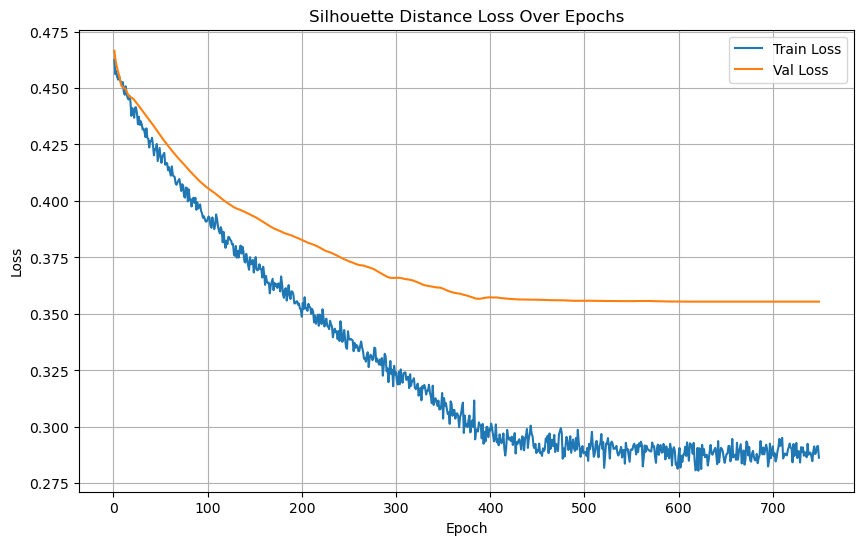

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/665], Loss: 0.2530
Test Batch [20/665], Loss: 0.2068
Test Batch [30/665], Loss: 0.2806


Test Batch [40/665], Loss: 0.2803
Test Batch [50/665], Loss: 0.4409
Test Batch [60/665], Loss: 0.4082
Test Batch [70/665], Loss: 0.2041


Test Batch [80/665], Loss: 0.1936
Test Batch [90/665], Loss: 0.1627
Test Batch [100/665], Loss: 0.1449
Test Batch [110/665], Loss: 0.1454


Test Batch [120/665], Loss: 0.2333
Test Batch [130/665], Loss: 0.1680
Test Batch [140/665], Loss: 0.1952
Test Batch [150/665], Loss: 0.5000
Test Batch [160/665], Loss: 0.1607
Test Batch [170/665], Loss: 0.1831


Test Batch [180/665], Loss: 0.5000
Test Batch [190/665], Loss: 0.1784
Test Batch [200/665], Loss: 0.2165
Test Batch [210/665], Loss: 0.5000
Test Batch [220/665], Loss: 0.2186
Test Batch [230/665], Loss: 0.1708
Test Batch [240/665], Loss: 0.5000
Test Batch [250/665], Loss: 0.5000
Test Batch [260/665], Loss: 0.5000
Test Batch [270/665], Loss: 0.5000


Test Batch [280/665], Loss: 0.5000
Test Batch [290/665], Loss: 0.5000
Test Batch [300/665], Loss: 0.5000
Test Batch [310/665], Loss: 0.1784
Test Batch [320/665], Loss: 0.1814
Test Batch [330/665], Loss: 0.1899


Test Batch [340/665], Loss: 0.2133
Test Batch [350/665], Loss: 0.2097
Test Batch [360/665], Loss: 0.2342
Test Batch [370/665], Loss: 0.1567


Test Batch [380/665], Loss: 0.1994
Test Batch [390/665], Loss: 0.1865
Test Batch [400/665], Loss: 0.1551


Test Batch [410/665], Loss: 0.1820
Test Batch [420/665], Loss: 0.1581
Test Batch [430/665], Loss: 0.2321


Test Batch [440/665], Loss: 0.3376
Test Batch [450/665], Loss: 0.3741
Test Batch [460/665], Loss: 0.4560


Test Batch [470/665], Loss: 0.2573
Test Batch [480/665], Loss: 0.2808
Test Batch [490/665], Loss: 0.2482


Test Batch [500/665], Loss: 0.3242
Test Batch [510/665], Loss: 0.1888
Test Batch [520/665], Loss: 0.2762
Test Batch [530/665], Loss: 0.2565


Test Batch [540/665], Loss: 0.2378
Test Batch [550/665], Loss: 0.2650
Test Batch [560/665], Loss: 0.2563
Test Batch [570/665], Loss: 0.2358


Test Batch [580/665], Loss: 0.1973
Test Batch [590/665], Loss: 0.2227
Test Batch [600/665], Loss: 0.4244
Test Batch [610/665], Loss: 0.3206
Test Batch [620/665], Loss: 0.4196


Test Batch [630/665], Loss: 0.2819
Test Batch [640/665], Loss: 0.2065
Test Batch [650/665], Loss: 0.3941


Test Batch [660/665], Loss: 0.3612

Test Loss: 0.2907


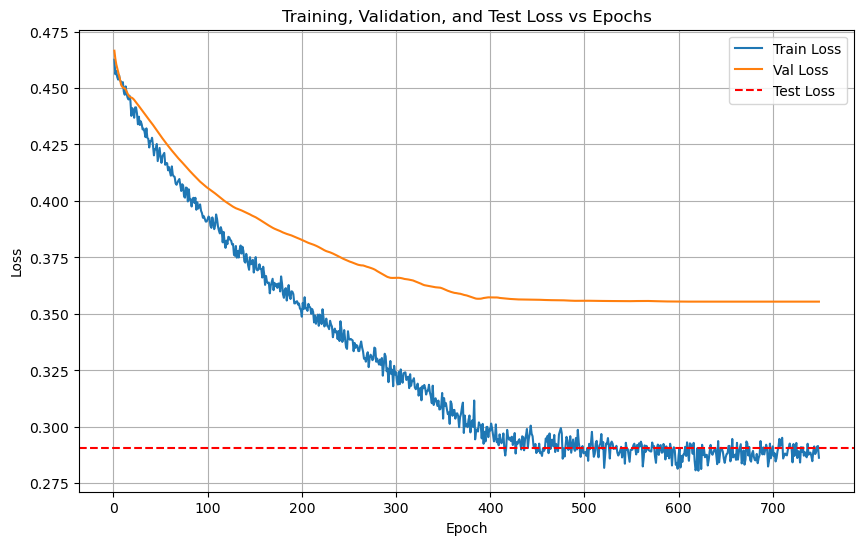

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/665 for test dataset.


  Processed batch 20/665 for test dataset.


  Processed batch 30/665 for test dataset.
  Processed batch 40/665 for test dataset.


  Processed batch 50/665 for test dataset.


  Processed batch 60/665 for test dataset.
  Processed batch 70/665 for test dataset.


  Processed batch 80/665 for test dataset.


  Processed batch 90/665 for test dataset.
  Processed batch 100/665 for test dataset.
  Processed batch 110/665 for test dataset.


  Processed batch 120/665 for test dataset.


  Processed batch 130/665 for test dataset.
  Processed batch 140/665 for test dataset.


  Processed batch 150/665 for test dataset.


  Processed batch 160/665 for test dataset.
  Processed batch 170/665 for test dataset.
  Processed batch 180/665 for test dataset.


  Processed batch 190/665 for test dataset.


  Processed batch 200/665 for test dataset.


  Processed batch 210/665 for test dataset.
  Processed batch 220/665 for test dataset.
  Processed batch 230/665 for test dataset.


  Processed batch 240/665 for test dataset.
  Processed batch 250/665 for test dataset.


  Processed batch 260/665 for test dataset.
  Processed batch 270/665 for test dataset.
  Processed batch 280/665 for test dataset.


  Processed batch 290/665 for test dataset.
  Processed batch 300/665 for test dataset.
  Processed batch 310/665 for test dataset.


  Processed batch 320/665 for test dataset.
  Processed batch 330/665 for test dataset.
  Processed batch 340/665 for test dataset.


  Processed batch 350/665 for test dataset.
  Processed batch 360/665 for test dataset.
  Processed batch 370/665 for test dataset.
  Processed batch 380/665 for test dataset.


  Processed batch 390/665 for test dataset.
  Processed batch 400/665 for test dataset.
  Processed batch 410/665 for test dataset.
  Processed batch 420/665 for test dataset.


  Processed batch 430/665 for test dataset.
  Processed batch 440/665 for test dataset.
  Processed batch 450/665 for test dataset.
  Processed batch 460/665 for test dataset.


  Processed batch 470/665 for test dataset.
  Processed batch 480/665 for test dataset.
  Processed batch 490/665 for test dataset.


  Processed batch 500/665 for test dataset.
  Processed batch 510/665 for test dataset.
  Processed batch 520/665 for test dataset.


  Processed batch 530/665 for test dataset.
  Processed batch 540/665 for test dataset.
  Processed batch 550/665 for test dataset.
  Processed batch 560/665 for test dataset.


  Processed batch 570/665 for test dataset.
  Processed batch 580/665 for test dataset.
  Processed batch 590/665 for test dataset.


  Processed batch 600/665 for test dataset.
  Processed batch 610/665 for test dataset.
  Processed batch 620/665 for test dataset.


  Processed batch 630/665 for test dataset.
  Processed batch 640/665 for test dataset.
  Processed batch 650/665 for test dataset.
  Processed batch 660/665 for test dataset.


Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42551, 128)
Test labels shape: (42551,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 75.56%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.71      1.00      0.83         5
           2       0.50      0.60      0.55         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      0.60      0.75         5
           6       0.57      0.80      0.67         5
           7       0.67      0.40      0.50         5
           8       1.00      0.80      0.89         5

    accuracy                           0.76        45
   macro avg       0.78      0.76      0.75        45
weighted avg       0.78      0.76      0.75        45


LOG: Evaluating on the test set...
Test Accuracy: 71.31%

Test Classifica

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42551, 128)
Test labels shape: (42551,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5608  |  Val Loss: 2.3983
Validation loss improved from inf to 2.3983.
[Epoch 2/1000] Train Loss: 2.4874  |  Val Loss: 2.3508
Validation loss improved from 2.3983 to 2.3508.
[Epoch 3/1000] Train Loss: 2.4233  |  Val Loss: 2.3041
Validation loss improved from 2.3508 to 2.3041.
[Epoch 4/1000] Train Loss: 2.3606  |  Val Loss: 2.2586
Validation loss improved from 2.3041 to 2.2586.
[Epoch 5/1000] Train Loss: 2.2989  |  Val Loss: 2.2159
Validation loss improved from 2.2586 to 2.2159.
[Epoch 6/1000] Train Loss: 2.2421  |  Val Loss: 2.1776
Validation loss improved from 2.2159 to 2.1776.
[Epoch 7/1000] Train Loss: 2.1913  |  Val Loss: 2.1412
Validation loss improved from 2.1776 to 2.1412.
[Epoch 8/1000] Train Loss: 2.1421  |  Val Loss: 2.1074
Validation loss improved from 2.1412 to 2.1074.
[Epoch 9/1000] Train Loss: 2.0964  |  Val Loss: 2.0749
Validation loss improved from 2.1074 to 2.0749.
[Epoch 10/1000] Train Loss: 2.0541  |  Val Loss: 2.0459
Validation loss impr

[Epoch 25/1000] Train Loss: 1.6528  |  Val Loss: 1.7417
Validation loss improved from 1.7578 to 1.7417.
[Epoch 26/1000] Train Loss: 1.6343  |  Val Loss: 1.7260
Validation loss improved from 1.7417 to 1.7260.
[Epoch 27/1000] Train Loss: 1.6155  |  Val Loss: 1.7109
Validation loss improved from 1.7260 to 1.7109.
[Epoch 28/1000] Train Loss: 1.5978  |  Val Loss: 1.6958
Validation loss improved from 1.7109 to 1.6958.
[Epoch 29/1000] Train Loss: 1.5805  |  Val Loss: 1.6808
Validation loss improved from 1.6958 to 1.6808.
[Epoch 30/1000] Train Loss: 1.5641  |  Val Loss: 1.6659
Validation loss improved from 1.6808 to 1.6659.
[Epoch 31/1000] Train Loss: 1.5471  |  Val Loss: 1.6515
Validation loss improved from 1.6659 to 1.6515.
[Epoch 32/1000] Train Loss: 1.5304  |  Val Loss: 1.6373
Validation loss improved from 1.6515 to 1.6373.


[Epoch 33/1000] Train Loss: 1.5135  |  Val Loss: 1.6232
Validation loss improved from 1.6373 to 1.6232.
[Epoch 34/1000] Train Loss: 1.4977  |  Val Loss: 1.6092
Validation loss improved from 1.6232 to 1.6092.
[Epoch 35/1000] Train Loss: 1.4814  |  Val Loss: 1.5953
Validation loss improved from 1.6092 to 1.5953.
[Epoch 36/1000] Train Loss: 1.4647  |  Val Loss: 1.5817
Validation loss improved from 1.5953 to 1.5817.
[Epoch 37/1000] Train Loss: 1.4485  |  Val Loss: 1.5681
Validation loss improved from 1.5817 to 1.5681.
[Epoch 38/1000] Train Loss: 1.4325  |  Val Loss: 1.5545
Validation loss improved from 1.5681 to 1.5545.
[Epoch 39/1000] Train Loss: 1.4164  |  Val Loss: 1.5408
Validation loss improved from 1.5545 to 1.5408.
[Epoch 40/1000] Train Loss: 1.4007  |  Val Loss: 1.5271
Validation loss improved from 1.5408 to 1.5271.
[Epoch 41/1000] Train Loss: 1.3849  |  Val Loss: 1.5134
Validation loss improved from 1.5271 to 1.5134.
[Epoch 42/1000] Train Loss: 1.3690  |  Val Loss: 1.4999
Validati

[Epoch 58/1000] Train Loss: 1.1347  |  Val Loss: 1.2930
Validation loss improved from 1.3049 to 1.2930.
[Epoch 59/1000] Train Loss: 1.1211  |  Val Loss: 1.2811
Validation loss improved from 1.2930 to 1.2811.
[Epoch 60/1000] Train Loss: 1.1081  |  Val Loss: 1.2694
Validation loss improved from 1.2811 to 1.2694.
[Epoch 61/1000] Train Loss: 1.0947  |  Val Loss: 1.2578
Validation loss improved from 1.2694 to 1.2578.
[Epoch 62/1000] Train Loss: 1.0815  |  Val Loss: 1.2464
Validation loss improved from 1.2578 to 1.2464.
[Epoch 63/1000] Train Loss: 1.0684  |  Val Loss: 1.2351
Validation loss improved from 1.2464 to 1.2351.
[Epoch 64/1000] Train Loss: 1.0554  |  Val Loss: 1.2239
Validation loss improved from 1.2351 to 1.2239.


[Epoch 65/1000] Train Loss: 1.0427  |  Val Loss: 1.2130
Validation loss improved from 1.2239 to 1.2130.
[Epoch 66/1000] Train Loss: 1.0298  |  Val Loss: 1.2022
Validation loss improved from 1.2130 to 1.2022.
[Epoch 67/1000] Train Loss: 1.0171  |  Val Loss: 1.1915
Validation loss improved from 1.2022 to 1.1915.
[Epoch 68/1000] Train Loss: 1.0045  |  Val Loss: 1.1808
Validation loss improved from 1.1915 to 1.1808.
[Epoch 69/1000] Train Loss: 0.9922  |  Val Loss: 1.1701
Validation loss improved from 1.1808 to 1.1701.
[Epoch 70/1000] Train Loss: 0.9794  |  Val Loss: 1.1595
Validation loss improved from 1.1701 to 1.1595.
[Epoch 71/1000] Train Loss: 0.9673  |  Val Loss: 1.1489
Validation loss improved from 1.1595 to 1.1489.
[Epoch 72/1000] Train Loss: 0.9549  |  Val Loss: 1.1385
Validation loss improved from 1.1489 to 1.1385.
[Epoch 73/1000] Train Loss: 0.9427  |  Val Loss: 1.1281
Validation loss improved from 1.1385 to 1.1281.
[Epoch 74/1000] Train Loss: 0.9306  |  Val Loss: 1.1181
Validati

[Epoch 92/1000] Train Loss: 0.7265  |  Val Loss: 0.9602
Validation loss improved from 0.9680 to 0.9602.
[Epoch 93/1000] Train Loss: 0.7166  |  Val Loss: 0.9526
Validation loss improved from 0.9602 to 0.9526.
[Epoch 94/1000] Train Loss: 0.7064  |  Val Loss: 0.9449
Validation loss improved from 0.9526 to 0.9449.
[Epoch 95/1000] Train Loss: 0.6966  |  Val Loss: 0.9375
Validation loss improved from 0.9449 to 0.9375.
[Epoch 96/1000] Train Loss: 0.6869  |  Val Loss: 0.9304
Validation loss improved from 0.9375 to 0.9304.
[Epoch 97/1000] Train Loss: 0.6768  |  Val Loss: 0.9232
Validation loss improved from 0.9304 to 0.9232.
[Epoch 98/1000] Train Loss: 0.6676  |  Val Loss: 0.9161
Validation loss improved from 0.9232 to 0.9161.
[Epoch 99/1000] Train Loss: 0.6582  |  Val Loss: 0.9092
Validation loss improved from 0.9161 to 0.9092.
[Epoch 100/1000] Train Loss: 0.6486  |  Val Loss: 0.9024
Validation loss improved from 0.9092 to 0.9024.
[Epoch 101/1000] Train Loss: 0.6396  |  Val Loss: 0.8957
Valida

[Epoch 124/1000] Train Loss: 0.4655  |  Val Loss: 0.7702
Validation loss improved from 0.7746 to 0.7702.
[Epoch 125/1000] Train Loss: 0.4598  |  Val Loss: 0.7658
Validation loss improved from 0.7702 to 0.7658.
[Epoch 126/1000] Train Loss: 0.4538  |  Val Loss: 0.7616
Validation loss improved from 0.7658 to 0.7616.
[Epoch 127/1000] Train Loss: 0.4482  |  Val Loss: 0.7573
Validation loss improved from 0.7616 to 0.7573.
[Epoch 128/1000] Train Loss: 0.4428  |  Val Loss: 0.7533
Validation loss improved from 0.7573 to 0.7533.
[Epoch 129/1000] Train Loss: 0.4374  |  Val Loss: 0.7494
Validation loss improved from 0.7533 to 0.7494.
[Epoch 130/1000] Train Loss: 0.4320  |  Val Loss: 0.7457
Validation loss improved from 0.7494 to 0.7457.
[Epoch 131/1000] Train Loss: 0.4268  |  Val Loss: 0.7422
Validation loss improved from 0.7457 to 0.7422.
[Epoch 132/1000] Train Loss: 0.4218  |  Val Loss: 0.7387
Validation loss improved from 0.7422 to 0.7387.
[Epoch 133/1000] Train Loss: 0.4168  |  Val Loss: 0.735

[Epoch 156/1000] Train Loss: 0.3304  |  Val Loss: 0.6775
Validation loss improved from 0.6791 to 0.6775.
[Epoch 157/1000] Train Loss: 0.3274  |  Val Loss: 0.6759
Validation loss improved from 0.6775 to 0.6759.
[Epoch 158/1000] Train Loss: 0.3247  |  Val Loss: 0.6744
Validation loss improved from 0.6759 to 0.6744.
[Epoch 159/1000] Train Loss: 0.3220  |  Val Loss: 0.6731
Validation loss improved from 0.6744 to 0.6731.
[Epoch 160/1000] Train Loss: 0.3195  |  Val Loss: 0.6720
Validation loss improved from 0.6731 to 0.6720.
[Epoch 161/1000] Train Loss: 0.3168  |  Val Loss: 0.6700
Validation loss improved from 0.6720 to 0.6700.
[Epoch 162/1000] Train Loss: 0.3143  |  Val Loss: 0.6685
Validation loss improved from 0.6700 to 0.6685.
[Epoch 163/1000] Train Loss: 0.3119  |  Val Loss: 0.6675
Validation loss improved from 0.6685 to 0.6675.
[Epoch 164/1000] Train Loss: 0.3096  |  Val Loss: 0.6661
Validation loss improved from 0.6675 to 0.6661.
[Epoch 165/1000] Train Loss: 0.3071  |  Val Loss: 0.665

[Epoch 189/1000] Train Loss: 0.2631  |  Val Loss: 0.6435
Validation loss improved from 0.6441 to 0.6435.
[Epoch 190/1000] Train Loss: 0.2617  |  Val Loss: 0.6429
Validation loss improved from 0.6435 to 0.6429.
[Epoch 191/1000] Train Loss: 0.2604  |  Val Loss: 0.6423
Validation loss improved from 0.6429 to 0.6423.
[Epoch 192/1000] Train Loss: 0.2589  |  Val Loss: 0.6419
Validation loss improved from 0.6423 to 0.6419.
[Epoch 193/1000] Train Loss: 0.2579  |  Val Loss: 0.6422
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 194/1000] Train Loss: 0.2564  |  Val Loss: 0.6414
Validation loss improved from 0.6419 to 0.6414.
[Epoch 195/1000] Train Loss: 0.2551  |  Val Loss: 0.6405
Validation loss improved from 0.6414 to 0.6405.
[Epoch 196/1000] Train Loss: 0.2538  |  Val Loss: 0.6404
Validation loss improved from 0.6405 to 0.6404.
[Epoch 197/1000] Train Loss: 0.2526  |  Val Loss: 0.6399
Validation loss improved from 0.6404 to 0.6399.
[Epoch 198/1000] Train Loss: 0.2513  |  Val Loss:

[Epoch 220/1000] Train Loss: 0.2287  |  Val Loss: 0.6353
Validation loss improved from 0.6356 to 0.6353.
[Epoch 221/1000] Train Loss: 0.2280  |  Val Loss: 0.6352
Validation loss improved from 0.6353 to 0.6352.
[Epoch 222/1000] Train Loss: 0.2271  |  Val Loss: 0.6351
Validation loss improved from 0.6352 to 0.6351.
[Epoch 223/1000] Train Loss: 0.2263  |  Val Loss: 0.6354
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 224/1000] Train Loss: 0.2254  |  Val Loss: 0.6354
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 225/1000] Train Loss: 0.2248  |  Val Loss: 0.6351
Validation loss improved from 0.6351 to 0.6351.
[Epoch 226/1000] Train Loss: 0.2238  |  Val Loss: 0.6347
Validation loss improved from 0.6351 to 0.6347.
[Epoch 227/1000] Train Loss: 0.2229  |  Val Loss: 0.6344
Validation loss improved from 0.6347 to 0.6344.
[Epoch 228/1000] Train Loss: 0.2221  |  Val Loss: 0.6346
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 229/1000] Train Loss: 0.2214  

[Epoch 251/1000] Train Loss: 0.2065  |  Val Loss: 0.6369
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 252/1000] Train Loss: 0.2059  |  Val Loss: 0.6370
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 253/1000] Train Loss: 0.2053  |  Val Loss: 0.6376
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 254/1000] Train Loss: 0.2048  |  Val Loss: 0.6376
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 255/1000] Train Loss: 0.2041  |  Val Loss: 0.6379
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 256/1000] Train Loss: 0.2035  |  Val Loss: 0.6378
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 257/1000] Train Loss: 0.2031  |  Val Loss: 0.6376
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 258/1000] Train Loss: 0.2025  |  Val Loss: 0.6389
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 259/1000] Train Loss: 0.2019  |  Val Loss: 0.6391
!! Validation loss did NOT improve !! Patience:

[Epoch 284/1000] Train Loss: 0.1892  |  Val Loss: 0.6432
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 285/1000] Train Loss: 0.1887  |  Val Loss: 0.6435
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 286/1000] Train Loss: 0.1882  |  Val Loss: 0.6438
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 287/1000] Train Loss: 0.1878  |  Val Loss: 0.6429
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 288/1000] Train Loss: 0.1874  |  Val Loss: 0.6426
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 289/1000] Train Loss: 0.1870  |  Val Loss: 0.6432
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 290/1000] Train Loss: 0.1866  |  Val Loss: 0.6438
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 291/1000] Train Loss: 0.1860  |  Val Loss: 0.6432
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 292/1000] Train Loss: 0.1858  |  Val Loss: 0.6429
!! Validation loss did NOT improve !! Patience:

[Epoch 315/1000] Train Loss: 0.1764  |  Val Loss: 0.6461
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 316/1000] Train Loss: 0.1760  |  Val Loss: 0.6464
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 317/1000] Train Loss: 0.1757  |  Val Loss: 0.6456
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 318/1000] Train Loss: 0.1754  |  Val Loss: 0.6450
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 319/1000] Train Loss: 0.1749  |  Val Loss: 0.6451
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 320/1000] Train Loss: 0.1747  |  Val Loss: 0.6456
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 321/1000] Train Loss: 0.1742  |  Val Loss: 0.6455
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 322/1000] Train Loss: 0.1738  |  Val Loss: 0.6459
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 323/1000] Train Loss: 0.1736  |  Val Loss: 0.6466
!! Validation loss did NOT improve !! Patience:

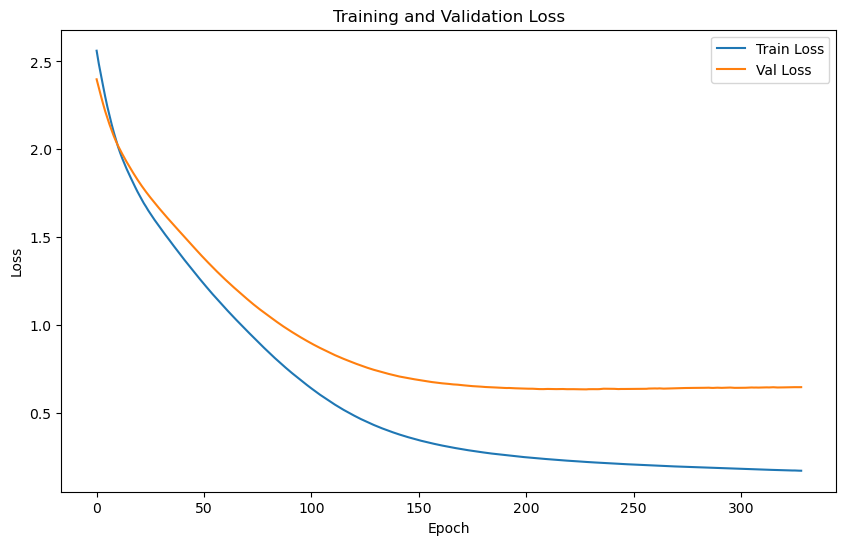

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.8322 | Test Accuracy: 70.01%


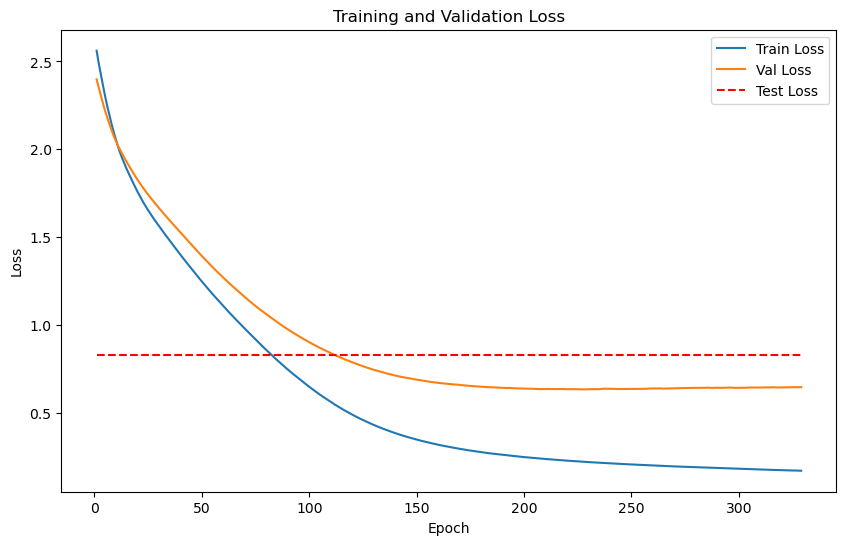

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


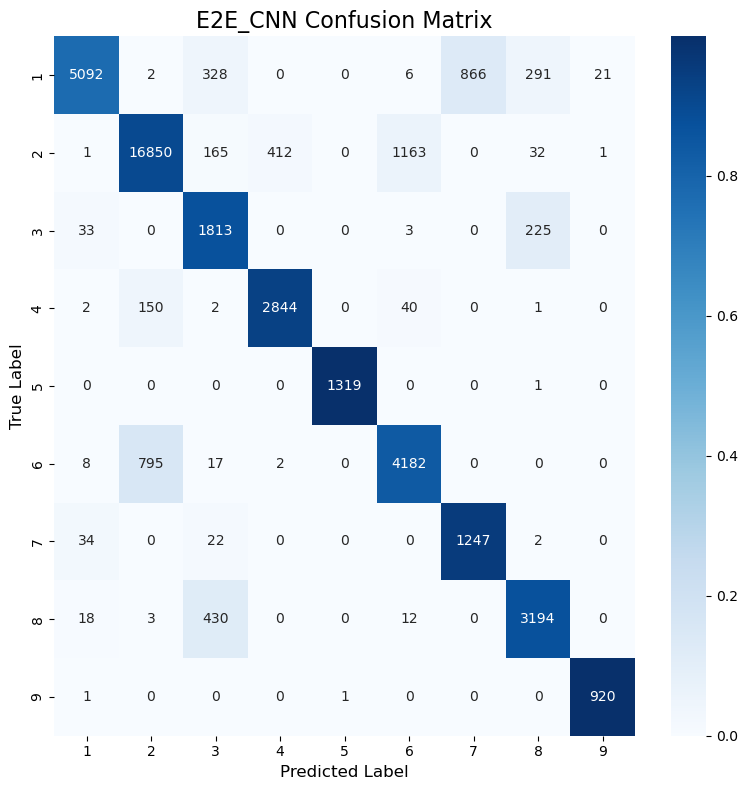

Classification Accuracy: 88.04%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


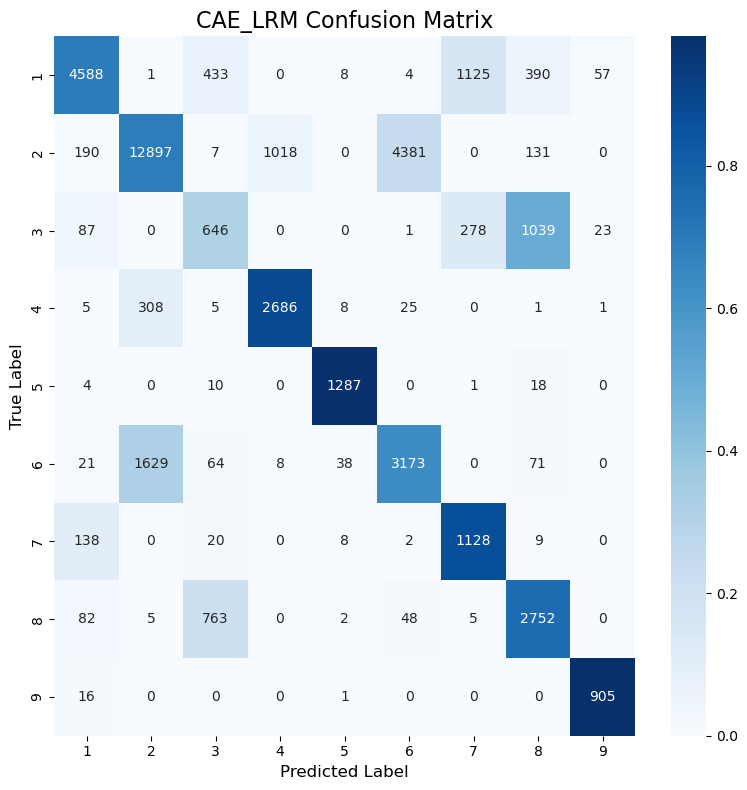

Classification Accuracy: 70.65%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


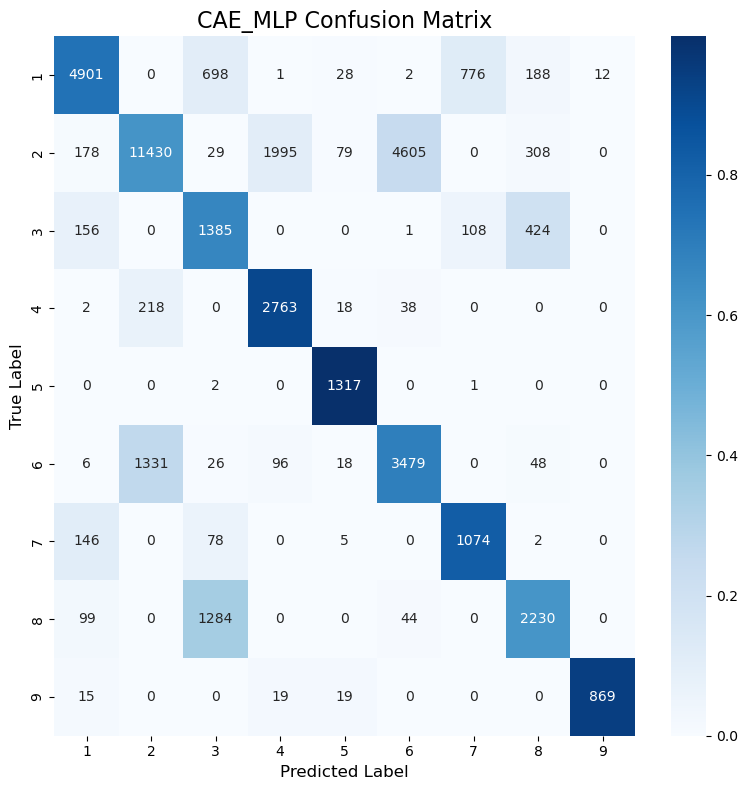

Classification Accuracy: 69.21%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


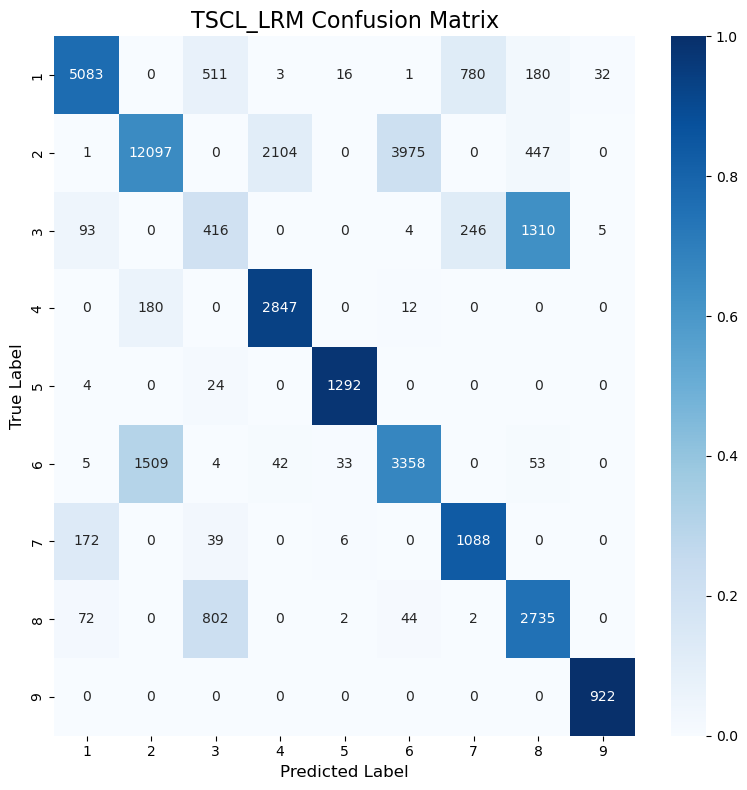

Classification Accuracy: 70.12%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


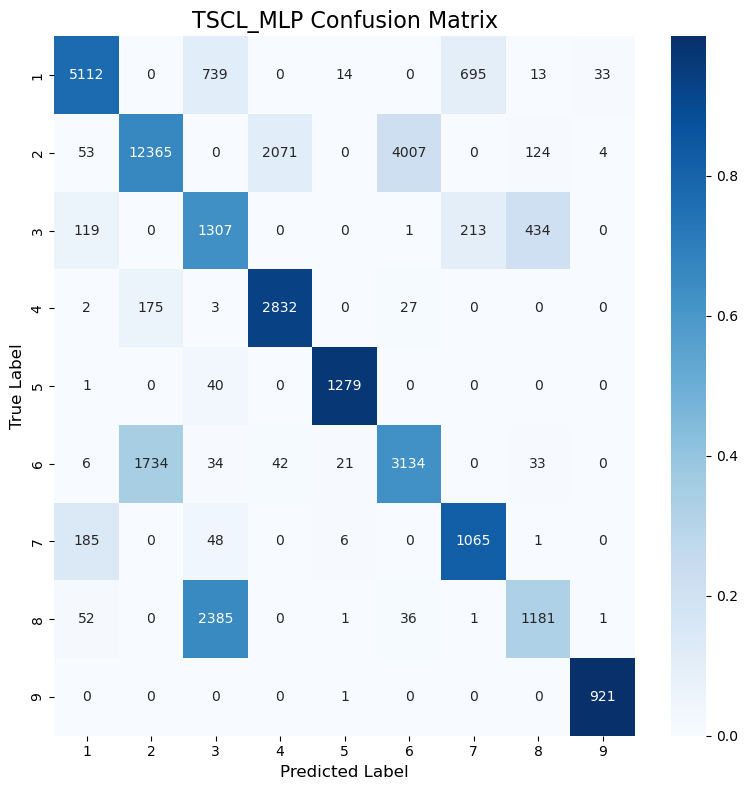

Classification Accuracy: 68.61%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


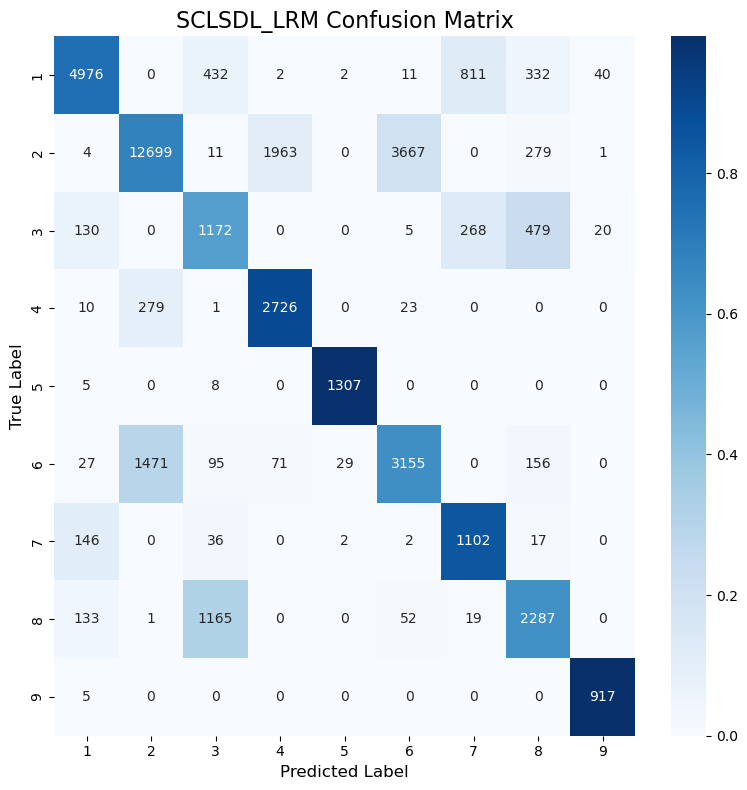

Classification Accuracy: 71.31%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


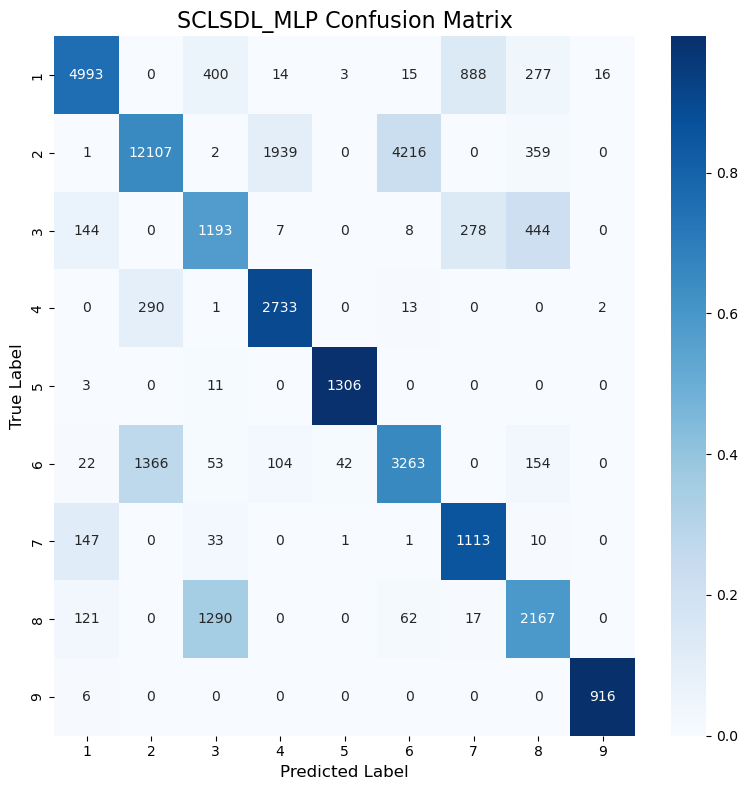

Classification Accuracy: 70.01%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          88.04
1    LRM (CAE)          70.65
2    MLP (CAE)          69.21
3     TSCL LRM          70.12
4     TSCL MLP          68.61
5  SCL_SDL LRM          71.31
6  SCL_SDL MLP          70.01

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          88.04
5  SCL_SDL LRM          71.31
1    LRM (CAE)          70.65
3     TSCL LRM          70.12
6  SCL_SDL MLP          70.01
2    MLP (CAE)          69.21
4     TSCL MLP          68.61
